# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-besra'
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [8]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [9]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [10]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [11]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [12]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [13]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [14]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [15]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [16]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=64, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [18]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [20]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [21]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = HateSpeechDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))
    
    accelerator.wait_for_everyone()    
    if accelerator.is_local_main_process:
        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)

        target_samples = math.ceil(0.1 * len(X_pool))
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)

        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(score_changes)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [22]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size

    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [23]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 61, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6072, Accuracy: 0.8196, F1 Micro: 0.158, F1 Macro: 0.056
Epoch 2/10, Train Loss: 0.4725, Accuracy: 0.8281, F1 Micro: 0.0079, F1 Macro: 0.0031
Epoch 3/10, Train Loss: 0.4011, Accuracy: 0.8324, F1 Micro: 0.0621, F1 Macro: 0.0249
Epoch 4/10, Train Loss: 0.4044, Accuracy: 0.833, F1 Micro: 0.0698, F1 Macro: 0.0275
Epoch 5/10, Train Loss: 0.39, Accuracy: 0.835, F1 Micro: 0.0933, F1 Macro: 0.0364
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3774, Accuracy: 0.8482, F1 Micro: 0.2492, F1 Macro: 0.0877
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3646, Accuracy: 0.8569, F1 Micro: 0.3507, F1 Macro: 0.1183
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3408, Accuracy: 0.871, F1 Micro: 0.473, F1 Macro: 0.208
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3045, Accuracy: 0.8761, F1 Micro: 0.5665, F1 Macro: 0.2665
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.272, Accuracy: 0.87

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6268, Accuracy: 0.8269, F1 Micro: 0.1933, F1 Macro: 0.0535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4844, Accuracy: 0.8431, F1 Micro: 0.2905, F1 Macro: 0.0901
Epoch 3/10, Train Loss: 0.4084, Accuracy: 0.8367, F1 Micro: 0.1258, F1 Macro: 0.0434
Epoch 4/10, Train Loss: 0.4073, Accuracy: 0.8361, F1 Micro: 0.1149, F1 Macro: 0.0411
Epoch 5/10, Train Loss: 0.3883, Accuracy: 0.8442, F1 Micro: 0.2237, F1 Macro: 0.0783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3744, Accuracy: 0.8537, F1 Micro: 0.3359, F1 Macro: 0.1086
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.361, Accuracy: 0.8638, F1 Micro: 0.4298, F1 Macro: 0.1602
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3381, Accuracy: 0.872, F1 Micro: 0.4844, F1 Macro: 0.2089
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3027, Accuracy: 0.8754, F1 Micro: 0.5488, F1 Macro: 0.2523
Epoch 10/10, Train Loss: 0.2788, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6425, Accuracy: 0.7948, F1 Micro: 0.3968, F1 Macro: 0.1198
Epoch 2/10, Train Loss: 0.4902, Accuracy: 0.8356, F1 Micro: 0.1886, F1 Macro: 0.0538
Epoch 3/10, Train Loss: 0.4047, Accuracy: 0.8326, F1 Micro: 0.0804, F1 Macro: 0.0306
Epoch 4/10, Train Loss: 0.4031, Accuracy: 0.8344, F1 Micro: 0.1031, F1 Macro: 0.0375
Epoch 5/10, Train Loss: 0.3878, Accuracy: 0.8367, F1 Micro: 0.1276, F1 Macro: 0.047
Epoch 6/10, Train Loss: 0.3748, Accuracy: 0.8493, F1 Micro: 0.2727, F1 Macro: 0.0935
Epoch 7/10, Train Loss: 0.3632, Accuracy: 0.8552, F1 Micro: 0.3382, F1 Macro: 0.1118
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3437, Accuracy: 0.8634, F1 Micro: 0.4097, F1 Macro: 0.1654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3109, Accuracy: 0.8763, F1 Micro: 0.5497, F1 Macro: 0.2516
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2794, Accuracy: 0.8776, F1 Micro: 0.5601, F1 Macro: 0.2635
Model 3 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5354, Accuracy: 0.8331, F1 Micro: 0.0915, F1 Macro: 0.0337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4137, Accuracy: 0.8374, F1 Micro: 0.124, F1 Macro: 0.0486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3875, Accuracy: 0.8565, F1 Micro: 0.3952, F1 Macro: 0.1321
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3557, Accuracy: 0.8768, F1 Micro: 0.5613, F1 Macro: 0.2589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3113, Accuracy: 0.8819, F1 Micro: 0.6126, F1 Macro: 0.2996
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2718, Accuracy: 0.8856, F1 Micro: 0.6261, F1 Macro: 0.329
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2411, Accuracy: 0.8894, F1 Micro: 0.636, F1 Macro: 0.3515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2167, Accuracy: 0.8884, F1 Micro: 0.67, F1 Macro: 0.4222
Epoch 9/10, Train Loss: 0.2038, Accuracy: 0.8903, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5528, Accuracy: 0.842, F1 Micro: 0.3679, F1 Macro: 0.1051
Epoch 2/10, Train Loss: 0.4153, Accuracy: 0.8428, F1 Micro: 0.2195, F1 Macro: 0.0779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3848, Accuracy: 0.8584, F1 Micro: 0.4309, F1 Macro: 0.1449
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3533, Accuracy: 0.8774, F1 Micro: 0.5442, F1 Macro: 0.2453
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3165, Accuracy: 0.8801, F1 Micro: 0.6108, F1 Macro: 0.2951
Epoch 6/10, Train Loss: 0.2768, Accuracy: 0.8852, F1 Micro: 0.6103, F1 Macro: 0.3176
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2461, Accuracy: 0.8878, F1 Micro: 0.645, F1 Macro: 0.3628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2235, Accuracy: 0.887, F1 Micro: 0.6709, F1 Macro: 0.4061
Epoch 9/10, Train Loss: 0.2059, Accuracy: 0.8909, F1 Micro: 0.6474, F1 Macro: 0.4278
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5595, Accuracy: 0.8347, F1 Micro: 0.1705, F1 Macro: 0.0543
Epoch 2/10, Train Loss: 0.4152, Accuracy: 0.8368, F1 Micro: 0.1334, F1 Macro: 0.05
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3858, Accuracy: 0.8548, F1 Micro: 0.3437, F1 Macro: 0.1103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3581, Accuracy: 0.8734, F1 Micro: 0.5056, F1 Macro: 0.2195
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3173, Accuracy: 0.88, F1 Micro: 0.6159, F1 Macro: 0.2923
Epoch 6/10, Train Loss: 0.2781, Accuracy: 0.8849, F1 Micro: 0.6041, F1 Macro: 0.3077
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2503, Accuracy: 0.8892, F1 Micro: 0.6374, F1 Macro: 0.3601
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2268, Accuracy: 0.8836, F1 Micro: 0.6739, F1 Macro: 0.4302
Epoch 9/10, Train Loss: 0.2108, Accuracy: 0.8901, F1 Micro: 0.6168, F1 Macro: 0.3987
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4945, Accuracy: 0.8349, F1 Micro: 0.0942, F1 Macro: 0.0369
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3857, Accuracy: 0.8521, F1 Micro: 0.3048, F1 Macro: 0.1021
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3366, Accuracy: 0.8792, F1 Micro: 0.5635, F1 Macro: 0.2656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2992, Accuracy: 0.8868, F1 Micro: 0.6381, F1 Macro: 0.346
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2538, Accuracy: 0.8914, F1 Micro: 0.6506, F1 Macro: 0.4203
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.231, Accuracy: 0.8964, F1 Micro: 0.6649, F1 Macro: 0.4286
Epoch 7/10, Train Loss: 0.2007, Accuracy: 0.898, F1 Micro: 0.6603, F1 Macro: 0.4418
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1765, Accuracy: 0.896, F1 Micro: 0.7012, F1 Macro: 0.5012
Epoch 9/10, Train Loss: 0.1591, Accuracy: 0.8986, F1 Micro: 0.7006, F1 Macro: 0.5053
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.508, Accuracy: 0.8385, F1 Micro: 0.1528, F1 Macro: 0.0541
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.384, Accuracy: 0.857, F1 Micro: 0.3592, F1 Macro: 0.1182
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.336, Accuracy: 0.8792, F1 Micro: 0.5867, F1 Macro: 0.2739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3014, Accuracy: 0.8851, F1 Micro: 0.6452, F1 Macro: 0.3427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2559, Accuracy: 0.8916, F1 Micro: 0.6501, F1 Macro: 0.4317
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2387, Accuracy: 0.8952, F1 Micro: 0.6761, F1 Macro: 0.4233
Epoch 7/10, Train Loss: 0.2095, Accuracy: 0.8989, F1 Micro: 0.6688, F1 Macro: 0.4607
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1803, Accuracy: 0.8971, F1 Micro: 0.6959, F1 Macro: 0.4882
Epoch 9/10, Train Loss: 0.1664, Accuracy: 0.901, F1 Micro: 0.6938, F1 Macro: 0.4942
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5114, Accuracy: 0.8375, F1 Micro: 0.1591, F1 Macro: 0.059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3841, Accuracy: 0.848, F1 Micro: 0.2595, F1 Macro: 0.0882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3404, Accuracy: 0.8789, F1 Micro: 0.5558, F1 Macro: 0.2574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.305, Accuracy: 0.8841, F1 Micro: 0.6399, F1 Macro: 0.333
Epoch 5/10, Train Loss: 0.2585, Accuracy: 0.8913, F1 Micro: 0.6376, F1 Macro: 0.4058
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2385, Accuracy: 0.8962, F1 Micro: 0.6742, F1 Macro: 0.4237
Epoch 7/10, Train Loss: 0.2093, Accuracy: 0.8987, F1 Micro: 0.6699, F1 Macro: 0.4693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1822, Accuracy: 0.8944, F1 Micro: 0.6945, F1 Macro: 0.5065
Epoch 9/10, Train Loss: 0.1658, Accuracy: 0.9017, F1 Micro: 0.6931, F1 Macro: 0.5086
Epoch 10/10, Train Loss: 0.1415, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4709, Accuracy: 0.8383, F1 Micro: 0.1362, F1 Macro: 0.0513
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3674, Accuracy: 0.8763, F1 Micro: 0.5235, F1 Macro: 0.2437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3107, Accuracy: 0.8848, F1 Micro: 0.5864, F1 Macro: 0.3038
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2696, Accuracy: 0.8906, F1 Micro: 0.6061, F1 Macro: 0.3946
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2351, Accuracy: 0.8991, F1 Micro: 0.6883, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1963, Accuracy: 0.9011, F1 Micro: 0.6951, F1 Macro: 0.4869
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1631, Accuracy: 0.9043, F1 Micro: 0.7177, F1 Macro: 0.5258
Epoch 8/10, Train Loss: 0.1507, Accuracy: 0.9075, F1 Micro: 0.7125, F1 Macro: 0.5413
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1247, Accuracy: 0.9086, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4797, Accuracy: 0.8459, F1 Micro: 0.2448, F1 Macro: 0.0832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3642, Accuracy: 0.8773, F1 Micro: 0.5666, F1 Macro: 0.2581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3126, Accuracy: 0.8871, F1 Micro: 0.6218, F1 Macro: 0.3271
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2696, Accuracy: 0.8955, F1 Micro: 0.6457, F1 Macro: 0.4469
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2383, Accuracy: 0.9009, F1 Micro: 0.6812, F1 Macro: 0.4759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1976, Accuracy: 0.9031, F1 Micro: 0.6997, F1 Macro: 0.5048
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1669, Accuracy: 0.9042, F1 Micro: 0.7221, F1 Macro: 0.5272
Epoch 8/10, Train Loss: 0.1549, Accuracy: 0.9062, F1 Micro: 0.7031, F1 Macro: 0.5339
Epoch 9/10, Train Loss: 0.1264, Accuracy: 0.9084, F1 Micro: 0.7106, F1 Macro: 0.533
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4842, Accuracy: 0.8397, F1 Micro: 0.1651, F1 Macro: 0.0616
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3675, Accuracy: 0.8732, F1 Micro: 0.5055, F1 Macro: 0.2195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3143, Accuracy: 0.8859, F1 Micro: 0.6021, F1 Macro: 0.3191
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2712, Accuracy: 0.8954, F1 Micro: 0.6421, F1 Macro: 0.4484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2403, Accuracy: 0.9018, F1 Micro: 0.6869, F1 Macro: 0.4951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1998, Accuracy: 0.9039, F1 Micro: 0.7054, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1689, Accuracy: 0.9043, F1 Micro: 0.7187, F1 Macro: 0.535
Epoch 8/10, Train Loss: 0.1557, Accuracy: 0.9074, F1 Micro: 0.6988, F1 Macro: 0.5519
Epoch 9/10, Train Loss: 0.1321, Accuracy: 0.9082, F1 Micro: 0.7163, F1 Macro: 0.5502
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4593, Accuracy: 0.8458, F1 Micro: 0.236, F1 Macro: 0.0817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3496, Accuracy: 0.8826, F1 Micro: 0.6164, F1 Macro: 0.3009
Epoch 3/10, Train Loss: 0.2855, Accuracy: 0.8903, F1 Micro: 0.6085, F1 Macro: 0.3586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2482, Accuracy: 0.8992, F1 Micro: 0.6616, F1 Macro: 0.4222
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2145, Accuracy: 0.9044, F1 Micro: 0.6956, F1 Macro: 0.484
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1847, Accuracy: 0.9078, F1 Micro: 0.72, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1576, Accuracy: 0.9027, F1 Micro: 0.7241, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1312, Accuracy: 0.908, F1 Micro: 0.7258, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1154, Accuracy: 0.9027, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4658, Accuracy: 0.8517, F1 Micro: 0.3316, F1 Macro: 0.1065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3485, Accuracy: 0.88, F1 Micro: 0.6049, F1 Macro: 0.2941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2858, Accuracy: 0.8938, F1 Micro: 0.6427, F1 Macro: 0.3858
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2502, Accuracy: 0.8998, F1 Micro: 0.6716, F1 Macro: 0.4145
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.215, Accuracy: 0.9046, F1 Micro: 0.6986, F1 Macro: 0.502
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1888, Accuracy: 0.9082, F1 Micro: 0.7097, F1 Macro: 0.5165
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1617, Accuracy: 0.8992, F1 Micro: 0.7179, F1 Macro: 0.5565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.139, Accuracy: 0.9078, F1 Micro: 0.7349, F1 Macro: 0.5843
Epoch 9/10, Train Loss: 0.1186, Accuracy: 0.9059, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4685, Accuracy: 0.8456, F1 Micro: 0.2556, F1 Macro: 0.0852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3526, Accuracy: 0.8807, F1 Micro: 0.6167, F1 Macro: 0.3048
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2871, Accuracy: 0.896, F1 Micro: 0.6532, F1 Macro: 0.3953
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2483, Accuracy: 0.8997, F1 Micro: 0.6642, F1 Macro: 0.4488
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2173, Accuracy: 0.9045, F1 Micro: 0.6941, F1 Macro: 0.4942
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1888, Accuracy: 0.9062, F1 Micro: 0.7218, F1 Macro: 0.5531
Epoch 7/10, Train Loss: 0.1607, Accuracy: 0.8937, F1 Micro: 0.7145, F1 Macro: 0.5605
Epoch 8/10, Train Loss: 0.1374, Accuracy: 0.9073, F1 Micro: 0.7194, F1 Macro: 0.5786
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1221, Accuracy: 0.9085, F1 Micro: 0.7413, F1 Macro: 0.5949
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.8524, F1 Micro: 0.3238, F1 Macro: 0.1049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3342, Accuracy: 0.8819, F1 Micro: 0.56, F1 Macro: 0.2757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2776, Accuracy: 0.897, F1 Micro: 0.6673, F1 Macro: 0.4095
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2324, Accuracy: 0.9031, F1 Micro: 0.707, F1 Macro: 0.5107
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1972, Accuracy: 0.9054, F1 Micro: 0.7203, F1 Macro: 0.5606
Epoch 6/10, Train Loss: 0.1731, Accuracy: 0.9081, F1 Micro: 0.7161, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1476, Accuracy: 0.9063, F1 Micro: 0.7343, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1261, Accuracy: 0.9137, F1 Micro: 0.7358, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1058, Accuracy: 0.9081, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.454, Accuracy: 0.8539, F1 Micro: 0.3363, F1 Macro: 0.1103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.332, Accuracy: 0.8828, F1 Micro: 0.5746, F1 Macro: 0.2763
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.28, Accuracy: 0.8973, F1 Micro: 0.6738, F1 Macro: 0.4288
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2362, Accuracy: 0.9024, F1 Micro: 0.6969, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2013, Accuracy: 0.9088, F1 Micro: 0.7128, F1 Macro: 0.5432
Epoch 6/10, Train Loss: 0.1803, Accuracy: 0.9102, F1 Micro: 0.7087, F1 Macro: 0.5349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1538, Accuracy: 0.9076, F1 Micro: 0.7346, F1 Macro: 0.5855
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1337, Accuracy: 0.9108, F1 Micro: 0.739, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1132, Accuracy: 0.9071, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4571, Accuracy: 0.8506, F1 Micro: 0.2926, F1 Macro: 0.0982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3374, Accuracy: 0.881, F1 Micro: 0.5561, F1 Macro: 0.2734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2815, Accuracy: 0.8973, F1 Micro: 0.6814, F1 Macro: 0.4465
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2382, Accuracy: 0.9014, F1 Micro: 0.7077, F1 Macro: 0.5239
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2018, Accuracy: 0.9085, F1 Micro: 0.7224, F1 Macro: 0.5634
Epoch 6/10, Train Loss: 0.1784, Accuracy: 0.9101, F1 Micro: 0.7221, F1 Macro: 0.5544
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1529, Accuracy: 0.9027, F1 Micro: 0.7327, F1 Macro: 0.5875
Epoch 8/10, Train Loss: 0.1345, Accuracy: 0.9139, F1 Micro: 0.7256, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1116, Accuracy: 0.9109, F1 Micro: 0.7428, F1 Macro: 0.6152
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4385, Accuracy: 0.861, F1 Micro: 0.4455, F1 Macro: 0.1619
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3192, Accuracy: 0.8898, F1 Micro: 0.6221, F1 Macro: 0.328
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2565, Accuracy: 0.9023, F1 Micro: 0.6993, F1 Macro: 0.4753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2177, Accuracy: 0.9038, F1 Micro: 0.7041, F1 Macro: 0.4932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1858, Accuracy: 0.905, F1 Micro: 0.7311, F1 Macro: 0.5614
Epoch 6/10, Train Loss: 0.1553, Accuracy: 0.9113, F1 Micro: 0.7295, F1 Macro: 0.5637
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1358, Accuracy: 0.9156, F1 Micro: 0.7414, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.111, Accuracy: 0.9167, F1 Micro: 0.747, F1 Macro: 0.6135
Epoch 9/10, Train Loss: 0.0989, Accuracy: 0.9159, F1 Micro: 0.746, F1 Macro: 0.6386
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4439, Accuracy: 0.8634, F1 Micro: 0.4552, F1 Macro: 0.1651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3179, Accuracy: 0.8863, F1 Micro: 0.5869, F1 Macro: 0.3027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2575, Accuracy: 0.9005, F1 Micro: 0.6915, F1 Macro: 0.4674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2223, Accuracy: 0.9058, F1 Micro: 0.7006, F1 Macro: 0.4964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1902, Accuracy: 0.9093, F1 Micro: 0.7339, F1 Macro: 0.5541
Epoch 6/10, Train Loss: 0.1628, Accuracy: 0.9097, F1 Micro: 0.7297, F1 Macro: 0.5434
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1424, Accuracy: 0.9138, F1 Micro: 0.747, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1173, Accuracy: 0.9144, F1 Micro: 0.7484, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1042, Accuracy: 0.9154, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4472, Accuracy: 0.8556, F1 Micro: 0.3641, F1 Macro: 0.1143
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3226, Accuracy: 0.8859, F1 Micro: 0.5912, F1 Macro: 0.3009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2602, Accuracy: 0.9019, F1 Micro: 0.6872, F1 Macro: 0.4805
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2248, Accuracy: 0.9057, F1 Micro: 0.6998, F1 Macro: 0.5183
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1921, Accuracy: 0.9085, F1 Micro: 0.7328, F1 Macro: 0.5658
Epoch 6/10, Train Loss: 0.1652, Accuracy: 0.9111, F1 Micro: 0.7315, F1 Macro: 0.5605
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1425, Accuracy: 0.9167, F1 Micro: 0.7419, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1185, Accuracy: 0.9158, F1 Micro: 0.7504, F1 Macro: 0.6201
Epoch 9/10, Train Loss: 0.1042, Accuracy: 0.9167, F1 Micro: 0.7504, F1 Macro: 0.6311
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4346, Accuracy: 0.8623, F1 Micro: 0.4074, F1 Macro: 0.1493
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.313, Accuracy: 0.8917, F1 Micro: 0.6257, F1 Macro: 0.344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2511, Accuracy: 0.9031, F1 Micro: 0.7049, F1 Macro: 0.4952
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2218, Accuracy: 0.9092, F1 Micro: 0.7129, F1 Macro: 0.5398
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1846, Accuracy: 0.9128, F1 Micro: 0.7261, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1577, Accuracy: 0.9138, F1 Micro: 0.7403, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.133, Accuracy: 0.915, F1 Micro: 0.7515, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1111, Accuracy: 0.916, F1 Micro: 0.753, F1 Macro: 0.6298
Epoch 9/10, Train Loss: 0.0966, Accuracy: 0.9174, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4391, Accuracy: 0.8643, F1 Micro: 0.4421, F1 Macro: 0.1628
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3139, Accuracy: 0.8916, F1 Micro: 0.653, F1 Macro: 0.3732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2534, Accuracy: 0.9018, F1 Micro: 0.6986, F1 Macro: 0.4773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2249, Accuracy: 0.9096, F1 Micro: 0.7149, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1894, Accuracy: 0.9129, F1 Micro: 0.7214, F1 Macro: 0.5376
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1641, Accuracy: 0.9142, F1 Micro: 0.7228, F1 Macro: 0.5488
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1385, Accuracy: 0.9147, F1 Micro: 0.7484, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1162, Accuracy: 0.9171, F1 Micro: 0.7532, F1 Macro: 0.6228
Epoch 9/10, Train Loss: 0.1002, Accuracy: 0.916, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4413, Accuracy: 0.8586, F1 Micro: 0.3831, F1 Macro: 0.1288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3166, Accuracy: 0.8915, F1 Micro: 0.6278, F1 Macro: 0.3516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2565, Accuracy: 0.9009, F1 Micro: 0.6961, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2263, Accuracy: 0.9082, F1 Micro: 0.716, F1 Macro: 0.546
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1899, Accuracy: 0.9123, F1 Micro: 0.7239, F1 Macro: 0.5616
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1649, Accuracy: 0.9142, F1 Micro: 0.7322, F1 Macro: 0.5865
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1381, Accuracy: 0.9132, F1 Micro: 0.7483, F1 Macro: 0.5978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1173, Accuracy: 0.9172, F1 Micro: 0.7502, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4236, Accuracy: 0.8728, F1 Micro: 0.5138, F1 Macro: 0.2212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3021, Accuracy: 0.8962, F1 Micro: 0.6665, F1 Macro: 0.4339
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2501, Accuracy: 0.9026, F1 Micro: 0.7095, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2081, Accuracy: 0.9121, F1 Micro: 0.7301, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9136, F1 Micro: 0.7333, F1 Macro: 0.5828
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1487, Accuracy: 0.9157, F1 Micro: 0.7461, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1254, Accuracy: 0.9178, F1 Micro: 0.7571, F1 Macro: 0.6235
Epoch 8/10, Train Loss: 0.1098, Accuracy: 0.9186, F1 Micro: 0.7509, F1 Macro: 0.6286
Epoch 9/10, Train Loss: 0.0897, Accuracy: 0.9205, F1 Micro: 0.757, F1 Macro: 0.6433
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4274, Accuracy: 0.8722, F1 Micro: 0.5642, F1 Macro: 0.243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3045, Accuracy: 0.8946, F1 Micro: 0.645, F1 Macro: 0.3932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2522, Accuracy: 0.9028, F1 Micro: 0.7073, F1 Macro: 0.4904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2098, Accuracy: 0.9119, F1 Micro: 0.7267, F1 Macro: 0.5519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.916, F1 Micro: 0.7416, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1517, Accuracy: 0.9145, F1 Micro: 0.7516, F1 Macro: 0.6153
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.9166, F1 Micro: 0.7494, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9171, F1 Micro: 0.7539, F1 Macro: 0.6331
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0909, Accuracy: 0.9178, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4301, Accuracy: 0.8683, F1 Micro: 0.4821, F1 Macro: 0.1896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3065, Accuracy: 0.894, F1 Micro: 0.6474, F1 Macro: 0.4099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2536, Accuracy: 0.902, F1 Micro: 0.7097, F1 Macro: 0.5037
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2116, Accuracy: 0.9114, F1 Micro: 0.7289, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1781, Accuracy: 0.9148, F1 Micro: 0.7387, F1 Macro: 0.59
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1505, Accuracy: 0.9128, F1 Micro: 0.7492, F1 Macro: 0.599
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1285, Accuracy: 0.9169, F1 Micro: 0.7593, F1 Macro: 0.6287
Epoch 8/10, Train Loss: 0.1122, Accuracy: 0.916, F1 Micro: 0.7507, F1 Macro: 0.6348
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0926, Accuracy: 0.9163, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4215, Accuracy: 0.8747, F1 Micro: 0.5146, F1 Macro: 0.2347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2998, Accuracy: 0.8955, F1 Micro: 0.6465, F1 Macro: 0.4183
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2427, Accuracy: 0.9047, F1 Micro: 0.6992, F1 Macro: 0.4713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9135, F1 Micro: 0.7392, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.173, Accuracy: 0.9129, F1 Micro: 0.7435, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9178, F1 Micro: 0.7519, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1234, Accuracy: 0.9164, F1 Micro: 0.7582, F1 Macro: 0.634
Epoch 8/10, Train Loss: 0.1054, Accuracy: 0.9196, F1 Micro: 0.7581, F1 Macro: 0.6593
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0915, Accuracy: 0.9188, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4246, Accuracy: 0.8743, F1 Micro: 0.506, F1 Macro: 0.2242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3014, Accuracy: 0.8921, F1 Micro: 0.6213, F1 Macro: 0.382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2469, Accuracy: 0.9054, F1 Micro: 0.6898, F1 Macro: 0.4771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2102, Accuracy: 0.9116, F1 Micro: 0.7252, F1 Macro: 0.5356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1775, Accuracy: 0.9142, F1 Micro: 0.7437, F1 Macro: 0.5869
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1534, Accuracy: 0.9171, F1 Micro: 0.7516, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1277, Accuracy: 0.9176, F1 Micro: 0.7535, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1084, Accuracy: 0.9169, F1 Micro: 0.7571, F1 Macro: 0.6602
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.09

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4274, Accuracy: 0.8679, F1 Micro: 0.4575, F1 Macro: 0.1905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3038, Accuracy: 0.8933, F1 Micro: 0.6331, F1 Macro: 0.3998
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2485, Accuracy: 0.9047, F1 Micro: 0.6995, F1 Macro: 0.5014
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2102, Accuracy: 0.9122, F1 Micro: 0.7262, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1762, Accuracy: 0.9134, F1 Micro: 0.746, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.156, Accuracy: 0.9122, F1 Micro: 0.7502, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1323, Accuracy: 0.9184, F1 Micro: 0.7581, F1 Macro: 0.6148
Epoch 8/10, Train Loss: 0.1097, Accuracy: 0.9204, F1 Micro: 0.7537, F1 Macro: 0.6429
Epoch 9/10, Train Loss: 0.0943, Accuracy: 0.9171, F1 Micro: 0.7574, F1 Macro: 0.6405
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4173, Accuracy: 0.8745, F1 Micro: 0.5043, F1 Macro: 0.2298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.8918, F1 Micro: 0.6098, F1 Macro: 0.3789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2457, Accuracy: 0.9009, F1 Micro: 0.7155, F1 Macro: 0.5156
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2084, Accuracy: 0.9125, F1 Micro: 0.7373, F1 Macro: 0.5612
Epoch 5/10, Train Loss: 0.1795, Accuracy: 0.9137, F1 Micro: 0.7373, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.142, Accuracy: 0.9174, F1 Micro: 0.749, F1 Macro: 0.6214
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.9196, F1 Micro: 0.7605, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.919, F1 Micro: 0.7633, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.0906, Accuracy: 0.9205, F1 Micro: 0.7581, F1 Macro: 0.6649
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4197, Accuracy: 0.8768, F1 Micro: 0.525, F1 Macro: 0.235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2878, Accuracy: 0.8943, F1 Micro: 0.6263, F1 Macro: 0.372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2482, Accuracy: 0.9021, F1 Micro: 0.7114, F1 Macro: 0.5012
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.209, Accuracy: 0.9113, F1 Micro: 0.7401, F1 Macro: 0.5773
Epoch 5/10, Train Loss: 0.1799, Accuracy: 0.9159, F1 Micro: 0.739, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1426, Accuracy: 0.9184, F1 Micro: 0.7499, F1 Macro: 0.6142
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.92, F1 Micro: 0.7612, F1 Macro: 0.6517
Epoch 8/10, Train Loss: 0.1054, Accuracy: 0.919, F1 Micro: 0.7579, F1 Macro: 0.6507
Epoch 9/10, Train Loss: 0.0906, Accuracy: 0.9178, F1 Micro: 0.7579, F1 Macro: 0.6696
Epoch 10/10, Train Loss: 0.076, Accuracy: 0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4229, Accuracy: 0.8715, F1 Micro: 0.4848, F1 Macro: 0.2099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2884, Accuracy: 0.8953, F1 Micro: 0.6384, F1 Macro: 0.3762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2471, Accuracy: 0.9021, F1 Micro: 0.7161, F1 Macro: 0.5241
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2102, Accuracy: 0.9135, F1 Micro: 0.7339, F1 Macro: 0.5574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1798, Accuracy: 0.9138, F1 Micro: 0.7418, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1471, Accuracy: 0.9181, F1 Micro: 0.7489, F1 Macro: 0.5952
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1233, Accuracy: 0.9186, F1 Micro: 0.7616, F1 Macro: 0.6396
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1094, Accuracy: 0.9173, F1 Micro: 0.7618, F1 Macro: 0.6528
Epoch 9/10, Train Loss: 0.0924, Accuracy: 0.9185, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4069, Accuracy: 0.8814, F1 Micro: 0.5804, F1 Macro: 0.2776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2878, Accuracy: 0.9012, F1 Micro: 0.6822, F1 Macro: 0.4415
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2287, Accuracy: 0.9085, F1 Micro: 0.6977, F1 Macro: 0.4942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1974, Accuracy: 0.9156, F1 Micro: 0.739, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1662, Accuracy: 0.9175, F1 Micro: 0.749, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9177, F1 Micro: 0.7621, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9187, F1 Micro: 0.7661, F1 Macro: 0.6564
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9189, F1 Micro: 0.7634, F1 Macro: 0.6504
Epoch 9/10, Train Loss: 0.0851, Accuracy: 0.9204, F1 Micro: 0.7634, F1 Macro: 0.6656
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4118, Accuracy: 0.879, F1 Micro: 0.5774, F1 Macro: 0.2643
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2906, Accuracy: 0.8951, F1 Micro: 0.6313, F1 Macro: 0.3761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2344, Accuracy: 0.9096, F1 Micro: 0.7103, F1 Macro: 0.5276
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2016, Accuracy: 0.9136, F1 Micro: 0.7402, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9182, F1 Micro: 0.7496, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1425, Accuracy: 0.9165, F1 Micro: 0.757, F1 Macro: 0.6319
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9204, F1 Micro: 0.7584, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1014, Accuracy: 0.92, F1 Micro: 0.766, F1 Macro: 0.6649
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.9178, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4134, Accuracy: 0.8794, F1 Micro: 0.5698, F1 Macro: 0.2643
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.292, Accuracy: 0.8973, F1 Micro: 0.6474, F1 Macro: 0.412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.9084, F1 Micro: 0.7076, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9135, F1 Micro: 0.7337, F1 Macro: 0.5709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9163, F1 Micro: 0.7421, F1 Macro: 0.5884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9187, F1 Micro: 0.7567, F1 Macro: 0.6106
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.9178, F1 Micro: 0.767, F1 Macro: 0.6537
Epoch 8/10, Train Loss: 0.1029, Accuracy: 0.9203, F1 Micro: 0.763, F1 Macro: 0.6448
Epoch 9/10, Train Loss: 0.088, Accuracy: 0.9185, F1 Micro: 0.7603, F1 Macro: 0.6514
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4098, Accuracy: 0.8792, F1 Micro: 0.5962, F1 Macro: 0.2805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2833, Accuracy: 0.8989, F1 Micro: 0.673, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.9089, F1 Micro: 0.7177, F1 Macro: 0.5371
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1993, Accuracy: 0.9102, F1 Micro: 0.7434, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9149, F1 Micro: 0.7511, F1 Macro: 0.5801
Epoch 6/10, Train Loss: 0.145, Accuracy: 0.9183, F1 Micro: 0.7414, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1185, Accuracy: 0.9195, F1 Micro: 0.7654, F1 Macro: 0.641
Epoch 8/10, Train Loss: 0.0996, Accuracy: 0.9212, F1 Micro: 0.7644, F1 Macro: 0.6616
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.9183, F1 Micro: 0.7667, F1 Macro: 0.668
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4124, Accuracy: 0.88, F1 Micro: 0.5825, F1 Macro: 0.2692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2837, Accuracy: 0.8978, F1 Micro: 0.6646, F1 Macro: 0.4096
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2353, Accuracy: 0.9088, F1 Micro: 0.7181, F1 Macro: 0.5361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2045, Accuracy: 0.9092, F1 Micro: 0.7416, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1661, Accuracy: 0.9133, F1 Micro: 0.7502, F1 Macro: 0.5877
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9187, F1 Micro: 0.7428, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1232, Accuracy: 0.9191, F1 Micro: 0.7648, F1 Macro: 0.6455
Epoch 8/10, Train Loss: 0.1041, Accuracy: 0.9189, F1 Micro: 0.7638, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.92, F1 Micro: 0.7683, F1 Macro: 0.6808
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.416, Accuracy: 0.8792, F1 Micro: 0.5527, F1 Macro: 0.2563
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2871, Accuracy: 0.8991, F1 Micro: 0.6686, F1 Macro: 0.4231
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2344, Accuracy: 0.9089, F1 Micro: 0.7177, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2044, Accuracy: 0.9111, F1 Micro: 0.745, F1 Macro: 0.5796
Epoch 5/10, Train Loss: 0.1659, Accuracy: 0.9158, F1 Micro: 0.7446, F1 Macro: 0.5695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.9191, F1 Micro: 0.7557, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9203, F1 Micro: 0.7635, F1 Macro: 0.6465
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1031, Accuracy: 0.9227, F1 Micro: 0.7651, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.0887, Accuracy: 0.9145, F1 Micro: 0.7602, F1 Macro: 0.6672
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4034, Accuracy: 0.874, F1 Micro: 0.504, F1 Macro: 0.2383
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2842, Accuracy: 0.9001, F1 Micro: 0.6762, F1 Macro: 0.4604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2299, Accuracy: 0.9088, F1 Micro: 0.7347, F1 Macro: 0.5495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1932, Accuracy: 0.9167, F1 Micro: 0.751, F1 Macro: 0.6018
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.9185, F1 Micro: 0.7502, F1 Macro: 0.5919
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.9207, F1 Micro: 0.7476, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1156, Accuracy: 0.9207, F1 Micro: 0.7679, F1 Macro: 0.6416
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9229, F1 Micro: 0.7718, F1 Macro: 0.6828
Epoch 9/10, Train Loss: 0.0867, Accuracy: 0.9204, F1 Micro: 0.7688, F1 Macro: 0.6774
Epoch 10/10, Train Loss: 0.0749, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4059, Accuracy: 0.8774, F1 Micro: 0.5391, F1 Macro: 0.2507
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2862, Accuracy: 0.9005, F1 Micro: 0.6722, F1 Macro: 0.4536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2342, Accuracy: 0.9081, F1 Micro: 0.7241, F1 Macro: 0.5336
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.9162, F1 Micro: 0.7392, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1652, Accuracy: 0.9177, F1 Micro: 0.75, F1 Macro: 0.6025
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9202, F1 Micro: 0.7472, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9194, F1 Micro: 0.763, F1 Macro: 0.6549
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.9204, F1 Micro: 0.7579, F1 Macro: 0.6622
Epoch 9/10, Train Loss: 0.0906, Accuracy: 0.9221, F1 Micro: 0.762, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.8736, F1 Micro: 0.5018, F1 Macro: 0.2333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2881, Accuracy: 0.9007, F1 Micro: 0.6815, F1 Macro: 0.4719
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.9058, F1 Micro: 0.7288, F1 Macro: 0.5511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1984, Accuracy: 0.9161, F1 Micro: 0.7404, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1661, Accuracy: 0.9181, F1 Micro: 0.7538, F1 Macro: 0.602
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.918, F1 Micro: 0.7365, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.9204, F1 Micro: 0.7669, F1 Macro: 0.6473
Epoch 8/10, Train Loss: 0.1001, Accuracy: 0.9219, F1 Micro: 0.7609, F1 Macro: 0.6587
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0912, Accuracy: 0.9224, F1 Micro: 0.7683, F1 Macro: 0.6666
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4048, Accuracy: 0.8814, F1 Micro: 0.612, F1 Macro: 0.3051
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2785, Accuracy: 0.9014, F1 Micro: 0.6851, F1 Macro: 0.4785
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.9084, F1 Micro: 0.7283, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1901, Accuracy: 0.9154, F1 Micro: 0.7351, F1 Macro: 0.5666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9173, F1 Micro: 0.7481, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1318, Accuracy: 0.9175, F1 Micro: 0.7619, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9225, F1 Micro: 0.7681, F1 Macro: 0.6573
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9191, F1 Micro: 0.7647, F1 Macro: 0.6594
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9207, F1 Micro: 0.7626, F1 Macro: 0.671
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4083, Accuracy: 0.8793, F1 Micro: 0.6131, F1 Macro: 0.2895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.9003, F1 Micro: 0.6861, F1 Macro: 0.4639
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.228, Accuracy: 0.9098, F1 Micro: 0.7242, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1962, Accuracy: 0.9164, F1 Micro: 0.7382, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9196, F1 Micro: 0.7542, F1 Macro: 0.6197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9146, F1 Micro: 0.7603, F1 Macro: 0.6472
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9183, F1 Micro: 0.765, F1 Macro: 0.6601
Epoch 8/10, Train Loss: 0.099, Accuracy: 0.9189, F1 Micro: 0.7618, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.9175, F1 Micro: 0.7628, F1 Macro: 0.6744
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4106, Accuracy: 0.88, F1 Micro: 0.6162, F1 Macro: 0.3012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2817, Accuracy: 0.9012, F1 Micro: 0.6908, F1 Macro: 0.4909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2282, Accuracy: 0.9083, F1 Micro: 0.7167, F1 Macro: 0.5355
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1967, Accuracy: 0.9145, F1 Micro: 0.7388, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9147, F1 Micro: 0.7495, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9148, F1 Micro: 0.7618, F1 Macro: 0.6331
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.9192, F1 Micro: 0.7554, F1 Macro: 0.6336
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.9199, F1 Micro: 0.7581, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.9203, F1 Micro: 0.7657, F1 Macro: 0.6636
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4005, Accuracy: 0.8828, F1 Micro: 0.6132, F1 Macro: 0.294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2737, Accuracy: 0.8996, F1 Micro: 0.7059, F1 Macro: 0.523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.9102, F1 Micro: 0.7158, F1 Macro: 0.5269
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1879, Accuracy: 0.9152, F1 Micro: 0.7465, F1 Macro: 0.589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.9203, F1 Micro: 0.7518, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.9184, F1 Micro: 0.7627, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1106, Accuracy: 0.9229, F1 Micro: 0.7665, F1 Macro: 0.6638
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9222, F1 Micro: 0.7711, F1 Macro: 0.6782
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9226, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4031, Accuracy: 0.8811, F1 Micro: 0.5942, F1 Macro: 0.2789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2755, Accuracy: 0.8997, F1 Micro: 0.703, F1 Macro: 0.5167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2294, Accuracy: 0.9098, F1 Micro: 0.7251, F1 Macro: 0.5533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1899, Accuracy: 0.9162, F1 Micro: 0.7484, F1 Macro: 0.5956
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.921, F1 Micro: 0.7592, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.9215, F1 Micro: 0.7646, F1 Macro: 0.6453
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9199, F1 Micro: 0.7673, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9208, F1 Micro: 0.7705, F1 Macro: 0.6856
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.9219, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4071, Accuracy: 0.8824, F1 Micro: 0.6066, F1 Macro: 0.2885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.9018, F1 Micro: 0.6981, F1 Macro: 0.5158
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2327, Accuracy: 0.9101, F1 Micro: 0.7125, F1 Macro: 0.5454
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1918, Accuracy: 0.9163, F1 Micro: 0.7462, F1 Macro: 0.5952
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9186, F1 Micro: 0.7418, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.92, F1 Micro: 0.7582, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.9228, F1 Micro: 0.7685, F1 Macro: 0.673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0986, Accuracy: 0.9221, F1 Micro: 0.7734, F1 Macro: 0.6766
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.9225, F1 Micro: 0.7715, F1 Macro: 0.6701
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.8843, F1 Micro: 0.6141, F1 Macro: 0.3092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.8983, F1 Micro: 0.6385, F1 Macro: 0.4186
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2183, Accuracy: 0.9123, F1 Micro: 0.7304, F1 Macro: 0.5497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9147, F1 Micro: 0.7526, F1 Macro: 0.5948
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9191, F1 Micro: 0.7549, F1 Macro: 0.6306
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.135, Accuracy: 0.9225, F1 Micro: 0.7667, F1 Macro: 0.648
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9205, F1 Micro: 0.7612, F1 Macro: 0.6595
Epoch 8/10, Train Loss: 0.0971, Accuracy: 0.9228, F1 Micro: 0.764, F1 Macro: 0.6559
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9222, F1 Micro: 0.765, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4039, Accuracy: 0.8825, F1 Micro: 0.5927, F1 Macro: 0.2885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2759, Accuracy: 0.8981, F1 Micro: 0.6409, F1 Macro: 0.4168
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.221, Accuracy: 0.9125, F1 Micro: 0.7292, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1864, Accuracy: 0.914, F1 Micro: 0.7554, F1 Macro: 0.5922
Epoch 5/10, Train Loss: 0.1587, Accuracy: 0.919, F1 Micro: 0.7553, F1 Macro: 0.6461
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9222, F1 Micro: 0.7597, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9226, F1 Micro: 0.7688, F1 Macro: 0.6631
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9218, F1 Micro: 0.7665, F1 Macro: 0.6634
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0818, Accuracy: 0.9226, F1 Micro: 0.7707, F1 Macro: 0.6749
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4052, Accuracy: 0.8819, F1 Micro: 0.5944, F1 Macro: 0.2963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.8978, F1 Micro: 0.6348, F1 Macro: 0.4242
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.912, F1 Micro: 0.7276, F1 Macro: 0.5562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1865, Accuracy: 0.9115, F1 Micro: 0.7532, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9178, F1 Micro: 0.7575, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9198, F1 Micro: 0.7641, F1 Macro: 0.6549
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9206, F1 Micro: 0.7636, F1 Macro: 0.6634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9218, F1 Micro: 0.7715, F1 Macro: 0.6691
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9231, F1 Micro: 0.7605, F1 Macro: 0.6702
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3983, Accuracy: 0.8807, F1 Micro: 0.6086, F1 Macro: 0.2972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2731, Accuracy: 0.9023, F1 Micro: 0.7049, F1 Macro: 0.5033
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.9129, F1 Micro: 0.7365, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9185, F1 Micro: 0.7479, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9182, F1 Micro: 0.7601, F1 Macro: 0.613
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.9192, F1 Micro: 0.7662, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9231, F1 Micro: 0.7671, F1 Macro: 0.6682
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9184, F1 Micro: 0.7658, F1 Macro: 0.6619
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.924, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4, Accuracy: 0.8817, F1 Micro: 0.6114, F1 Macro: 0.2849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2727, Accuracy: 0.9005, F1 Micro: 0.6997, F1 Macro: 0.4799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.9129, F1 Micro: 0.7251, F1 Macro: 0.5378
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9178, F1 Micro: 0.7515, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9207, F1 Micro: 0.7597, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9183, F1 Micro: 0.7685, F1 Macro: 0.6722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9232, F1 Micro: 0.7722, F1 Macro: 0.6752
Epoch 8/10, Train Loss: 0.0965, Accuracy: 0.9172, F1 Micro: 0.767, F1 Macro: 0.6537
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9204, F1 Micro: 0.7699, F1 Macro: 0.684
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4044, Accuracy: 0.881, F1 Micro: 0.5932, F1 Macro: 0.2791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.9014, F1 Micro: 0.6982, F1 Macro: 0.4819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9124, F1 Micro: 0.7299, F1 Macro: 0.564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1866, Accuracy: 0.9165, F1 Micro: 0.7376, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9162, F1 Micro: 0.7602, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9217, F1 Micro: 0.7652, F1 Macro: 0.6425
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9229, F1 Micro: 0.7677, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9203, F1 Micro: 0.7738, F1 Macro: 0.6647
Epoch 9/10, Train Loss: 0.0835, Accuracy: 0.921, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3967, Accuracy: 0.8842, F1 Micro: 0.6039, F1 Macro: 0.2958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.9031, F1 Micro: 0.7096, F1 Macro: 0.5068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.9097, F1 Micro: 0.7347, F1 Macro: 0.5723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9139, F1 Micro: 0.7397, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9217, F1 Micro: 0.7571, F1 Macro: 0.6147
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9217, F1 Micro: 0.7634, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9224, F1 Micro: 0.7647, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.9208, F1 Micro: 0.7706, F1 Macro: 0.6784
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9215, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3983, Accuracy: 0.8826, F1 Micro: 0.5857, F1 Macro: 0.278
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2722, Accuracy: 0.9026, F1 Micro: 0.7041, F1 Macro: 0.495
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.9131, F1 Micro: 0.7366, F1 Macro: 0.5694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9164, F1 Micro: 0.7455, F1 Macro: 0.5667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1615, Accuracy: 0.9209, F1 Micro: 0.7516, F1 Macro: 0.6067
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.9227, F1 Micro: 0.7646, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.924, F1 Micro: 0.7729, F1 Macro: 0.6749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9245, F1 Micro: 0.7751, F1 Macro: 0.6876
Epoch 9/10, Train Loss: 0.082, Accuracy: 0.9243, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4014, Accuracy: 0.8823, F1 Micro: 0.5776, F1 Macro: 0.2779
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2739, Accuracy: 0.9021, F1 Micro: 0.706, F1 Macro: 0.5139
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2256, Accuracy: 0.9116, F1 Micro: 0.7344, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9163, F1 Micro: 0.744, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9212, F1 Micro: 0.7544, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1367, Accuracy: 0.9225, F1 Micro: 0.7712, F1 Macro: 0.6465
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9227, F1 Micro: 0.7663, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1023, Accuracy: 0.9208, F1 Micro: 0.7728, F1 Macro: 0.6783
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9199, F1 Micro: 0.7695, F1 Macro: 0.6783
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3958, Accuracy: 0.8839, F1 Micro: 0.6185, F1 Macro: 0.3017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9039, F1 Micro: 0.6869, F1 Macro: 0.4561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2228, Accuracy: 0.911, F1 Micro: 0.7447, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9195, F1 Micro: 0.7533, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9216, F1 Micro: 0.7648, F1 Macro: 0.6344
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.9194, F1 Micro: 0.7631, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.9237, F1 Micro: 0.7765, F1 Macro: 0.68
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9235, F1 Micro: 0.7722, F1 Macro: 0.6853
Epoch 9/10, Train Loss: 0.0818, Accuracy: 0.923, F1 Micro: 0.7735, F1 Macro: 0.6909
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3988, Accuracy: 0.8831, F1 Micro: 0.5966, F1 Macro: 0.2824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.271, Accuracy: 0.9019, F1 Micro: 0.673, F1 Macro: 0.4527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2256, Accuracy: 0.9114, F1 Micro: 0.7407, F1 Macro: 0.5646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9193, F1 Micro: 0.7597, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9213, F1 Micro: 0.7653, F1 Macro: 0.6385
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9222, F1 Micro: 0.7691, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1123, Accuracy: 0.9218, F1 Micro: 0.7697, F1 Macro: 0.6619
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9226, F1 Micro: 0.7589, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.9218, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4007, Accuracy: 0.8831, F1 Micro: 0.6196, F1 Macro: 0.3047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9042, F1 Micro: 0.6876, F1 Macro: 0.4776
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.9088, F1 Micro: 0.7394, F1 Macro: 0.5657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9153, F1 Micro: 0.7574, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9219, F1 Micro: 0.7646, F1 Macro: 0.6177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.9211, F1 Micro: 0.7667, F1 Macro: 0.6593
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9209, F1 Micro: 0.7672, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9213, F1 Micro: 0.7741, F1 Macro: 0.6747
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.9185, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3933, Accuracy: 0.8842, F1 Micro: 0.5873, F1 Macro: 0.2842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2685, Accuracy: 0.9058, F1 Micro: 0.7146, F1 Macro: 0.5056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.911, F1 Micro: 0.7414, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9203, F1 Micro: 0.7527, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9223, F1 Micro: 0.7672, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9221, F1 Micro: 0.7677, F1 Macro: 0.674
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9194, F1 Micro: 0.7715, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9225, F1 Micro: 0.7732, F1 Macro: 0.6875
Epoch 9/10, Train Loss: 0.0808, Accuracy: 0.9241, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3952, Accuracy: 0.885, F1 Micro: 0.6028, F1 Macro: 0.2827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.9047, F1 Micro: 0.711, F1 Macro: 0.514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2214, Accuracy: 0.9112, F1 Micro: 0.7388, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9201, F1 Micro: 0.7552, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9224, F1 Micro: 0.7686, F1 Macro: 0.6308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9237, F1 Micro: 0.7709, F1 Macro: 0.6675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9252, F1 Micro: 0.7773, F1 Macro: 0.6851
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9212, F1 Micro: 0.7725, F1 Macro: 0.6844
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9225, F1 Micro: 0.773, F1 Macro: 0.699
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3971, Accuracy: 0.8847, F1 Micro: 0.6069, F1 Macro: 0.2974
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.9053, F1 Micro: 0.7015, F1 Macro: 0.5149
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2212, Accuracy: 0.912, F1 Micro: 0.7417, F1 Macro: 0.5846
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9191, F1 Micro: 0.7469, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9188, F1 Micro: 0.7643, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.9214, F1 Micro: 0.765, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.9222, F1 Micro: 0.7759, F1 Macro: 0.6797
Epoch 8/10, Train Loss: 0.0958, Accuracy: 0.9211, F1 Micro: 0.7716, F1 Macro: 0.679
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9209, F1 Micro: 0.7698, F1 Macro: 0.6911
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3911, Accuracy: 0.8873, F1 Micro: 0.6329, F1 Macro: 0.3199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.9057, F1 Micro: 0.7137, F1 Macro: 0.5008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.9122, F1 Micro: 0.7348, F1 Macro: 0.5549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9188, F1 Micro: 0.759, F1 Macro: 0.6153
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9229, F1 Micro: 0.7664, F1 Macro: 0.6392
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9211, F1 Micro: 0.7606, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9255, F1 Micro: 0.7758, F1 Macro: 0.6698
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.924, F1 Micro: 0.7715, F1 Macro: 0.6876
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9236, F1 Micro: 0.7717, F1 Macro: 0.6851
Epoch 10/10, Train Loss: 0.0689, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.393, Accuracy: 0.8834, F1 Micro: 0.6049, F1 Macro: 0.2973
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.271, Accuracy: 0.9049, F1 Micro: 0.7075, F1 Macro: 0.4825
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9142, F1 Micro: 0.7339, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9196, F1 Micro: 0.7596, F1 Macro: 0.6168
Epoch 5/10, Train Loss: 0.1543, Accuracy: 0.921, F1 Micro: 0.7505, F1 Macro: 0.6127
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9234, F1 Micro: 0.7595, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9218, F1 Micro: 0.7685, F1 Macro: 0.6669
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9232, F1 Micro: 0.7702, F1 Macro: 0.6879
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.92, F1 Micro: 0.7661, F1 Macro: 0.6897
Epoch 10/10, Train Loss: 0.0705, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.396, Accuracy: 0.8845, F1 Micro: 0.6125, F1 Macro: 0.3037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2709, Accuracy: 0.9031, F1 Micro: 0.7099, F1 Macro: 0.5049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9145, F1 Micro: 0.7329, F1 Macro: 0.5638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9177, F1 Micro: 0.7545, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1544, Accuracy: 0.9225, F1 Micro: 0.7584, F1 Macro: 0.6202
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9233, F1 Micro: 0.7606, F1 Macro: 0.6283
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9222, F1 Micro: 0.7665, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.923, F1 Micro: 0.7767, F1 Macro: 0.6931
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9227, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3882, Accuracy: 0.8832, F1 Micro: 0.5723, F1 Macro: 0.2849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.9031, F1 Micro: 0.6629, F1 Macro: 0.4465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.9162, F1 Micro: 0.7441, F1 Macro: 0.5705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9188, F1 Micro: 0.763, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9218, F1 Micro: 0.7719, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.921, F1 Micro: 0.7704, F1 Macro: 0.664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9244, F1 Micro: 0.776, F1 Macro: 0.6876
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.9249, F1 Micro: 0.7752, F1 Macro: 0.6901
Epoch 9/10, Train Loss: 0.0804, Accuracy: 0.9214, F1 Micro: 0.7714, F1 Macro: 0.6921
Epoch 10/10, Train Loss: 0.0673, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3905, Accuracy: 0.8824, F1 Micro: 0.5705, F1 Macro: 0.2717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2657, Accuracy: 0.902, F1 Micro: 0.6631, F1 Macro: 0.4581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.9152, F1 Micro: 0.7385, F1 Macro: 0.5598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9192, F1 Micro: 0.7607, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9213, F1 Micro: 0.7738, F1 Macro: 0.6811
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9187, F1 Micro: 0.7665, F1 Macro: 0.6625
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.9219, F1 Micro: 0.7728, F1 Macro: 0.6748
Epoch 8/10, Train Loss: 0.0934, Accuracy: 0.9231, F1 Micro: 0.7613, F1 Macro: 0.6739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.9214, F1 Micro: 0.7745, F1 Macro: 0.6958
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3924, Accuracy: 0.8828, F1 Micro: 0.5688, F1 Macro: 0.2824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.9019, F1 Micro: 0.6564, F1 Macro: 0.4739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.9153, F1 Micro: 0.734, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9182, F1 Micro: 0.7578, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1593, Accuracy: 0.9224, F1 Micro: 0.7725, F1 Macro: 0.6397
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9195, F1 Micro: 0.7674, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.106, Accuracy: 0.9213, F1 Micro: 0.7734, F1 Macro: 0.6766
Epoch 8/10, Train Loss: 0.0934, Accuracy: 0.9244, F1 Micro: 0.7723, F1 Macro: 0.6737
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.9204, F1 Micro: 0.7746, F1 Macro: 0.6869
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3881, Accuracy: 0.8869, F1 Micro: 0.6504, F1 Macro: 0.3349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.9057, F1 Micro: 0.7239, F1 Macro: 0.5361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9145, F1 Micro: 0.7342, F1 Macro: 0.5597
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.92, F1 Micro: 0.7508, F1 Macro: 0.5903
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9209, F1 Micro: 0.7692, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9229, F1 Micro: 0.7714, F1 Macro: 0.6564
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9223, F1 Micro: 0.7723, F1 Macro: 0.6665
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9252, F1 Micro: 0.772, F1 Macro: 0.6822
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9248, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3916, Accuracy: 0.8857, F1 Micro: 0.6295, F1 Macro: 0.3185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.264, Accuracy: 0.9037, F1 Micro: 0.718, F1 Macro: 0.5298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2193, Accuracy: 0.9149, F1 Micro: 0.7339, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1883, Accuracy: 0.9206, F1 Micro: 0.7496, F1 Macro: 0.5993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9163, F1 Micro: 0.7663, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9195, F1 Micro: 0.7668, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9225, F1 Micro: 0.7677, F1 Macro: 0.6623
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9239, F1 Micro: 0.7677, F1 Macro: 0.6787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9211, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3938, Accuracy: 0.8852, F1 Micro: 0.6351, F1 Macro: 0.328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.265, Accuracy: 0.9017, F1 Micro: 0.7204, F1 Macro: 0.5357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9153, F1 Micro: 0.7351, F1 Macro: 0.57
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9195, F1 Micro: 0.7467, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9209, F1 Micro: 0.7728, F1 Macro: 0.6547
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9209, F1 Micro: 0.7618, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.924, F1 Micro: 0.7732, F1 Macro: 0.6563
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9241, F1 Micro: 0.7688, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9251, F1 Micro: 0.7756, F1 Macro: 0.6845
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8885, F1 Micro: 0.6317, F1 Macro: 0.3313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2588, Accuracy: 0.9083, F1 Micro: 0.7082, F1 Macro: 0.5267
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.9178, F1 Micro: 0.7514, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.177, Accuracy: 0.9206, F1 Micro: 0.7632, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9236, F1 Micro: 0.7668, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9238, F1 Micro: 0.7703, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.9216, F1 Micro: 0.7736, F1 Macro: 0.6953
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9204, F1 Micro: 0.773, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9241, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8864, F1 Micro: 0.6156, F1 Macro: 0.3213
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2603, Accuracy: 0.9054, F1 Micro: 0.6848, F1 Macro: 0.505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2162, Accuracy: 0.9162, F1 Micro: 0.7403, F1 Macro: 0.5754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9217, F1 Micro: 0.7604, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9222, F1 Micro: 0.7638, F1 Macro: 0.6382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.924, F1 Micro: 0.7701, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9245, F1 Micro: 0.7737, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9226, F1 Micro: 0.7768, F1 Macro: 0.6842
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9239, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3883, Accuracy: 0.8863, F1 Micro: 0.6186, F1 Macro: 0.3161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.9063, F1 Micro: 0.6997, F1 Macro: 0.5295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2168, Accuracy: 0.9168, F1 Micro: 0.7459, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.9194, F1 Micro: 0.7615, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9237, F1 Micro: 0.7719, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9242, F1 Micro: 0.7745, F1 Macro: 0.6589
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9238, F1 Micro: 0.7689, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0878, Accuracy: 0.9243, F1 Micro: 0.7791, F1 Macro: 0.6899
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.924, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3807, Accuracy: 0.8887, F1 Micro: 0.6169, F1 Macro: 0.3125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2566, Accuracy: 0.9073, F1 Micro: 0.7205, F1 Macro: 0.5325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.9148, F1 Micro: 0.7426, F1 Macro: 0.575
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9191, F1 Micro: 0.7391, F1 Macro: 0.6027
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9179, F1 Micro: 0.7697, F1 Macro: 0.6417
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9171, F1 Micro: 0.7664, F1 Macro: 0.67
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9253, F1 Micro: 0.7746, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9255, F1 Micro: 0.7766, F1 Macro: 0.6797
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9243, F1 Micro: 0.7715, F1 Macro: 0.7032
Epoch 10/10, Train Loss: 0.0649, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3836, Accuracy: 0.8864, F1 Micro: 0.6065, F1 Macro: 0.3136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.9044, F1 Micro: 0.7094, F1 Macro: 0.4828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.9137, F1 Micro: 0.7419, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9209, F1 Micro: 0.7507, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9212, F1 Micro: 0.7701, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9242, F1 Micro: 0.7708, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9241, F1 Micro: 0.7708, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9205, F1 Micro: 0.7722, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.8861, F1 Micro: 0.6053, F1 Macro: 0.3025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9072, F1 Micro: 0.7099, F1 Macro: 0.4989
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.9138, F1 Micro: 0.743, F1 Macro: 0.5868
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.919, F1 Micro: 0.7429, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9171, F1 Micro: 0.7648, F1 Macro: 0.622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9187, F1 Micro: 0.766, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1028, Accuracy: 0.9227, F1 Micro: 0.7702, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.9226, F1 Micro: 0.7738, F1 Macro: 0.677
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.924, F1 Micro: 0.7684, F1 Macro: 0.6907
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3764, Accuracy: 0.8896, F1 Micro: 0.6284, F1 Macro: 0.3422
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2494, Accuracy: 0.909, F1 Micro: 0.7083, F1 Macro: 0.5082
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9157, F1 Micro: 0.7446, F1 Macro: 0.569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9194, F1 Micro: 0.7623, F1 Macro: 0.6085
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.9242, F1 Micro: 0.7724, F1 Macro: 0.6568
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.9239, F1 Micro: 0.7705, F1 Macro: 0.6672
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9235, F1 Micro: 0.762, F1 Macro: 0.6598
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9203, F1 Micro: 0.7665, F1 Macro: 0.6729
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9224, F1 Micro: 0.7714, F1 Macro: 0.6906
Epoch 10/10, Train Loss: 0.0624, Accuracy: 0.9224, F1 Micro: 0.7722, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8872, F1 Micro: 0.6148, F1 Macro: 0.3288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.9067, F1 Micro: 0.6999, F1 Macro: 0.4857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9135, F1 Micro: 0.7444, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9196, F1 Micro: 0.7661, F1 Macro: 0.6292
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9234, F1 Micro: 0.7715, F1 Macro: 0.668
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9215, F1 Micro: 0.7695, F1 Macro: 0.6717
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9216, F1 Micro: 0.7714, F1 Macro: 0.673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9226, F1 Micro: 0.7751, F1 Macro: 0.6776
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9194, F1 Micro: 0.7693, F1 Macro: 0.6921
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.8877, F1 Micro: 0.6315, F1 Macro: 0.3329
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2513, Accuracy: 0.9078, F1 Micro: 0.7058, F1 Macro: 0.5003
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.915, F1 Micro: 0.7408, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9191, F1 Micro: 0.76, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9244, F1 Micro: 0.7764, F1 Macro: 0.6593
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.9183, F1 Micro: 0.7657, F1 Macro: 0.6607
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9239, F1 Micro: 0.7688, F1 Macro: 0.6442
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9223, F1 Micro: 0.7702, F1 Macro: 0.6715
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9214, F1 Micro: 0.7692, F1 Macro: 0.6798
Epoch 10/10, Train Loss: 0.0639, Accuracy: 0.9223, F1 Micro: 0.7729, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3765, Accuracy: 0.8807, F1 Micro: 0.5372, F1 Macro: 0.2613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.9051, F1 Micro: 0.7248, F1 Macro: 0.537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9165, F1 Micro: 0.7445, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9201, F1 Micro: 0.7654, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9208, F1 Micro: 0.7669, F1 Macro: 0.6494
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9242, F1 Micro: 0.7777, F1 Macro: 0.6672
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9243, F1 Micro: 0.7648, F1 Macro: 0.6754
Epoch 8/10, Train Loss: 0.081, Accuracy: 0.9207, F1 Micro: 0.7646, F1 Macro: 0.6613
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.923, F1 Micro: 0.7768, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3781, Accuracy: 0.8819, F1 Micro: 0.5503, F1 Macro: 0.2548
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.9058, F1 Micro: 0.7183, F1 Macro: 0.5344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.9172, F1 Micro: 0.7457, F1 Macro: 0.5786
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.9198, F1 Micro: 0.7614, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9184, F1 Micro: 0.7667, F1 Macro: 0.6477
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9244, F1 Micro: 0.7746, F1 Macro: 0.6724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9224, F1 Micro: 0.7755, F1 Macro: 0.6957
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9198, F1 Micro: 0.7658, F1 Macro: 0.6662
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9217, F1 Micro: 0.7693, F1 Macro: 0.6758
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.8803, F1 Micro: 0.5437, F1 Macro: 0.2647
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.9071, F1 Micro: 0.7143, F1 Macro: 0.5235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.9166, F1 Micro: 0.7428, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9202, F1 Micro: 0.762, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9198, F1 Micro: 0.7669, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9223, F1 Micro: 0.7735, F1 Macro: 0.676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9229, F1 Micro: 0.7761, F1 Macro: 0.6838
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9186, F1 Micro: 0.761, F1 Macro: 0.6575
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.923, F1 Micro: 0.7713, F1 Macro: 0.6859
Epoch 10/1

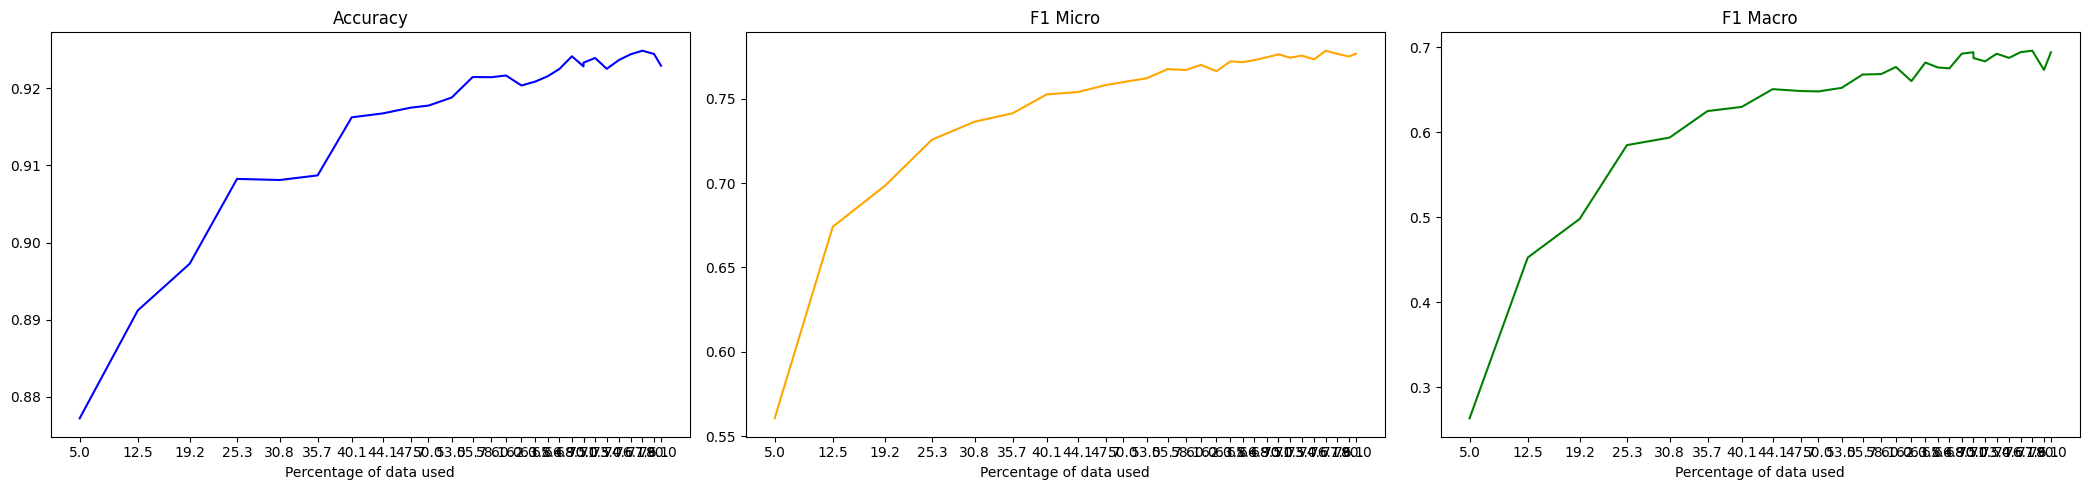

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5809, Accuracy: 0.8245, F1 Micro: 0.3956, F1 Macro: 0.1034
Epoch 2/10, Train Loss: 0.4658, Accuracy: 0.8348, F1 Micro: 0.2636, F1 Macro: 0.0592
Epoch 3/10, Train Loss: 0.397, Accuracy: 0.8338, F1 Micro: 0.0955, F1 Macro: 0.0378
Epoch 4/10, Train Loss: 0.3979, Accuracy: 0.8362, F1 Micro: 0.14, F1 Macro: 0.0465
Epoch 5/10, Train Loss: 0.383, Accuracy: 0.8437, F1 Micro: 0.2102, F1 Macro: 0.0769
Epoch 6/10, Train Loss: 0.3654, Accuracy: 0.8522, F1 Micro: 0.3188, F1 Macro: 0.1133
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3505, Accuracy: 0.8651, F1 Micro: 0.4503, F1 Macro: 0.1947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3265, Accuracy: 0.8738, F1 Micro: 0.5242, F1 Macro: 0.2445
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2968, Accuracy: 0.8777, F1 Micro: 0.5603, F1 Macro: 0.2621
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2615, Accuracy: 0.8778, F1 Micro: 0.5617, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6069, Accuracy: 0.818, F1 Micro: 0.3417, F1 Macro: 0.0941
Epoch 2/10, Train Loss: 0.4689, Accuracy: 0.8331, F1 Micro: 0.122, F1 Macro: 0.0467
Epoch 3/10, Train Loss: 0.3944, Accuracy: 0.8344, F1 Micro: 0.0998, F1 Macro: 0.0364
Epoch 4/10, Train Loss: 0.3974, Accuracy: 0.8374, F1 Micro: 0.1422, F1 Macro: 0.047
Epoch 5/10, Train Loss: 0.3818, Accuracy: 0.8464, F1 Micro: 0.2441, F1 Macro: 0.0839
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3661, Accuracy: 0.8562, F1 Micro: 0.35, F1 Macro: 0.1133
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3507, Accuracy: 0.865, F1 Micro: 0.4447, F1 Macro: 0.1653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.324, Accuracy: 0.8743, F1 Micro: 0.5154, F1 Macro: 0.2311
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2909, Accuracy: 0.8765, F1 Micro: 0.5649, F1 Macro: 0.2614
Epoch 10/10, Train Loss: 0.2604, Accuracy: 0.8767, F1 Micro: 0.557, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6221, Accuracy: 0.801, F1 Micro: 0.2723, F1 Macro: 0.0864
Epoch 2/10, Train Loss: 0.4752, Accuracy: 0.8292, F1 Micro: 0.0255, F1 Macro: 0.0111
Epoch 3/10, Train Loss: 0.3966, Accuracy: 0.83, F1 Micro: 0.0308, F1 Macro: 0.0133
Epoch 4/10, Train Loss: 0.4013, Accuracy: 0.8341, F1 Micro: 0.1023, F1 Macro: 0.0364
Epoch 5/10, Train Loss: 0.3872, Accuracy: 0.8389, F1 Micro: 0.1576, F1 Macro: 0.0571
Epoch 6/10, Train Loss: 0.3748, Accuracy: 0.8414, F1 Micro: 0.1864, F1 Macro: 0.0657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3672, Accuracy: 0.8496, F1 Micro: 0.2928, F1 Macro: 0.0947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3502, Accuracy: 0.8627, F1 Micro: 0.4235, F1 Macro: 0.1614
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3159, Accuracy: 0.8761, F1 Micro: 0.5531, F1 Macro: 0.2496
Epoch 10/10, Train Loss: 0.2849, Accuracy: 0.8769, F1 Micro: 0.5458, F1 Macro: 0.2515
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.517, Accuracy: 0.8358, F1 Micro: 0.2598, F1 Macro: 0.06
Epoch 2/10, Train Loss: 0.4025, Accuracy: 0.8368, F1 Micro: 0.1359, F1 Macro: 0.0509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3656, Accuracy: 0.859, F1 Micro: 0.4069, F1 Macro: 0.1484
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3425, Accuracy: 0.878, F1 Micro: 0.562, F1 Macro: 0.2622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3036, Accuracy: 0.8815, F1 Micro: 0.5832, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2824, Accuracy: 0.8848, F1 Micro: 0.6496, F1 Macro: 0.3465
Epoch 7/10, Train Loss: 0.2537, Accuracy: 0.886, F1 Micro: 0.5916, F1 Macro: 0.3106
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2258, Accuracy: 0.8904, F1 Micro: 0.6655, F1 Macro: 0.4031
Epoch 9/10, Train Loss: 0.1968, Accuracy: 0.8938, F1 Micro: 0.6507, F1 Macro: 0.4203
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5283, Accuracy: 0.8338, F1 Micro: 0.117, F1 Macro: 0.045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4027, Accuracy: 0.84, F1 Micro: 0.1634, F1 Macro: 0.0587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3631, Accuracy: 0.86, F1 Micro: 0.4173, F1 Macro: 0.1326
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3396, Accuracy: 0.8773, F1 Micro: 0.5445, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.299, Accuracy: 0.88, F1 Micro: 0.6021, F1 Macro: 0.2839
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2787, Accuracy: 0.883, F1 Micro: 0.646, F1 Macro: 0.3313
Epoch 7/10, Train Loss: 0.2582, Accuracy: 0.8877, F1 Micro: 0.6104, F1 Macro: 0.3111
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2236, Accuracy: 0.8861, F1 Micro: 0.6661, F1 Macro: 0.411
Epoch 9/10, Train Loss: 0.2004, Accuracy: 0.8872, F1 Micro: 0.594, F1 Macro: 0.3821
Higher F1 achieved,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5355, Accuracy: 0.8287, F1 Micro: 0.0174, F1 Macro: 0.0077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4041, Accuracy: 0.8353, F1 Micro: 0.1009, F1 Macro: 0.0385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3699, Accuracy: 0.8506, F1 Micro: 0.3105, F1 Macro: 0.1
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3527, Accuracy: 0.8724, F1 Micro: 0.5192, F1 Macro: 0.2321
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3125, Accuracy: 0.8803, F1 Micro: 0.5679, F1 Macro: 0.2634
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2892, Accuracy: 0.8804, F1 Micro: 0.6486, F1 Macro: 0.3702
Epoch 7/10, Train Loss: 0.2619, Accuracy: 0.8823, F1 Micro: 0.5516, F1 Macro: 0.2925
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2335, Accuracy: 0.8938, F1 Micro: 0.665, F1 Macro: 0.424
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2022, Accuracy: 0.8956, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.478, Accuracy: 0.8373, F1 Micro: 0.1472, F1 Macro: 0.0556
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3795, Accuracy: 0.8581, F1 Micro: 0.4004, F1 Macro: 0.1391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.334, Accuracy: 0.8801, F1 Micro: 0.5671, F1 Macro: 0.2639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2977, Accuracy: 0.8875, F1 Micro: 0.6259, F1 Macro: 0.3269
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.25, Accuracy: 0.892, F1 Micro: 0.6629, F1 Macro: 0.4091
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.232, Accuracy: 0.8954, F1 Micro: 0.6851, F1 Macro: 0.4759
Epoch 7/10, Train Loss: 0.2046, Accuracy: 0.8996, F1 Micro: 0.6821, F1 Macro: 0.486
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1822, Accuracy: 0.9025, F1 Micro: 0.6988, F1 Macro: 0.4831
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1576, Accuracy: 0.9037, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4869, Accuracy: 0.8361, F1 Micro: 0.1184, F1 Macro: 0.0449
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3794, Accuracy: 0.8591, F1 Micro: 0.3959, F1 Macro: 0.1283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3284, Accuracy: 0.8784, F1 Micro: 0.5538, F1 Macro: 0.2564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2909, Accuracy: 0.8852, F1 Micro: 0.642, F1 Macro: 0.3342
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2499, Accuracy: 0.8925, F1 Micro: 0.6554, F1 Macro: 0.3777
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2333, Accuracy: 0.8949, F1 Micro: 0.6863, F1 Macro: 0.4759
Epoch 7/10, Train Loss: 0.205, Accuracy: 0.8972, F1 Micro: 0.6804, F1 Macro: 0.4841
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1832, Accuracy: 0.9027, F1 Micro: 0.6906, F1 Macro: 0.4921
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.163, Accuracy: 0.9027, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4929, Accuracy: 0.8306, F1 Micro: 0.0367, F1 Macro: 0.0156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3861, Accuracy: 0.8535, F1 Micro: 0.3506, F1 Macro: 0.1104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3468, Accuracy: 0.8753, F1 Micro: 0.5078, F1 Macro: 0.2278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3044, Accuracy: 0.8846, F1 Micro: 0.6218, F1 Macro: 0.3262
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.254, Accuracy: 0.8944, F1 Micro: 0.6608, F1 Macro: 0.4223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2341, Accuracy: 0.8961, F1 Micro: 0.6984, F1 Macro: 0.5076
Epoch 7/10, Train Loss: 0.2058, Accuracy: 0.8991, F1 Micro: 0.6888, F1 Macro: 0.4993
Epoch 8/10, Train Loss: 0.1814, Accuracy: 0.9032, F1 Micro: 0.6889, F1 Macro: 0.4623
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1594, Accuracy: 0.9034, F1 Micro: 0.71, F1 Macro: 0.5193
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4593, Accuracy: 0.8371, F1 Micro: 0.1389, F1 Macro: 0.0495
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3541, Accuracy: 0.88, F1 Micro: 0.5824, F1 Macro: 0.2714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2987, Accuracy: 0.8894, F1 Micro: 0.6495, F1 Macro: 0.343
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2559, Accuracy: 0.8983, F1 Micro: 0.6698, F1 Macro: 0.4291
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2217, Accuracy: 0.9027, F1 Micro: 0.6902, F1 Macro: 0.4558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.192, Accuracy: 0.9049, F1 Micro: 0.7038, F1 Macro: 0.5377
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1654, Accuracy: 0.9083, F1 Micro: 0.712, F1 Macro: 0.5438
Epoch 8/10, Train Loss: 0.1416, Accuracy: 0.907, F1 Micro: 0.7109, F1 Macro: 0.5459
Epoch 9/10, Train Loss: 0.116, Accuracy: 0.9081, F1 Micro: 0.7118, F1 Macro: 0.5534
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4665, Accuracy: 0.8404, F1 Micro: 0.1777, F1 Macro: 0.0615
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.352, Accuracy: 0.8773, F1 Micro: 0.5792, F1 Macro: 0.2641
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2965, Accuracy: 0.8871, F1 Micro: 0.6417, F1 Macro: 0.3331
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2588, Accuracy: 0.896, F1 Micro: 0.6546, F1 Macro: 0.4101
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2255, Accuracy: 0.9018, F1 Micro: 0.6863, F1 Macro: 0.4635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1964, Accuracy: 0.9056, F1 Micro: 0.7063, F1 Macro: 0.5215
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1676, Accuracy: 0.9072, F1 Micro: 0.7132, F1 Macro: 0.5457
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1462, Accuracy: 0.9038, F1 Micro: 0.7202, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4729, Accuracy: 0.8343, F1 Micro: 0.0958, F1 Macro: 0.0351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3637, Accuracy: 0.8737, F1 Micro: 0.5348, F1 Macro: 0.2374
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3078, Accuracy: 0.8861, F1 Micro: 0.6469, F1 Macro: 0.3636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2616, Accuracy: 0.8976, F1 Micro: 0.6631, F1 Macro: 0.4223
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2239, Accuracy: 0.9023, F1 Micro: 0.6923, F1 Macro: 0.4534
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1976, Accuracy: 0.9051, F1 Micro: 0.7104, F1 Macro: 0.5246
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1661, Accuracy: 0.9064, F1 Micro: 0.7262, F1 Macro: 0.5562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1449, Accuracy: 0.9069, F1 Micro: 0.7271, F1 Macro: 0.5625
Epoch 9/10, Train Loss: 0.1167, Accuracy: 0.9074, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4485, Accuracy: 0.8499, F1 Micro: 0.3059, F1 Macro: 0.102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3442, Accuracy: 0.8815, F1 Micro: 0.564, F1 Macro: 0.2721
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2811, Accuracy: 0.891, F1 Micro: 0.6222, F1 Macro: 0.3414
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2436, Accuracy: 0.9019, F1 Micro: 0.6775, F1 Macro: 0.4227
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2073, Accuracy: 0.9065, F1 Micro: 0.7038, F1 Macro: 0.4885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.18, Accuracy: 0.9081, F1 Micro: 0.7205, F1 Macro: 0.5151
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1538, Accuracy: 0.9086, F1 Micro: 0.7345, F1 Macro: 0.5684
Epoch 8/10, Train Loss: 0.1289, Accuracy: 0.9092, F1 Micro: 0.7312, F1 Macro: 0.5739
Epoch 9/10, Train Loss: 0.1113, Accuracy: 0.9086, F1 Micro: 0.728, F1 Macro: 0.5707
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4542, Accuracy: 0.8556, F1 Micro: 0.3509, F1 Macro: 0.1119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3416, Accuracy: 0.882, F1 Micro: 0.5819, F1 Macro: 0.284
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2785, Accuracy: 0.8901, F1 Micro: 0.6167, F1 Macro: 0.338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2448, Accuracy: 0.9009, F1 Micro: 0.6699, F1 Macro: 0.4097
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2098, Accuracy: 0.9043, F1 Micro: 0.712, F1 Macro: 0.51
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1865, Accuracy: 0.9061, F1 Micro: 0.7208, F1 Macro: 0.5142
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1583, Accuracy: 0.9061, F1 Micro: 0.7257, F1 Macro: 0.5701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1329, Accuracy: 0.9109, F1 Micro: 0.7327, F1 Macro: 0.5812
Epoch 9/10, Train Loss: 0.1158, Accuracy: 0.9048, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4588, Accuracy: 0.8491, F1 Micro: 0.2964, F1 Macro: 0.098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.354, Accuracy: 0.8808, F1 Micro: 0.5777, F1 Macro: 0.2743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2858, Accuracy: 0.8941, F1 Micro: 0.6398, F1 Macro: 0.3822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2446, Accuracy: 0.9026, F1 Micro: 0.6822, F1 Macro: 0.4108
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2068, Accuracy: 0.9074, F1 Micro: 0.6967, F1 Macro: 0.4928
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1797, Accuracy: 0.9092, F1 Micro: 0.7306, F1 Macro: 0.5449
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1549, Accuracy: 0.9034, F1 Micro: 0.7343, F1 Macro: 0.5811
Epoch 8/10, Train Loss: 0.1303, Accuracy: 0.9108, F1 Micro: 0.7338, F1 Macro: 0.583
Epoch 9/10, Train Loss: 0.1099, Accuracy: 0.9125, F1 Micro: 0.7275, F1 Macro: 0.5779
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4395, Accuracy: 0.8547, F1 Micro: 0.3755, F1 Macro: 0.1237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.329, Accuracy: 0.8867, F1 Micro: 0.6146, F1 Macro: 0.3175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2737, Accuracy: 0.8983, F1 Micro: 0.6819, F1 Macro: 0.4176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.235, Accuracy: 0.9036, F1 Micro: 0.7012, F1 Macro: 0.4845
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2016, Accuracy: 0.9095, F1 Micro: 0.7212, F1 Macro: 0.5353
Epoch 6/10, Train Loss: 0.1725, Accuracy: 0.9106, F1 Micro: 0.7139, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1498, Accuracy: 0.9118, F1 Micro: 0.7256, F1 Macro: 0.5644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1232, Accuracy: 0.9088, F1 Micro: 0.741, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.107, Accuracy: 0.9133, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4424, Accuracy: 0.8577, F1 Micro: 0.4077, F1 Macro: 0.1224
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3264, Accuracy: 0.8868, F1 Micro: 0.6044, F1 Macro: 0.2983
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.275, Accuracy: 0.8966, F1 Micro: 0.6848, F1 Macro: 0.4179
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2366, Accuracy: 0.902, F1 Micro: 0.7, F1 Macro: 0.4852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2029, Accuracy: 0.9066, F1 Micro: 0.7088, F1 Macro: 0.5189
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.176, Accuracy: 0.9094, F1 Micro: 0.7123, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1506, Accuracy: 0.9135, F1 Micro: 0.7322, F1 Macro: 0.5709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1217, Accuracy: 0.9119, F1 Micro: 0.7359, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1072

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4476, Accuracy: 0.8508, F1 Micro: 0.3168, F1 Macro: 0.1026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3364, Accuracy: 0.8844, F1 Micro: 0.5948, F1 Macro: 0.298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2763, Accuracy: 0.8995, F1 Micro: 0.6839, F1 Macro: 0.4439
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2335, Accuracy: 0.9045, F1 Micro: 0.7115, F1 Macro: 0.4946
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.203, Accuracy: 0.9097, F1 Micro: 0.7253, F1 Macro: 0.5386
Epoch 6/10, Train Loss: 0.1733, Accuracy: 0.9094, F1 Micro: 0.7023, F1 Macro: 0.5395
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1485, Accuracy: 0.9134, F1 Micro: 0.7367, F1 Macro: 0.58
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1192, Accuracy: 0.913, F1 Micro: 0.7465, F1 Macro: 0.6117
Epoch 9/10, Train Loss: 0.1028, Accuracy: 0.9102, F1 Micro: 0.7464, F1 Macro: 0.6223
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4286, Accuracy: 0.8646, F1 Micro: 0.4642, F1 Macro: 0.1872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3116, Accuracy: 0.8898, F1 Micro: 0.6182, F1 Macro: 0.3217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2564, Accuracy: 0.906, F1 Micro: 0.6991, F1 Macro: 0.5007
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2175, Accuracy: 0.9085, F1 Micro: 0.7137, F1 Macro: 0.553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1866, Accuracy: 0.9084, F1 Micro: 0.7405, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1581, Accuracy: 0.9145, F1 Micro: 0.7493, F1 Macro: 0.6013
Epoch 7/10, Train Loss: 0.1367, Accuracy: 0.9152, F1 Micro: 0.7459, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1133, Accuracy: 0.9146, F1 Micro: 0.7531, F1 Macro: 0.6149
Epoch 9/10, Train Loss: 0.0995, Accuracy: 0.9156, F1 Micro: 0.7521, F1 Macro: 0.6194
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4313, Accuracy: 0.8634, F1 Micro: 0.4357, F1 Macro: 0.1538
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3091, Accuracy: 0.8884, F1 Micro: 0.6238, F1 Macro: 0.316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2588, Accuracy: 0.9033, F1 Micro: 0.6966, F1 Macro: 0.4838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2195, Accuracy: 0.9082, F1 Micro: 0.7117, F1 Macro: 0.5387
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1909, Accuracy: 0.9029, F1 Micro: 0.731, F1 Macro: 0.5753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1648, Accuracy: 0.9098, F1 Micro: 0.7452, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1392, Accuracy: 0.9143, F1 Micro: 0.7491, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1153, Accuracy: 0.9165, F1 Micro: 0.7527, F1 Macro: 0.6182
Epoch 9/10, Train Loss: 0.1027, Accuracy: 0.914, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4383, Accuracy: 0.8541, F1 Micro: 0.3569, F1 Macro: 0.1133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3209, Accuracy: 0.888, F1 Micro: 0.6059, F1 Macro: 0.3209
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2614, Accuracy: 0.9056, F1 Micro: 0.6971, F1 Macro: 0.5016
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2211, Accuracy: 0.9101, F1 Micro: 0.715, F1 Macro: 0.5443
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1888, Accuracy: 0.9079, F1 Micro: 0.7401, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.16, Accuracy: 0.9107, F1 Micro: 0.75, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1369, Accuracy: 0.9166, F1 Micro: 0.7592, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1137, Accuracy: 0.9176, F1 Micro: 0.7611, F1 Macro: 0.6332
Epoch 9/10, Train Loss: 0.0968, Accuracy: 0.9152, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4244, Accuracy: 0.8684, F1 Micro: 0.4808, F1 Macro: 0.2119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3121, Accuracy: 0.8944, F1 Micro: 0.6525, F1 Macro: 0.3543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2514, Accuracy: 0.905, F1 Micro: 0.7156, F1 Macro: 0.5274
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2102, Accuracy: 0.9096, F1 Micro: 0.7178, F1 Macro: 0.5278
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1808, Accuracy: 0.9143, F1 Micro: 0.7368, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1574, Accuracy: 0.9174, F1 Micro: 0.7521, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.9164, F1 Micro: 0.7541, F1 Macro: 0.6089
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1113, Accuracy: 0.9178, F1 Micro: 0.7634, F1 Macro: 0.6422
Epoch 9/10, Train Loss: 0.0952, Accuracy: 0.9191, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4282, Accuracy: 0.8704, F1 Micro: 0.4887, F1 Macro: 0.2023
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3115, Accuracy: 0.8917, F1 Micro: 0.6362, F1 Macro: 0.3349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2527, Accuracy: 0.9023, F1 Micro: 0.7122, F1 Macro: 0.5132
Epoch 4/10, Train Loss: 0.2115, Accuracy: 0.9075, F1 Micro: 0.7022, F1 Macro: 0.5046
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1855, Accuracy: 0.9134, F1 Micro: 0.7325, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1589, Accuracy: 0.918, F1 Micro: 0.7489, F1 Macro: 0.5921
Epoch 7/10, Train Loss: 0.1347, Accuracy: 0.9146, F1 Micro: 0.7475, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1132, Accuracy: 0.9161, F1 Micro: 0.7566, F1 Macro: 0.649
Epoch 9/10, Train Loss: 0.0978, Accuracy: 0.9149, F1 Micro: 0.7546, F1 Macro: 0.6457
Epoch 10/10, Train Loss: 0.0843, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4351, Accuracy: 0.8575, F1 Micro: 0.4093, F1 Macro: 0.1385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3211, Accuracy: 0.8912, F1 Micro: 0.6466, F1 Macro: 0.3765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2551, Accuracy: 0.9061, F1 Micro: 0.7128, F1 Macro: 0.5183
Epoch 4/10, Train Loss: 0.2115, Accuracy: 0.9094, F1 Micro: 0.7048, F1 Macro: 0.5027
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1795, Accuracy: 0.9141, F1 Micro: 0.736, F1 Macro: 0.5624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1568, Accuracy: 0.9172, F1 Micro: 0.7543, F1 Macro: 0.6076
Epoch 7/10, Train Loss: 0.1298, Accuracy: 0.9178, F1 Micro: 0.7491, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1107, Accuracy: 0.9143, F1 Micro: 0.7569, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0962, Accuracy: 0.9191, F1 Micro: 0.7652, F1 Macro: 0.6518
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4137, Accuracy: 0.876, F1 Micro: 0.5581, F1 Macro: 0.2574
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2965, Accuracy: 0.8961, F1 Micro: 0.6763, F1 Macro: 0.4282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2413, Accuracy: 0.9074, F1 Micro: 0.7134, F1 Macro: 0.5058
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2038, Accuracy: 0.9054, F1 Micro: 0.7366, F1 Macro: 0.5699
Epoch 5/10, Train Loss: 0.1733, Accuracy: 0.9143, F1 Micro: 0.729, F1 Macro: 0.5617
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9155, F1 Micro: 0.753, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1322, Accuracy: 0.916, F1 Micro: 0.7593, F1 Macro: 0.6279
Epoch 8/10, Train Loss: 0.1134, Accuracy: 0.9188, F1 Micro: 0.7586, F1 Macro: 0.6387
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0917, Accuracy: 0.9195, F1 Micro: 0.7623, F1 Macro: 0.656
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.416, Accuracy: 0.8748, F1 Micro: 0.5237, F1 Macro: 0.226
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2959, Accuracy: 0.8945, F1 Micro: 0.6821, F1 Macro: 0.4515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2427, Accuracy: 0.9053, F1 Micro: 0.7057, F1 Macro: 0.5029
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2064, Accuracy: 0.911, F1 Micro: 0.7386, F1 Macro: 0.5677
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9125, F1 Micro: 0.7366, F1 Macro: 0.5708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1522, Accuracy: 0.9171, F1 Micro: 0.7545, F1 Macro: 0.6122
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1341, Accuracy: 0.9186, F1 Micro: 0.7591, F1 Macro: 0.6308
Epoch 8/10, Train Loss: 0.1132, Accuracy: 0.9195, F1 Micro: 0.7569, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0971, Accuracy: 0.9176, F1 Micro: 0.7599, F1 Macro: 0.6578
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4243, Accuracy: 0.8664, F1 Micro: 0.4811, F1 Macro: 0.1921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.303, Accuracy: 0.8962, F1 Micro: 0.6837, F1 Macro: 0.4617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.244, Accuracy: 0.9076, F1 Micro: 0.7145, F1 Macro: 0.5033
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2053, Accuracy: 0.9087, F1 Micro: 0.7425, F1 Macro: 0.5847
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9163, F1 Micro: 0.7388, F1 Macro: 0.5788
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1472, Accuracy: 0.9185, F1 Micro: 0.751, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1311, Accuracy: 0.9156, F1 Micro: 0.7634, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1118, Accuracy: 0.9192, F1 Micro: 0.7663, F1 Macro: 0.6617
Epoch 9/10, Train Loss: 0.091, Accuracy: 0.9211, F1 Micro: 0.7631, F1 Macro: 0.6576
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.414, Accuracy: 0.8717, F1 Micro: 0.6028, F1 Macro: 0.2786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2963, Accuracy: 0.8988, F1 Micro: 0.6625, F1 Macro: 0.4064
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2407, Accuracy: 0.9088, F1 Micro: 0.7097, F1 Macro: 0.5182
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2078, Accuracy: 0.9132, F1 Micro: 0.7465, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1721, Accuracy: 0.915, F1 Micro: 0.7473, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1458, Accuracy: 0.9144, F1 Micro: 0.7608, F1 Macro: 0.6226
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9161, F1 Micro: 0.7525, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1074, Accuracy: 0.9153, F1 Micro: 0.7618, F1 Macro: 0.646
Epoch 9/10, Train Loss: 0.088, Accuracy: 0.9177, F1 Micro: 0.7616, F1 Macro: 0.6369
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4154, Accuracy: 0.8705, F1 Micro: 0.6034, F1 Macro: 0.2753
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2941, Accuracy: 0.8977, F1 Micro: 0.6599, F1 Macro: 0.4062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2415, Accuracy: 0.908, F1 Micro: 0.6984, F1 Macro: 0.5048
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2113, Accuracy: 0.9135, F1 Micro: 0.7361, F1 Macro: 0.5726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9112, F1 Micro: 0.7456, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1476, Accuracy: 0.9161, F1 Micro: 0.7546, F1 Macro: 0.6223
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.123, Accuracy: 0.9163, F1 Micro: 0.7553, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1095, Accuracy: 0.9138, F1 Micro: 0.7564, F1 Macro: 0.6303
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0.9134, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4252, Accuracy: 0.8659, F1 Micro: 0.5318, F1 Macro: 0.2283
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3014, Accuracy: 0.8983, F1 Micro: 0.6663, F1 Macro: 0.4249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2415, Accuracy: 0.9102, F1 Micro: 0.7193, F1 Macro: 0.5307
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2083, Accuracy: 0.9151, F1 Micro: 0.7503, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1721, Accuracy: 0.914, F1 Micro: 0.7552, F1 Macro: 0.5975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1445, Accuracy: 0.9209, F1 Micro: 0.7646, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.119, Accuracy: 0.9216, F1 Micro: 0.7703, F1 Macro: 0.6586
Epoch 8/10, Train Loss: 0.105, Accuracy: 0.9178, F1 Micro: 0.7654, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9192, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4097, Accuracy: 0.8789, F1 Micro: 0.5821, F1 Macro: 0.2721
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2883, Accuracy: 0.8992, F1 Micro: 0.6887, F1 Macro: 0.4834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2342, Accuracy: 0.9078, F1 Micro: 0.712, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9111, F1 Micro: 0.7195, F1 Macro: 0.5285
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1715, Accuracy: 0.9153, F1 Micro: 0.7504, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1454, Accuracy: 0.9171, F1 Micro: 0.7532, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1269, Accuracy: 0.919, F1 Micro: 0.7565, F1 Macro: 0.6371
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1051, Accuracy: 0.9191, F1 Micro: 0.762, F1 Macro: 0.6489
Epoch 9/10, Train Loss: 0.0873, Accuracy: 0.9171, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4108, Accuracy: 0.8774, F1 Micro: 0.5776, F1 Macro: 0.267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2874, Accuracy: 0.8993, F1 Micro: 0.6903, F1 Macro: 0.479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2345, Accuracy: 0.9085, F1 Micro: 0.7175, F1 Macro: 0.5116
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.9119, F1 Micro: 0.7269, F1 Macro: 0.5467
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1734, Accuracy: 0.9142, F1 Micro: 0.7482, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1477, Accuracy: 0.9158, F1 Micro: 0.7555, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1285, Accuracy: 0.9213, F1 Micro: 0.7631, F1 Macro: 0.6468
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.9204, F1 Micro: 0.7621, F1 Macro: 0.65
Epoch 9/10, Train Loss: 0.0908, Accuracy: 0.9182, F1 Micro: 0.7517, F1 Macro: 0.628
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4191, Accuracy: 0.8745, F1 Micro: 0.5482, F1 Macro: 0.246
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2908, Accuracy: 0.8998, F1 Micro: 0.6947, F1 Macro: 0.4971
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2375, Accuracy: 0.9098, F1 Micro: 0.7225, F1 Macro: 0.518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2001, Accuracy: 0.9138, F1 Micro: 0.7271, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.9123, F1 Micro: 0.7536, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1441, Accuracy: 0.9172, F1 Micro: 0.7629, F1 Macro: 0.6282
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9188, F1 Micro: 0.7634, F1 Macro: 0.6443
Epoch 8/10, Train Loss: 0.1044, Accuracy: 0.9222, F1 Micro: 0.7617, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0872, Accuracy: 0.9217, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4064, Accuracy: 0.8807, F1 Micro: 0.5985, F1 Macro: 0.2789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2877, Accuracy: 0.9012, F1 Micro: 0.6842, F1 Macro: 0.4852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2396, Accuracy: 0.9067, F1 Micro: 0.7283, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1983, Accuracy: 0.9146, F1 Micro: 0.7337, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.169, Accuracy: 0.9188, F1 Micro: 0.7573, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1421, Accuracy: 0.9168, F1 Micro: 0.763, F1 Macro: 0.6309
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1224, Accuracy: 0.9181, F1 Micro: 0.7655, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1027, Accuracy: 0.9198, F1 Micro: 0.7703, F1 Macro: 0.6692
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.92, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4092, Accuracy: 0.8783, F1 Micro: 0.5947, F1 Macro: 0.2752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2853, Accuracy: 0.8983, F1 Micro: 0.6707, F1 Macro: 0.4796
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2369, Accuracy: 0.9102, F1 Micro: 0.7256, F1 Macro: 0.5583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9139, F1 Micro: 0.7267, F1 Macro: 0.5565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.9191, F1 Micro: 0.7556, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1431, Accuracy: 0.9174, F1 Micro: 0.76, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1244, Accuracy: 0.9154, F1 Micro: 0.7619, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1046, Accuracy: 0.9218, F1 Micro: 0.7674, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4153, Accuracy: 0.8754, F1 Micro: 0.5861, F1 Macro: 0.2685
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2912, Accuracy: 0.9, F1 Micro: 0.6899, F1 Macro: 0.5002
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2389, Accuracy: 0.9108, F1 Micro: 0.7263, F1 Macro: 0.5503
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.915, F1 Micro: 0.7332, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1704, Accuracy: 0.9194, F1 Micro: 0.7616, F1 Macro: 0.6078
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.138, Accuracy: 0.9187, F1 Micro: 0.7648, F1 Macro: 0.6387
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1221, Accuracy: 0.9214, F1 Micro: 0.7716, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.9231, F1 Micro: 0.7749, F1 Macro: 0.6761
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9206, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.8801, F1 Micro: 0.6, F1 Macro: 0.2811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.8994, F1 Micro: 0.6991, F1 Macro: 0.4752
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.9096, F1 Micro: 0.7318, F1 Macro: 0.5598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1952, Accuracy: 0.9165, F1 Micro: 0.7413, F1 Macro: 0.5903
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9111, F1 Micro: 0.755, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9226, F1 Micro: 0.7674, F1 Macro: 0.6342
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1191, Accuracy: 0.9171, F1 Micro: 0.7678, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9217, F1 Micro: 0.7702, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4044, Accuracy: 0.8786, F1 Micro: 0.5906, F1 Macro: 0.2739
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2792, Accuracy: 0.8982, F1 Micro: 0.6978, F1 Macro: 0.4789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2333, Accuracy: 0.9081, F1 Micro: 0.7302, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1977, Accuracy: 0.9163, F1 Micro: 0.7449, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9126, F1 Micro: 0.7523, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.9206, F1 Micro: 0.7651, F1 Macro: 0.647
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.9169, F1 Micro: 0.7612, F1 Macro: 0.6636
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.921, F1 Micro: 0.7637, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.922, F1 Micro: 0.7708, F1 Macro: 0.6783
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4126, Accuracy: 0.8768, F1 Micro: 0.5717, F1 Macro: 0.2625
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2833, Accuracy: 0.9007, F1 Micro: 0.7077, F1 Macro: 0.4992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2313, Accuracy: 0.9099, F1 Micro: 0.7379, F1 Macro: 0.5733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1953, Accuracy: 0.9185, F1 Micro: 0.7496, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.915, F1 Micro: 0.7589, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9206, F1 Micro: 0.7628, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9219, F1 Micro: 0.7686, F1 Macro: 0.6642
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9227, F1 Micro: 0.7643, F1 Macro: 0.6666
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9213, F1 Micro: 0.7649, F1 Macro: 0.6738
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.398, Accuracy: 0.883, F1 Micro: 0.6046, F1 Macro: 0.2911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2729, Accuracy: 0.9011, F1 Micro: 0.7026, F1 Macro: 0.4699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2254, Accuracy: 0.9124, F1 Micro: 0.7305, F1 Macro: 0.5563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1909, Accuracy: 0.9179, F1 Micro: 0.7484, F1 Macro: 0.5961
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.9158, F1 Micro: 0.7581, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.9219, F1 Micro: 0.7628, F1 Macro: 0.6363
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9219, F1 Micro: 0.7612, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9227, F1 Micro: 0.773, F1 Macro: 0.6679
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9222, F1 Micro: 0.7659, F1 Macro: 0.6652
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3993, Accuracy: 0.8818, F1 Micro: 0.5993, F1 Macro: 0.2801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.8996, F1 Micro: 0.7027, F1 Macro: 0.4793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.228, Accuracy: 0.9102, F1 Micro: 0.7335, F1 Macro: 0.5534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1922, Accuracy: 0.9194, F1 Micro: 0.7481, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.9143, F1 Micro: 0.7583, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9214, F1 Micro: 0.7669, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9215, F1 Micro: 0.7706, F1 Macro: 0.6559
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9232, F1 Micro: 0.7676, F1 Macro: 0.6766
Epoch 9/10, Train Loss: 0.0841, Accuracy: 0.922, F1 Micro: 0.7669, F1 Macro: 0.6783
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.409, Accuracy: 0.8788, F1 Micro: 0.5618, F1 Macro: 0.2577
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.901, F1 Micro: 0.7043, F1 Macro: 0.4586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2283, Accuracy: 0.913, F1 Micro: 0.7378, F1 Macro: 0.5743
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.192, Accuracy: 0.9177, F1 Micro: 0.7462, F1 Macro: 0.6005
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9158, F1 Micro: 0.7557, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.9216, F1 Micro: 0.767, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9226, F1 Micro: 0.7706, F1 Macro: 0.6594
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9204, F1 Micro: 0.764, F1 Macro: 0.6717
Epoch 9/10, Train Loss: 0.084, Accuracy: 0.9219, F1 Micro: 0.7649, F1 Macro: 0.6588
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3932, Accuracy: 0.883, F1 Micro: 0.5986, F1 Macro: 0.2841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2766, Accuracy: 0.8961, F1 Micro: 0.6207, F1 Macro: 0.4025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.227, Accuracy: 0.912, F1 Micro: 0.7355, F1 Macro: 0.5676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.9149, F1 Micro: 0.748, F1 Macro: 0.5975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.92, F1 Micro: 0.7662, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9204, F1 Micro: 0.7681, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9218, F1 Micro: 0.7707, F1 Macro: 0.6722
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9191, F1 Micro: 0.7701, F1 Macro: 0.6738
Epoch 9/10, Train Loss: 0.086, Accuracy: 0.921, F1 Micro: 0.7702, F1 Macro: 0.6766
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8822, F1 Micro: 0.5836, F1 Macro: 0.2785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2783, Accuracy: 0.8983, F1 Micro: 0.6343, F1 Macro: 0.4193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2266, Accuracy: 0.9118, F1 Micro: 0.725, F1 Macro: 0.5507
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1984, Accuracy: 0.9135, F1 Micro: 0.7451, F1 Macro: 0.599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9217, F1 Micro: 0.7623, F1 Macro: 0.6276
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9181, F1 Micro: 0.7679, F1 Macro: 0.6574
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.9216, F1 Micro: 0.7692, F1 Macro: 0.6706
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9223, F1 Micro: 0.7614, F1 Macro: 0.6617
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9203, F1 Micro: 0.7617, F1 Macro: 0.6667
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4037, Accuracy: 0.881, F1 Micro: 0.5911, F1 Macro: 0.2789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2794, Accuracy: 0.9006, F1 Micro: 0.6513, F1 Macro: 0.4378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.9129, F1 Micro: 0.7199, F1 Macro: 0.5496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.196, Accuracy: 0.9157, F1 Micro: 0.7519, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.92, F1 Micro: 0.7676, F1 Macro: 0.6258
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.9204, F1 Micro: 0.7653, F1 Macro: 0.6503
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9197, F1 Micro: 0.7696, F1 Macro: 0.6764
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.9206, F1 Micro: 0.7644, F1 Macro: 0.6686
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9192, F1 Micro: 0.7659, F1 Macro: 0.6707
Epoch 10/10, Train Loss: 0.0702, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3956, Accuracy: 0.8846, F1 Micro: 0.6029, F1 Macro: 0.2863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.9025, F1 Micro: 0.7158, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9118, F1 Micro: 0.7378, F1 Macro: 0.5656
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.915, F1 Micro: 0.7375, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.9184, F1 Micro: 0.7579, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9219, F1 Micro: 0.7659, F1 Macro: 0.6252
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9227, F1 Micro: 0.7719, F1 Macro: 0.6628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9194, F1 Micro: 0.7725, F1 Macro: 0.6665
Epoch 9/10, Train Loss: 0.0835, Accuracy: 0.9213, F1 Micro: 0.7702, F1 Macro: 0.676
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3953, Accuracy: 0.881, F1 Micro: 0.624, F1 Macro: 0.2975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2708, Accuracy: 0.9018, F1 Micro: 0.7107, F1 Macro: 0.5276
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2273, Accuracy: 0.9133, F1 Micro: 0.7372, F1 Macro: 0.564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.915, F1 Micro: 0.7407, F1 Macro: 0.5915
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9176, F1 Micro: 0.7566, F1 Macro: 0.6217
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9165, F1 Micro: 0.7597, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.119, Accuracy: 0.9207, F1 Micro: 0.7668, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9222, F1 Micro: 0.7709, F1 Macro: 0.6712
Epoch 9/10, Train Loss: 0.0821, Accuracy: 0.9209, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4039, Accuracy: 0.8807, F1 Micro: 0.5933, F1 Macro: 0.2779
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2728, Accuracy: 0.9037, F1 Micro: 0.7159, F1 Macro: 0.5426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.9134, F1 Micro: 0.7351, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.919, F1 Micro: 0.7503, F1 Macro: 0.5998
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9187, F1 Micro: 0.7627, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.9195, F1 Micro: 0.7672, F1 Macro: 0.6468
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9219, F1 Micro: 0.7737, F1 Macro: 0.6656
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9207, F1 Micro: 0.7721, F1 Macro: 0.6745
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9231, F1 Micro: 0.7681, F1 Macro: 0.6832
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3891, Accuracy: 0.8854, F1 Micro: 0.5934, F1 Macro: 0.2909
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2714, Accuracy: 0.9059, F1 Micro: 0.6948, F1 Macro: 0.4969
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.9115, F1 Micro: 0.7429, F1 Macro: 0.5884
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1858, Accuracy: 0.9187, F1 Micro: 0.758, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.917, F1 Micro: 0.7628, F1 Macro: 0.6171
Epoch 6/10, Train Loss: 0.135, Accuracy: 0.9223, F1 Micro: 0.7555, F1 Macro: 0.6295
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.9242, F1 Micro: 0.7708, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9248, F1 Micro: 0.7793, F1 Macro: 0.6844
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.9241, F1 Micro: 0.7698, F1 Macro: 0.67
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3925, Accuracy: 0.8836, F1 Micro: 0.5851, F1 Macro: 0.2824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.905, F1 Micro: 0.695, F1 Macro: 0.4982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.912, F1 Micro: 0.7399, F1 Macro: 0.5835
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9177, F1 Micro: 0.7542, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9202, F1 Micro: 0.7678, F1 Macro: 0.6536
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9219, F1 Micro: 0.7633, F1 Macro: 0.64
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9214, F1 Micro: 0.7551, F1 Macro: 0.6393
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0961, Accuracy: 0.9222, F1 Micro: 0.7684, F1 Macro: 0.6717
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9227, F1 Micro: 0.772, F1 Macro: 0.6788
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4007, Accuracy: 0.8812, F1 Micro: 0.5926, F1 Macro: 0.2935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2745, Accuracy: 0.9055, F1 Micro: 0.6901, F1 Macro: 0.4832
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.9124, F1 Micro: 0.7449, F1 Macro: 0.5937
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9176, F1 Micro: 0.7577, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.919, F1 Micro: 0.7639, F1 Macro: 0.632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9219, F1 Micro: 0.7691, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9246, F1 Micro: 0.7718, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9244, F1 Micro: 0.7802, F1 Macro: 0.6855
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.924, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8843, F1 Micro: 0.6309, F1 Macro: 0.3152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2669, Accuracy: 0.9051, F1 Micro: 0.7154, F1 Macro: 0.5132
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9113, F1 Micro: 0.7069, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1894, Accuracy: 0.9194, F1 Micro: 0.7489, F1 Macro: 0.585
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1536, Accuracy: 0.9204, F1 Micro: 0.7613, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9222, F1 Micro: 0.7722, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9235, F1 Micro: 0.7751, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9241, F1 Micro: 0.779, F1 Macro: 0.6828
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9244, F1 Micro: 0.7736, F1 Macro: 0.6809
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3869, Accuracy: 0.8835, F1 Micro: 0.6049, F1 Macro: 0.2967
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.9053, F1 Micro: 0.7084, F1 Macro: 0.5006
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.9114, F1 Micro: 0.7053, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.9197, F1 Micro: 0.7476, F1 Macro: 0.5724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1552, Accuracy: 0.9191, F1 Micro: 0.7605, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1331, Accuracy: 0.9221, F1 Micro: 0.7717, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9221, F1 Micro: 0.7748, F1 Macro: 0.6787
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9245, F1 Micro: 0.778, F1 Macro: 0.6881
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.9231, F1 Micro: 0.769, F1 Macro: 0.6767
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3969, Accuracy: 0.8816, F1 Micro: 0.5942, F1 Macro: 0.2887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9055, F1 Micro: 0.7046, F1 Macro: 0.4887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2217, Accuracy: 0.9149, F1 Micro: 0.7294, F1 Macro: 0.5599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1889, Accuracy: 0.921, F1 Micro: 0.7538, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.9209, F1 Micro: 0.7669, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9218, F1 Micro: 0.7719, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9215, F1 Micro: 0.7756, F1 Macro: 0.6891
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.924, F1 Micro: 0.7776, F1 Macro: 0.6983
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3857, Accuracy: 0.8804, F1 Micro: 0.5342, F1 Macro: 0.2639
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2714, Accuracy: 0.9069, F1 Micro: 0.7074, F1 Macro: 0.5129
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9127, F1 Micro: 0.7357, F1 Macro: 0.5634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.9176, F1 Micro: 0.75, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9215, F1 Micro: 0.7664, F1 Macro: 0.6273
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1325, Accuracy: 0.9216, F1 Micro: 0.7682, F1 Macro: 0.6499
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9218, F1 Micro: 0.7673, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9211, F1 Micro: 0.7714, F1 Macro: 0.6709
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9194, F1 Micro: 0.7692, F1 Macro: 0.6817
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3886, Accuracy: 0.8793, F1 Micro: 0.534, F1 Macro: 0.2503
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2724, Accuracy: 0.9061, F1 Micro: 0.7124, F1 Macro: 0.5295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2217, Accuracy: 0.9124, F1 Micro: 0.7274, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9172, F1 Micro: 0.7495, F1 Macro: 0.5983
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.9202, F1 Micro: 0.7657, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.9212, F1 Micro: 0.766, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9202, F1 Micro: 0.7666, F1 Macro: 0.6605
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9204, F1 Micro: 0.7721, F1 Macro: 0.6706
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9188, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3966, Accuracy: 0.8781, F1 Micro: 0.5153, F1 Macro: 0.2421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2727, Accuracy: 0.9067, F1 Micro: 0.7074, F1 Macro: 0.5128
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2224, Accuracy: 0.9122, F1 Micro: 0.7276, F1 Macro: 0.5622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9185, F1 Micro: 0.758, F1 Macro: 0.6067
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9222, F1 Micro: 0.7729, F1 Macro: 0.6387
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9219, F1 Micro: 0.7696, F1 Macro: 0.6625
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9195, F1 Micro: 0.7715, F1 Macro: 0.6745
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9202, F1 Micro: 0.7694, F1 Macro: 0.6711
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9193, F1 Micro: 0.7716, F1 Macro: 0.686
Epoch 10/10, Train Loss: 0.0664, Accuracy: 0.9228, F1 Micro: 0.7708, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8829, F1 Micro: 0.6461, F1 Macro: 0.337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.9068, F1 Micro: 0.7085, F1 Macro: 0.5047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.9141, F1 Micro: 0.7358, F1 Macro: 0.5678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.185, Accuracy: 0.9171, F1 Micro: 0.7524, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.9228, F1 Micro: 0.7704, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1308, Accuracy: 0.9251, F1 Micro: 0.7729, F1 Macro: 0.648
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9258, F1 Micro: 0.7707, F1 Macro: 0.6658
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9247, F1 Micro: 0.7697, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.922, F1 Micro: 0.7769, F1 Macro: 0.6841
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3893, Accuracy: 0.8809, F1 Micro: 0.6483, F1 Macro: 0.3324
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2692, Accuracy: 0.9063, F1 Micro: 0.7037, F1 Macro: 0.4913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2207, Accuracy: 0.9114, F1 Micro: 0.7405, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1865, Accuracy: 0.9151, F1 Micro: 0.7491, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9204, F1 Micro: 0.7638, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9233, F1 Micro: 0.7658, F1 Macro: 0.644
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9228, F1 Micro: 0.7617, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9195, F1 Micro: 0.7709, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9213, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3991, Accuracy: 0.8787, F1 Micro: 0.6317, F1 Macro: 0.3174
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.9064, F1 Micro: 0.7086, F1 Macro: 0.513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2191, Accuracy: 0.9145, F1 Micro: 0.74, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1853, Accuracy: 0.9159, F1 Micro: 0.7513, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9182, F1 Micro: 0.7688, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9221, F1 Micro: 0.7715, F1 Macro: 0.6513
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.925, F1 Micro: 0.7726, F1 Macro: 0.6816
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9228, F1 Micro: 0.7723, F1 Macro: 0.6812
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9253, F1 Micro: 0.7718, F1 Macro: 0.6918
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.8867, F1 Micro: 0.6188, F1 Macro: 0.3163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2638, Accuracy: 0.9063, F1 Micro: 0.704, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.9147, F1 Micro: 0.7415, F1 Macro: 0.5609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9193, F1 Micro: 0.7534, F1 Macro: 0.5947
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9221, F1 Micro: 0.7688, F1 Macro: 0.622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1294, Accuracy: 0.9235, F1 Micro: 0.7697, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9215, F1 Micro: 0.7722, F1 Macro: 0.6387
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9239, F1 Micro: 0.7761, F1 Macro: 0.6747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.384, Accuracy: 0.8828, F1 Micro: 0.622, F1 Macro: 0.3048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2657, Accuracy: 0.9037, F1 Micro: 0.6834, F1 Macro: 0.4513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.217, Accuracy: 0.9133, F1 Micro: 0.7415, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9198, F1 Micro: 0.755, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9226, F1 Micro: 0.7625, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9249, F1 Micro: 0.7693, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9242, F1 Micro: 0.7726, F1 Macro: 0.6355
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9227, F1 Micro: 0.7696, F1 Macro: 0.6849
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.924, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3937, Accuracy: 0.8812, F1 Micro: 0.5847, F1 Macro: 0.2853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.9052, F1 Micro: 0.6924, F1 Macro: 0.4754
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9165, F1 Micro: 0.7468, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9207, F1 Micro: 0.7581, F1 Macro: 0.5997
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9244, F1 Micro: 0.7708, F1 Macro: 0.6348
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.924, F1 Micro: 0.7707, F1 Macro: 0.676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9231, F1 Micro: 0.7768, F1 Macro: 0.6683
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9222, F1 Micro: 0.7765, F1 Macro: 0.698
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9246, F1 Micro: 0.7736, F1 Macro: 0.7023
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8883, F1 Micro: 0.6351, F1 Macro: 0.3245
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2659, Accuracy: 0.9063, F1 Micro: 0.7093, F1 Macro: 0.492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9131, F1 Micro: 0.7392, F1 Macro: 0.564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9189, F1 Micro: 0.7464, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9213, F1 Micro: 0.7699, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9217, F1 Micro: 0.771, F1 Macro: 0.6442
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1095, Accuracy: 0.9215, F1 Micro: 0.773, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9215, F1 Micro: 0.7733, F1 Macro: 0.6799
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3851, Accuracy: 0.8836, F1 Micro: 0.5815, F1 Macro: 0.2822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.9056, F1 Micro: 0.7081, F1 Macro: 0.4939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.9128, F1 Micro: 0.7429, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.92, F1 Micro: 0.7584, F1 Macro: 0.6108
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9209, F1 Micro: 0.7712, F1 Macro: 0.6364
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9211, F1 Micro: 0.7705, F1 Macro: 0.6641
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9205, F1 Micro: 0.7702, F1 Macro: 0.6772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.919, F1 Micro: 0.7713, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9195, F1 Micro: 0.7725, F1 Macro: 0.69
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3939, Accuracy: 0.8832, F1 Micro: 0.6039, F1 Macro: 0.3035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.9061, F1 Micro: 0.7033, F1 Macro: 0.4815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.9155, F1 Micro: 0.7314, F1 Macro: 0.562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.92, F1 Micro: 0.7566, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.9216, F1 Micro: 0.7712, F1 Macro: 0.6478
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.9183, F1 Micro: 0.77, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9225, F1 Micro: 0.7769, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9222, F1 Micro: 0.7777, F1 Macro: 0.6963
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0.9213, F1 Micro: 0.7774, F1 Macro: 0.695
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3811, Accuracy: 0.8891, F1 Micro: 0.6402, F1 Macro: 0.3328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.9082, F1 Micro: 0.6955, F1 Macro: 0.4994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.9127, F1 Micro: 0.7469, F1 Macro: 0.5707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9197, F1 Micro: 0.7537, F1 Macro: 0.5938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9228, F1 Micro: 0.7593, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.92, F1 Micro: 0.7707, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.9204, F1 Micro: 0.7763, F1 Macro: 0.6756
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9236, F1 Micro: 0.7733, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9253, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3814, Accuracy: 0.8881, F1 Micro: 0.6341, F1 Macro: 0.3258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2586, Accuracy: 0.9082, F1 Micro: 0.6998, F1 Macro: 0.5091
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.9115, F1 Micro: 0.7467, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9208, F1 Micro: 0.7571, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.923, F1 Micro: 0.7693, F1 Macro: 0.6526
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.9217, F1 Micro: 0.7654, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.921, F1 Micro: 0.7699, F1 Macro: 0.6649
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9215, F1 Micro: 0.7677, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9202, F1 Micro: 0.7735, F1 Macro: 0.6903
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3915, Accuracy: 0.8842, F1 Micro: 0.6151, F1 Macro: 0.3217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2616, Accuracy: 0.9087, F1 Micro: 0.7083, F1 Macro: 0.5235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2176, Accuracy: 0.9179, F1 Micro: 0.7499, F1 Macro: 0.5903
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9201, F1 Micro: 0.7588, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9248, F1 Micro: 0.7749, F1 Macro: 0.6468
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.92, F1 Micro: 0.7721, F1 Macro: 0.6585
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9199, F1 Micro: 0.7754, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9243, F1 Micro: 0.7777, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9246, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3824, Accuracy: 0.8878, F1 Micro: 0.6154, F1 Macro: 0.313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2601, Accuracy: 0.9052, F1 Micro: 0.719, F1 Macro: 0.5134
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.9136, F1 Micro: 0.7417, F1 Macro: 0.5531
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9206, F1 Micro: 0.7606, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1475, Accuracy: 0.9213, F1 Micro: 0.7687, F1 Macro: 0.6531
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9237, F1 Micro: 0.768, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9258, F1 Micro: 0.7799, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9253, F1 Micro: 0.7805, F1 Macro: 0.6802
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9236, F1 Micro: 0.7719, F1 Macro: 0.6842
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.8868, F1 Micro: 0.6266, F1 Macro: 0.3151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.261, Accuracy: 0.9064, F1 Micro: 0.7232, F1 Macro: 0.5289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2183, Accuracy: 0.9138, F1 Micro: 0.7491, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9208, F1 Micro: 0.7568, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9212, F1 Micro: 0.7642, F1 Macro: 0.6444
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1301, Accuracy: 0.9235, F1 Micro: 0.7666, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9212, F1 Micro: 0.7719, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9222, F1 Micro: 0.7769, F1 Macro: 0.6908
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9216, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3912, Accuracy: 0.8852, F1 Micro: 0.6134, F1 Macro: 0.3144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.9092, F1 Micro: 0.7221, F1 Macro: 0.5376
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2174, Accuracy: 0.9166, F1 Micro: 0.7514, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9229, F1 Micro: 0.763, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1475, Accuracy: 0.9239, F1 Micro: 0.7706, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9259, F1 Micro: 0.7731, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.921, F1 Micro: 0.7733, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.9213, F1 Micro: 0.7765, F1 Macro: 0.6916
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3781, Accuracy: 0.8888, F1 Micro: 0.6535, F1 Macro: 0.3311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.9089, F1 Micro: 0.7204, F1 Macro: 0.5304
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9146, F1 Micro: 0.7518, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1747, Accuracy: 0.9199, F1 Micro: 0.7662, F1 Macro: 0.6148
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9239, F1 Micro: 0.7733, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.922, F1 Micro: 0.774, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9239, F1 Micro: 0.7761, F1 Macro: 0.6624
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.927, F1 Micro: 0.7832, F1 Macro: 0.6887
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9208, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.379, Accuracy: 0.8859, F1 Micro: 0.6078, F1 Macro: 0.2972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.9083, F1 Micro: 0.7186, F1 Macro: 0.5357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9118, F1 Micro: 0.7464, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9205, F1 Micro: 0.7632, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9226, F1 Micro: 0.7678, F1 Macro: 0.6335
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9224, F1 Micro: 0.7746, F1 Macro: 0.6635
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9163, F1 Micro: 0.7685, F1 Macro: 0.6702
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9238, F1 Micro: 0.7715, F1 Macro: 0.679
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9245, F1 Micro: 0.7792, F1 Macro: 0.6936
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.886, F1 Micro: 0.6133, F1 Macro: 0.3073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.91, F1 Micro: 0.7234, F1 Macro: 0.5327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9116, F1 Micro: 0.7523, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9221, F1 Micro: 0.764, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9233, F1 Micro: 0.7729, F1 Macro: 0.658
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9242, F1 Micro: 0.7769, F1 Macro: 0.6717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9254, F1 Micro: 0.7808, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9265, F1 Micro: 0.7841, F1 Macro: 0.6981
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9243, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3725, Accuracy: 0.8896, F1 Micro: 0.633, F1 Macro: 0.3466
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.9085, F1 Micro: 0.7251, F1 Macro: 0.548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9157, F1 Micro: 0.753, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1756, Accuracy: 0.9189, F1 Micro: 0.7642, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.924, F1 Micro: 0.7732, F1 Macro: 0.6441
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9231, F1 Micro: 0.7626, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9231, F1 Micro: 0.7794, F1 Macro: 0.6771
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9224, F1 Micro: 0.7762, F1 Macro: 0.682
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9251, F1 Micro: 0.7817, F1 Macro: 0.696
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.8883, F1 Micro: 0.6278, F1 Macro: 0.3148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2541, Accuracy: 0.9071, F1 Micro: 0.7235, F1 Macro: 0.5441
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.9145, F1 Micro: 0.7498, F1 Macro: 0.5679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9191, F1 Micro: 0.7671, F1 Macro: 0.6248
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9211, F1 Micro: 0.773, F1 Macro: 0.6685
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.922, F1 Micro: 0.763, F1 Macro: 0.6494
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9218, F1 Micro: 0.776, F1 Macro: 0.6876
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9233, F1 Micro: 0.7676, F1 Macro: 0.6775
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.922, F1 Micro: 0.7693, F1 Macro: 0.6958
Epoch 10/10, Train Loss: 0.0645, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3803, Accuracy: 0.885, F1 Micro: 0.6333, F1 Macro: 0.3424
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.9063, F1 Micro: 0.7296, F1 Macro: 0.5503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9173, F1 Micro: 0.7557, F1 Macro: 0.5746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9195, F1 Micro: 0.7668, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9226, F1 Micro: 0.7748, F1 Macro: 0.6722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1249, Accuracy: 0.9256, F1 Micro: 0.7783, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9254, F1 Micro: 0.7809, F1 Macro: 0.6869
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9236, F1 Micro: 0.7696, F1 Macro: 0.6871
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9255, F1 Micro: 0.78, F1 Macro: 0.7038
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3699, Accuracy: 0.8886, F1 Micro: 0.6036, F1 Macro: 0.3232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.9096, F1 Micro: 0.7235, F1 Macro: 0.5264
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.919, F1 Micro: 0.7493, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9227, F1 Micro: 0.7641, F1 Macro: 0.6195
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9216, F1 Micro: 0.7514, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9252, F1 Micro: 0.7727, F1 Macro: 0.6504
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9247, F1 Micro: 0.7718, F1 Macro: 0.6609
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9244, F1 Micro: 0.7751, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9227, F1 Micro: 0.7767, F1 Macro: 0.6913
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3687, Accuracy: 0.8885, F1 Micro: 0.6063, F1 Macro: 0.3132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.9081, F1 Micro: 0.708, F1 Macro: 0.5037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.9178, F1 Micro: 0.7461, F1 Macro: 0.5863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9221, F1 Micro: 0.7626, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9227, F1 Micro: 0.7627, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9245, F1 Micro: 0.7677, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9233, F1 Micro: 0.7691, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9225, F1 Micro: 0.7747, F1 Macro: 0.6654
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9211, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3777, Accuracy: 0.8851, F1 Micro: 0.5826, F1 Macro: 0.3174
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9116, F1 Micro: 0.7275, F1 Macro: 0.5335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9191, F1 Micro: 0.7561, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9228, F1 Micro: 0.7626, F1 Macro: 0.6232
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9253, F1 Micro: 0.7686, F1 Macro: 0.6468
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9243, F1 Micro: 0.7767, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9262, F1 Micro: 0.7814, F1 Macro: 0.6807
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9249, F1 Micro: 0.7701, F1 Macro: 0.6808
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.927, F1 Micro: 0.7784, F1 Macro: 0.7054
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.8889, F1 Micro: 0.6053, F1 Macro: 0.3049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.9078, F1 Micro: 0.7255, F1 Macro: 0.5559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9169, F1 Micro: 0.7441, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9165, F1 Micro: 0.76, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.9223, F1 Micro: 0.7696, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9258, F1 Micro: 0.7765, F1 Macro: 0.6653
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.925, F1 Micro: 0.7728, F1 Macro: 0.668
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9218, F1 Micro: 0.776, F1 Macro: 0.6788
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9205, F1 Micro: 0.774, F1 Macro: 0.6852
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8873, F1 Micro: 0.5906, F1 Macro: 0.2867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.9098, F1 Micro: 0.7206, F1 Macro: 0.5496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9175, F1 Micro: 0.7506, F1 Macro: 0.5884
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9166, F1 Micro: 0.7586, F1 Macro: 0.6254
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.9201, F1 Micro: 0.7695, F1 Macro: 0.6503
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9251, F1 Micro: 0.7745, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9214, F1 Micro: 0.7747, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9245, F1 Micro: 0.7784, F1 Macro: 0.6821
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.924, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3807, Accuracy: 0.8862, F1 Micro: 0.5856, F1 Macro: 0.2842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.909, F1 Micro: 0.7257, F1 Macro: 0.5635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.9175, F1 Micro: 0.7564, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9187, F1 Micro: 0.7635, F1 Macro: 0.6267
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9217, F1 Micro: 0.7736, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9227, F1 Micro: 0.7809, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9253, F1 Micro: 0.7811, F1 Macro: 0.6834
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9254, F1 Micro: 0.7778, F1 Macro: 0.6875
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9251, F1 Micro: 0.7769, F1 Macro: 0.7012
Epoch 1

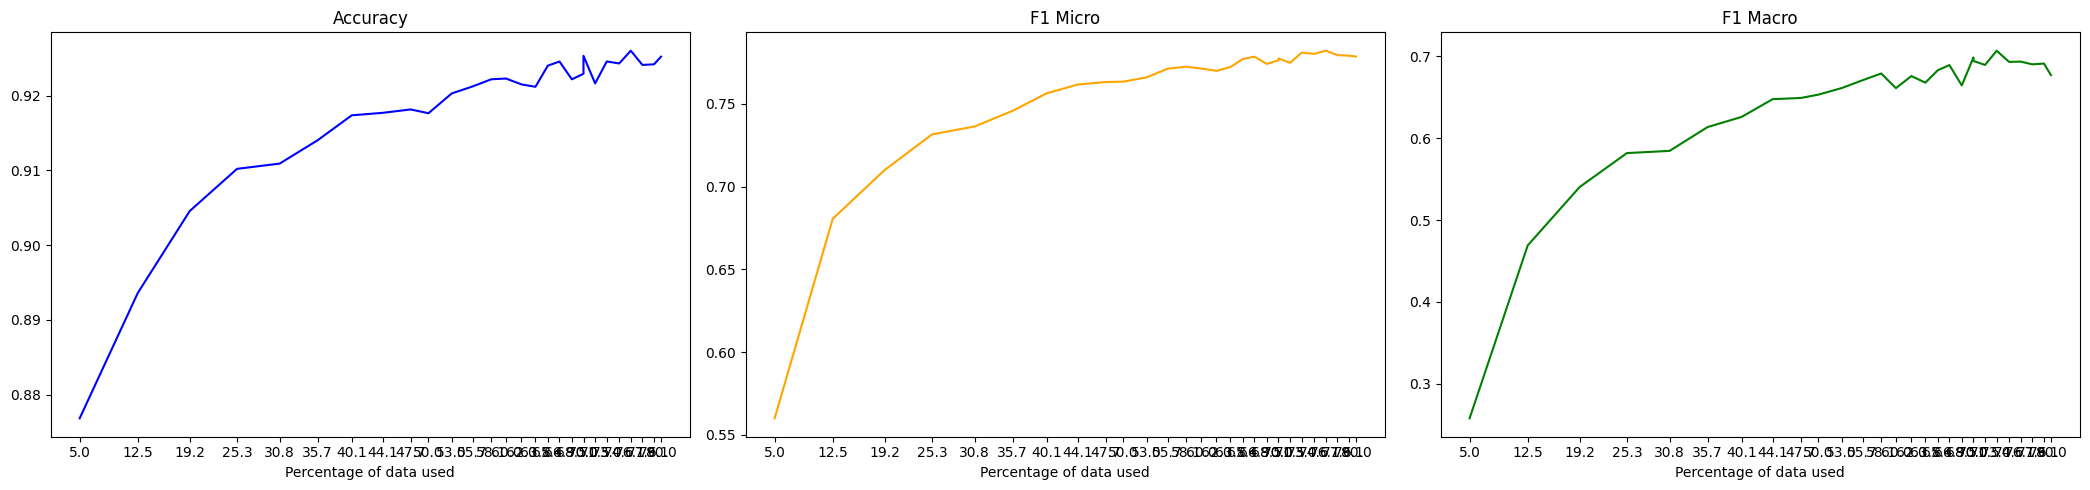

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 61, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.592, Accuracy: 0.8279, F1 Micro: 0.0872, F1 Macro: 0.0282
Epoch 2/10, Train Loss: 0.4622, Accuracy: 0.8279, F1 Micro: 0.0229, F1 Macro: 0.0086
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3927, Accuracy: 0.8335, F1 Micro: 0.1068, F1 Macro: 0.0416
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3964, Accuracy: 0.8362, F1 Micro: 0.1315, F1 Macro: 0.046
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3802, Accuracy: 0.8472, F1 Micro: 0.2582, F1 Macro: 0.0889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3611, Accuracy: 0.8539, F1 Micro: 0.347, F1 Macro: 0.1151
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3431, Accuracy: 0.8712, F1 Micro: 0.5052, F1 Macro: 0.2252
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3176, Accuracy: 0.8724, F1 Micro: 0.5088, F1 Macro: 0.2394
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2825, Accuracy: 0.8742, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6617, Accuracy: 0.8259, F1 Micro: 0.1583, F1 Macro: 0.0585
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4885, Accuracy: 0.8383, F1 Micro: 0.2329, F1 Macro: 0.0784
Epoch 3/10, Train Loss: 0.4062, Accuracy: 0.8355, F1 Micro: 0.1232, F1 Macro: 0.047
Epoch 4/10, Train Loss: 0.4042, Accuracy: 0.8358, F1 Micro: 0.1132, F1 Macro: 0.0443
Epoch 5/10, Train Loss: 0.3882, Accuracy: 0.8426, F1 Micro: 0.1993, F1 Macro: 0.0725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3714, Accuracy: 0.8533, F1 Micro: 0.3255, F1 Macro: 0.106
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3558, Accuracy: 0.8608, F1 Micro: 0.4029, F1 Macro: 0.1366
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.335, Accuracy: 0.8717, F1 Micro: 0.4978, F1 Macro: 0.2183
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3044, Accuracy: 0.8757, F1 Micro: 0.5599, F1 Macro: 0.2579
Epoch 10/10, Train Loss: 0.2723, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6172, Accuracy: 0.8198, F1 Micro: 0.3684, F1 Macro: 0.1118
Epoch 2/10, Train Loss: 0.4799, Accuracy: 0.8282, F1 Micro: 0.0142, F1 Macro: 0.0063
Epoch 3/10, Train Loss: 0.4012, Accuracy: 0.833, F1 Micro: 0.0831, F1 Macro: 0.031
Epoch 4/10, Train Loss: 0.4015, Accuracy: 0.8381, F1 Micro: 0.1679, F1 Macro: 0.0518
Epoch 5/10, Train Loss: 0.3869, Accuracy: 0.8431, F1 Micro: 0.215, F1 Macro: 0.0724
Epoch 6/10, Train Loss: 0.3725, Accuracy: 0.8499, F1 Micro: 0.2925, F1 Macro: 0.0972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3585, Accuracy: 0.8575, F1 Micro: 0.3854, F1 Macro: 0.1216
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3352, Accuracy: 0.8693, F1 Micro: 0.4738, F1 Macro: 0.2005
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2977, Accuracy: 0.8755, F1 Micro: 0.5714, F1 Macro: 0.2756
Epoch 10/10, Train Loss: 0.2676, Accuracy: 0.8765, F1 Micro: 0.561, F1 Macro: 0.2835
Model 3 - Iteration 6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.518, Accuracy: 0.8313, F1 Micro: 0.09, F1 Macro: 0.0294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4065, Accuracy: 0.84, F1 Micro: 0.1728, F1 Macro: 0.0632
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3667, Accuracy: 0.8618, F1 Micro: 0.4153, F1 Macro: 0.16
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3241, Accuracy: 0.8758, F1 Micro: 0.5832, F1 Macro: 0.282
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2909, Accuracy: 0.8791, F1 Micro: 0.6157, F1 Macro: 0.3186
Epoch 6/10, Train Loss: 0.2619, Accuracy: 0.8855, F1 Micro: 0.6072, F1 Macro: 0.3384
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2376, Accuracy: 0.8894, F1 Micro: 0.6328, F1 Macro: 0.3867
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2131, Accuracy: 0.8901, F1 Micro: 0.6693, F1 Macro: 0.4291
Epoch 9/10, Train Loss: 0.1946, Accuracy: 0.8933, F1 Micro: 0.6631, F1 Macro: 0.4354
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5645, Accuracy: 0.8425, F1 Micro: 0.323, F1 Macro: 0.0965
Epoch 2/10, Train Loss: 0.4141, Accuracy: 0.8489, F1 Micro: 0.2899, F1 Macro: 0.0933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3732, Accuracy: 0.8589, F1 Micro: 0.38, F1 Macro: 0.1293
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3374, Accuracy: 0.8755, F1 Micro: 0.5819, F1 Macro: 0.2701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3047, Accuracy: 0.8797, F1 Micro: 0.6069, F1 Macro: 0.2948
Epoch 6/10, Train Loss: 0.274, Accuracy: 0.884, F1 Micro: 0.6069, F1 Macro: 0.3126
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2488, Accuracy: 0.8852, F1 Micro: 0.6115, F1 Macro: 0.3381
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2231, Accuracy: 0.889, F1 Micro: 0.6373, F1 Macro: 0.3685
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2005, Accuracy: 0.8905, F1 Micro: 0.6431, F1 Macro: 0.3843
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5381, Accuracy: 0.8286, F1 Micro: 0.0195, F1 Macro: 0.0085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4115, Accuracy: 0.8457, F1 Micro: 0.2524, F1 Macro: 0.0861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3738, Accuracy: 0.8531, F1 Micro: 0.3209, F1 Macro: 0.1051
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3393, Accuracy: 0.876, F1 Micro: 0.5961, F1 Macro: 0.2905
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3014, Accuracy: 0.8819, F1 Micro: 0.6009, F1 Macro: 0.3176
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.271, Accuracy: 0.8873, F1 Micro: 0.6234, F1 Macro: 0.3503
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2468, Accuracy: 0.8887, F1 Micro: 0.6277, F1 Macro: 0.3605
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2173, Accuracy: 0.8885, F1 Micro: 0.6635, F1 Macro: 0.4039
Epoch 9/10, Train Loss: 0.1972, Accuracy: 0.8918, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4846, Accuracy: 0.8453, F1 Micro: 0.3098, F1 Macro: 0.0881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3793, Accuracy: 0.8675, F1 Micro: 0.5066, F1 Macro: 0.212
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3154, Accuracy: 0.878, F1 Micro: 0.6046, F1 Macro: 0.316
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2736, Accuracy: 0.8884, F1 Micro: 0.629, F1 Macro: 0.3597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2383, Accuracy: 0.891, F1 Micro: 0.6651, F1 Macro: 0.4687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2115, Accuracy: 0.8934, F1 Micro: 0.6826, F1 Macro: 0.469
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2029, Accuracy: 0.8999, F1 Micro: 0.6897, F1 Macro: 0.5092
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1709, Accuracy: 0.8968, F1 Micro: 0.7004, F1 Macro: 0.4928
Epoch 9/10, Train Loss: 0.1495, Accuracy: 0.9009, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.518, Accuracy: 0.843, F1 Micro: 0.3172, F1 Macro: 0.0852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.387, Accuracy: 0.8594, F1 Micro: 0.4547, F1 Macro: 0.1586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3306, Accuracy: 0.879, F1 Micro: 0.5917, F1 Macro: 0.2904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2873, Accuracy: 0.8851, F1 Micro: 0.6189, F1 Macro: 0.3204
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2484, Accuracy: 0.891, F1 Micro: 0.6539, F1 Macro: 0.3941
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2221, Accuracy: 0.8917, F1 Micro: 0.6673, F1 Macro: 0.4166
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2113, Accuracy: 0.8946, F1 Micro: 0.6789, F1 Macro: 0.4773
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1829, Accuracy: 0.8969, F1 Micro: 0.6876, F1 Macro: 0.4675
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.16

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4982, Accuracy: 0.8389, F1 Micro: 0.1668, F1 Macro: 0.0614
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3867, Accuracy: 0.8559, F1 Micro: 0.4222, F1 Macro: 0.1429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3298, Accuracy: 0.8768, F1 Micro: 0.6105, F1 Macro: 0.3233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2835, Accuracy: 0.8887, F1 Micro: 0.6289, F1 Macro: 0.3561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2436, Accuracy: 0.8913, F1 Micro: 0.6502, F1 Macro: 0.4188
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2182, Accuracy: 0.8924, F1 Micro: 0.6819, F1 Macro: 0.4527
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2082, Accuracy: 0.8983, F1 Micro: 0.6853, F1 Macro: 0.4935
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1805, Accuracy: 0.8964, F1 Micro: 0.6895, F1 Macro: 0.4841
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4614, Accuracy: 0.8366, F1 Micro: 0.121, F1 Macro: 0.0456
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3565, Accuracy: 0.8774, F1 Micro: 0.5767, F1 Macro: 0.2768
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2966, Accuracy: 0.8873, F1 Micro: 0.6158, F1 Macro: 0.3343
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2562, Accuracy: 0.8913, F1 Micro: 0.6732, F1 Macro: 0.4849
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2269, Accuracy: 0.8996, F1 Micro: 0.6888, F1 Macro: 0.4578
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.193, Accuracy: 0.8964, F1 Micro: 0.7021, F1 Macro: 0.509
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1649, Accuracy: 0.9036, F1 Micro: 0.7113, F1 Macro: 0.551
Epoch 8/10, Train Loss: 0.1441, Accuracy: 0.8953, F1 Micro: 0.7101, F1 Macro: 0.5506
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1247, Accuracy: 0.902, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4827, Accuracy: 0.8386, F1 Micro: 0.1349, F1 Macro: 0.0513
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3647, Accuracy: 0.8749, F1 Micro: 0.5626, F1 Macro: 0.2583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3042, Accuracy: 0.8854, F1 Micro: 0.6331, F1 Macro: 0.3294
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2646, Accuracy: 0.8887, F1 Micro: 0.6706, F1 Macro: 0.4362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2322, Accuracy: 0.8959, F1 Micro: 0.6804, F1 Macro: 0.4307
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1996, Accuracy: 0.8913, F1 Micro: 0.6953, F1 Macro: 0.4837
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1718, Accuracy: 0.8983, F1 Micro: 0.7083, F1 Macro: 0.5415
Epoch 8/10, Train Loss: 0.1525, Accuracy: 0.8935, F1 Micro: 0.7062, F1 Macro: 0.5519
Epoch 9/10, Train Loss: 0.1332, Accuracy: 0.8999, F1 Micro: 0.7076, F1 Macro: 0.5398
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.471, Accuracy: 0.8379, F1 Micro: 0.154, F1 Macro: 0.0492
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3663, Accuracy: 0.8766, F1 Micro: 0.5664, F1 Macro: 0.2686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.304, Accuracy: 0.8877, F1 Micro: 0.6391, F1 Macro: 0.3605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2599, Accuracy: 0.8888, F1 Micro: 0.6778, F1 Macro: 0.4461
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2306, Accuracy: 0.8952, F1 Micro: 0.6922, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1987, Accuracy: 0.896, F1 Micro: 0.7054, F1 Macro: 0.5142
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1709, Accuracy: 0.8982, F1 Micro: 0.7092, F1 Macro: 0.5503
Epoch 8/10, Train Loss: 0.1537, Accuracy: 0.8976, F1 Micro: 0.7071, F1 Macro: 0.549
Epoch 9/10, Train Loss: 0.1271, Accuracy: 0.8986, F1 Micro: 0.7091, F1 Macro: 0.5577
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4458, Accuracy: 0.8533, F1 Micro: 0.3456, F1 Macro: 0.1082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3396, Accuracy: 0.8797, F1 Micro: 0.6102, F1 Macro: 0.3018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2824, Accuracy: 0.8934, F1 Micro: 0.6554, F1 Macro: 0.4209
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2401, Accuracy: 0.8977, F1 Micro: 0.677, F1 Macro: 0.4385
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2102, Accuracy: 0.903, F1 Micro: 0.7059, F1 Macro: 0.511
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1815, Accuracy: 0.9059, F1 Micro: 0.7178, F1 Macro: 0.542
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1518, Accuracy: 0.9033, F1 Micro: 0.7213, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.13, Accuracy: 0.9072, F1 Micro: 0.7257, F1 Macro: 0.572
Epoch 9/10, Train Loss: 0.114, Accuracy: 0.9098, F1 Micro: 0.72

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4661, Accuracy: 0.8539, F1 Micro: 0.3636, F1 Macro: 0.1112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3511, Accuracy: 0.8796, F1 Micro: 0.6003, F1 Macro: 0.283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2918, Accuracy: 0.8901, F1 Micro: 0.6421, F1 Macro: 0.3575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2489, Accuracy: 0.8952, F1 Micro: 0.6732, F1 Macro: 0.4033
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2184, Accuracy: 0.9004, F1 Micro: 0.6915, F1 Macro: 0.478
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1909, Accuracy: 0.9038, F1 Micro: 0.705, F1 Macro: 0.5127
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1611, Accuracy: 0.902, F1 Micro: 0.7189, F1 Macro: 0.5355
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1345, Accuracy: 0.9051, F1 Micro: 0.7222, F1 Macro: 0.5721
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4562, Accuracy: 0.8497, F1 Micro: 0.2947, F1 Macro: 0.0979
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.349, Accuracy: 0.8803, F1 Micro: 0.6038, F1 Macro: 0.3004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2868, Accuracy: 0.8919, F1 Micro: 0.6652, F1 Macro: 0.4076
Epoch 4/10, Train Loss: 0.2459, Accuracy: 0.8981, F1 Micro: 0.665, F1 Macro: 0.4357
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2192, Accuracy: 0.9013, F1 Micro: 0.7113, F1 Macro: 0.5332
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1892, Accuracy: 0.9068, F1 Micro: 0.7185, F1 Macro: 0.5393
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1581, Accuracy: 0.9058, F1 Micro: 0.7253, F1 Macro: 0.5535
Epoch 8/10, Train Loss: 0.1333, Accuracy: 0.9059, F1 Micro: 0.7189, F1 Macro: 0.5695
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1175, Accuracy: 0.9079, F1 Micro: 0.73, F1 Macro: 0.5789
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4379, Accuracy: 0.8566, F1 Micro: 0.3928, F1 Macro: 0.1191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3258, Accuracy: 0.8858, F1 Micro: 0.6088, F1 Macro: 0.317
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.262, Accuracy: 0.8961, F1 Micro: 0.6763, F1 Macro: 0.465
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2304, Accuracy: 0.9032, F1 Micro: 0.7076, F1 Macro: 0.5193
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1976, Accuracy: 0.9071, F1 Micro: 0.7109, F1 Macro: 0.5371
Epoch 6/10, Train Loss: 0.1696, Accuracy: 0.9095, F1 Micro: 0.7098, F1 Macro: 0.5537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1414, Accuracy: 0.9121, F1 Micro: 0.7286, F1 Macro: 0.5728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1218, Accuracy: 0.9133, F1 Micro: 0.7353, F1 Macro: 0.5903
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1045, Accuracy: 0.9115, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4567, Accuracy: 0.8569, F1 Micro: 0.3788, F1 Macro: 0.1169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3343, Accuracy: 0.8842, F1 Micro: 0.6065, F1 Macro: 0.309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2703, Accuracy: 0.8933, F1 Micro: 0.6566, F1 Macro: 0.3907
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2356, Accuracy: 0.901, F1 Micro: 0.6739, F1 Macro: 0.451
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2063, Accuracy: 0.9036, F1 Micro: 0.6891, F1 Macro: 0.5086
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1759, Accuracy: 0.9069, F1 Micro: 0.7093, F1 Macro: 0.5414
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1497, Accuracy: 0.9112, F1 Micro: 0.7217, F1 Macro: 0.5731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1268, Accuracy: 0.9081, F1 Micro: 0.7279, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4464, Accuracy: 0.8537, F1 Micro: 0.3458, F1 Macro: 0.1099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3358, Accuracy: 0.8856, F1 Micro: 0.6183, F1 Macro: 0.3243
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.268, Accuracy: 0.8962, F1 Micro: 0.6779, F1 Macro: 0.428
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2334, Accuracy: 0.904, F1 Micro: 0.7024, F1 Macro: 0.5013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.202, Accuracy: 0.9078, F1 Micro: 0.7144, F1 Macro: 0.5302
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1732, Accuracy: 0.9076, F1 Micro: 0.7188, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1463, Accuracy: 0.9123, F1 Micro: 0.7275, F1 Macro: 0.5745
Epoch 8/10, Train Loss: 0.1244, Accuracy: 0.9098, F1 Micro: 0.7236, F1 Macro: 0.5684
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1061, Accuracy: 0.9136, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4309, Accuracy: 0.8699, F1 Micro: 0.5008, F1 Macro: 0.2175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.308, Accuracy: 0.8887, F1 Micro: 0.6493, F1 Macro: 0.3878
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2536, Accuracy: 0.9002, F1 Micro: 0.6865, F1 Macro: 0.443
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2205, Accuracy: 0.9065, F1 Micro: 0.6979, F1 Macro: 0.492
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9044, F1 Micro: 0.7255, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1581, Accuracy: 0.9107, F1 Micro: 0.7367, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1383, Accuracy: 0.9138, F1 Micro: 0.7443, F1 Macro: 0.6039
Epoch 8/10, Train Loss: 0.1141, Accuracy: 0.9138, F1 Micro: 0.7404, F1 Macro: 0.5873
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.102, Accuracy: 0.9149, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4498, Accuracy: 0.8616, F1 Micro: 0.4179, F1 Macro: 0.1473
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3188, Accuracy: 0.8867, F1 Micro: 0.6404, F1 Macro: 0.332
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2628, Accuracy: 0.8951, F1 Micro: 0.6583, F1 Macro: 0.3758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2271, Accuracy: 0.901, F1 Micro: 0.6692, F1 Macro: 0.437
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1979, Accuracy: 0.9025, F1 Micro: 0.7124, F1 Macro: 0.5505
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1689, Accuracy: 0.9089, F1 Micro: 0.7228, F1 Macro: 0.5614
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1445, Accuracy: 0.9107, F1 Micro: 0.7311, F1 Macro: 0.5988
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1196, Accuracy: 0.9132, F1 Micro: 0.7373, F1 Macro: 0.5883
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4408, Accuracy: 0.8585, F1 Micro: 0.3937, F1 Macro: 0.1302
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3156, Accuracy: 0.8881, F1 Micro: 0.65, F1 Macro: 0.378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2598, Accuracy: 0.8991, F1 Micro: 0.6778, F1 Macro: 0.4144
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2253, Accuracy: 0.9054, F1 Micro: 0.6972, F1 Macro: 0.4916
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1955, Accuracy: 0.9066, F1 Micro: 0.72, F1 Macro: 0.5592
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1651, Accuracy: 0.9113, F1 Micro: 0.7316, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1404, Accuracy: 0.9112, F1 Micro: 0.7338, F1 Macro: 0.5947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1174, Accuracy: 0.9135, F1 Micro: 0.743, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.105

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4233, Accuracy: 0.8678, F1 Micro: 0.5903, F1 Macro: 0.2705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3041, Accuracy: 0.8906, F1 Micro: 0.6719, F1 Macro: 0.4184
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2547, Accuracy: 0.9032, F1 Micro: 0.6952, F1 Macro: 0.4584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2244, Accuracy: 0.9072, F1 Micro: 0.709, F1 Macro: 0.5166
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1879, Accuracy: 0.9106, F1 Micro: 0.7319, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1569, Accuracy: 0.9167, F1 Micro: 0.7502, F1 Macro: 0.5952
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9132, F1 Micro: 0.7457, F1 Macro: 0.6056
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9149, F1 Micro: 0.7445, F1 Macro: 0.6085
Epoch 9/10, Train Loss: 0.0946, Accuracy: 0.9156, F1 Micro: 0.738, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4413, Accuracy: 0.8657, F1 Micro: 0.4988, F1 Macro: 0.1985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3144, Accuracy: 0.8885, F1 Micro: 0.6556, F1 Macro: 0.3536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2616, Accuracy: 0.8997, F1 Micro: 0.6751, F1 Macro: 0.426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2304, Accuracy: 0.9045, F1 Micro: 0.7024, F1 Macro: 0.508
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.195, Accuracy: 0.9102, F1 Micro: 0.7281, F1 Macro: 0.5591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9114, F1 Micro: 0.7406, F1 Macro: 0.5728
Epoch 7/10, Train Loss: 0.1381, Accuracy: 0.9113, F1 Micro: 0.7387, F1 Macro: 0.5747
Epoch 8/10, Train Loss: 0.1209, Accuracy: 0.9119, F1 Micro: 0.7405, F1 Macro: 0.5937
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1022, Accuracy: 0.9143, F1 Micro: 0.7429, F1 Macro: 0.6372
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4338, Accuracy: 0.8614, F1 Micro: 0.4693, F1 Macro: 0.1743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3133, Accuracy: 0.8894, F1 Micro: 0.6583, F1 Macro: 0.3752
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2595, Accuracy: 0.9024, F1 Micro: 0.6909, F1 Macro: 0.4558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2307, Accuracy: 0.9056, F1 Micro: 0.6979, F1 Macro: 0.49
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1932, Accuracy: 0.9086, F1 Micro: 0.7227, F1 Macro: 0.5403
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1672, Accuracy: 0.9138, F1 Micro: 0.747, F1 Macro: 0.5879
Epoch 7/10, Train Loss: 0.1349, Accuracy: 0.9147, F1 Micro: 0.7437, F1 Macro: 0.5915
Epoch 8/10, Train Loss: 0.12, Accuracy: 0.9058, F1 Micro: 0.7416, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.102, Accuracy: 0.9169, F1 Micro: 0.7506, F1 Macro: 0.6465
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4138, Accuracy: 0.8702, F1 Micro: 0.4654, F1 Macro: 0.2098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2955, Accuracy: 0.895, F1 Micro: 0.6818, F1 Macro: 0.4313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2446, Accuracy: 0.9056, F1 Micro: 0.6965, F1 Macro: 0.4933
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9071, F1 Micro: 0.7319, F1 Macro: 0.5582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9099, F1 Micro: 0.7384, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1449, Accuracy: 0.915, F1 Micro: 0.7493, F1 Macro: 0.5988
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1286, Accuracy: 0.9156, F1 Micro: 0.7514, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.9187, F1 Micro: 0.7591, F1 Macro: 0.6294
Epoch 9/10, Train Loss: 0.0923, Accuracy: 0.9185, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4335, Accuracy: 0.8679, F1 Micro: 0.4418, F1 Macro: 0.1804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3068, Accuracy: 0.8906, F1 Micro: 0.6628, F1 Macro: 0.3652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2507, Accuracy: 0.902, F1 Micro: 0.6707, F1 Macro: 0.4524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2126, Accuracy: 0.906, F1 Micro: 0.727, F1 Macro: 0.5471
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.9108, F1 Micro: 0.7289, F1 Macro: 0.551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1522, Accuracy: 0.9134, F1 Micro: 0.7396, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1351, Accuracy: 0.9138, F1 Micro: 0.7448, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1156, Accuracy: 0.9155, F1 Micro: 0.7484, F1 Macro: 0.604
Epoch 9/10, Train Loss: 0.0974, Accuracy: 0.9175, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4253, Accuracy: 0.8658, F1 Micro: 0.4249, F1 Macro: 0.1686
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3024, Accuracy: 0.8917, F1 Micro: 0.6779, F1 Macro: 0.392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2482, Accuracy: 0.9037, F1 Micro: 0.6904, F1 Macro: 0.4662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2081, Accuracy: 0.9038, F1 Micro: 0.7297, F1 Macro: 0.5468
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.183, Accuracy: 0.9124, F1 Micro: 0.7408, F1 Macro: 0.5742
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1489, Accuracy: 0.9148, F1 Micro: 0.7482, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1309, Accuracy: 0.917, F1 Micro: 0.7522, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1142, Accuracy: 0.9162, F1 Micro: 0.754, F1 Macro: 0.6179
Epoch 9/10, Train Loss: 0.0932, Accuracy: 0.9183, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4112, Accuracy: 0.8761, F1 Micro: 0.5704, F1 Macro: 0.2687
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2947, Accuracy: 0.896, F1 Micro: 0.6522, F1 Macro: 0.4165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2419, Accuracy: 0.9058, F1 Micro: 0.6931, F1 Macro: 0.4767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2042, Accuracy: 0.9097, F1 Micro: 0.7381, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9129, F1 Micro: 0.7505, F1 Macro: 0.5937
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9146, F1 Micro: 0.7457, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.9187, F1 Micro: 0.754, F1 Macro: 0.6281
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.9167, F1 Micro: 0.7611, F1 Macro: 0.6513
Epoch 9/10, Train Loss: 0.0907, Accuracy: 0.9175, F1 Micro: 0.7601, F1 Macro: 0.6372
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4282, Accuracy: 0.8739, F1 Micro: 0.5577, F1 Macro: 0.2474
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3039, Accuracy: 0.8934, F1 Micro: 0.6437, F1 Macro: 0.3575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2488, Accuracy: 0.9024, F1 Micro: 0.6938, F1 Macro: 0.4717
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2102, Accuracy: 0.9091, F1 Micro: 0.7266, F1 Macro: 0.5362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1759, Accuracy: 0.913, F1 Micro: 0.7406, F1 Macro: 0.574
Epoch 6/10, Train Loss: 0.1539, Accuracy: 0.9097, F1 Micro: 0.7349, F1 Macro: 0.5796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1302, Accuracy: 0.9169, F1 Micro: 0.741, F1 Macro: 0.6082
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1124, Accuracy: 0.9163, F1 Micro: 0.7522, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0952, Accuracy: 0.9171, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4216, Accuracy: 0.8695, F1 Micro: 0.4704, F1 Macro: 0.1963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3, Accuracy: 0.8931, F1 Micro: 0.6258, F1 Macro: 0.3709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2463, Accuracy: 0.9038, F1 Micro: 0.6787, F1 Macro: 0.4656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2072, Accuracy: 0.9101, F1 Micro: 0.7397, F1 Macro: 0.5634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1746, Accuracy: 0.9147, F1 Micro: 0.7514, F1 Macro: 0.5871
Epoch 6/10, Train Loss: 0.1517, Accuracy: 0.913, F1 Micro: 0.7395, F1 Macro: 0.5931
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1265, Accuracy: 0.9166, F1 Micro: 0.7529, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1117, Accuracy: 0.9132, F1 Micro: 0.755, F1 Macro: 0.6411
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0921, Accuracy: 0.9153, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4055, Accuracy: 0.8787, F1 Micro: 0.5934, F1 Macro: 0.2846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2841, Accuracy: 0.8956, F1 Micro: 0.6924, F1 Macro: 0.4651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2399, Accuracy: 0.9073, F1 Micro: 0.7184, F1 Macro: 0.5235
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.201, Accuracy: 0.9112, F1 Micro: 0.7193, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.9147, F1 Micro: 0.7476, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1379, Accuracy: 0.9174, F1 Micro: 0.7595, F1 Macro: 0.6221
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.9146, F1 Micro: 0.7519, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1046, Accuracy: 0.9169, F1 Micro: 0.7604, F1 Macro: 0.6371
Epoch 9/10, Train Loss: 0.0878, Accuracy: 0.9148, F1 Micro: 0.7598, F1 Macro: 0.6542
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4233, Accuracy: 0.8756, F1 Micro: 0.5697, F1 Macro: 0.2571
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2954, Accuracy: 0.8937, F1 Micro: 0.6631, F1 Macro: 0.3822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2477, Accuracy: 0.9046, F1 Micro: 0.7012, F1 Macro: 0.501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2077, Accuracy: 0.9088, F1 Micro: 0.7129, F1 Macro: 0.5121
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1794, Accuracy: 0.9111, F1 Micro: 0.7387, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1423, Accuracy: 0.9151, F1 Micro: 0.7464, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9148, F1 Micro: 0.7546, F1 Macro: 0.616
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1099, Accuracy: 0.9147, F1 Micro: 0.757, F1 Macro: 0.6211
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.9178, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4156, Accuracy: 0.8752, F1 Micro: 0.5969, F1 Macro: 0.283
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2895, Accuracy: 0.895, F1 Micro: 0.6856, F1 Macro: 0.4479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2442, Accuracy: 0.9059, F1 Micro: 0.704, F1 Macro: 0.5103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2044, Accuracy: 0.9124, F1 Micro: 0.7263, F1 Macro: 0.5492
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9174, F1 Micro: 0.7559, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1428, Accuracy: 0.9175, F1 Micro: 0.7587, F1 Macro: 0.6164
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9164, F1 Micro: 0.7523, F1 Macro: 0.6074
Epoch 8/10, Train Loss: 0.1081, Accuracy: 0.9175, F1 Micro: 0.7557, F1 Macro: 0.6256
Epoch 9/10, Train Loss: 0.09, Accuracy: 0.9124, F1 Micro: 0.7503, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4003, Accuracy: 0.8792, F1 Micro: 0.5635, F1 Macro: 0.2692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2853, Accuracy: 0.9006, F1 Micro: 0.6747, F1 Macro: 0.458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2333, Accuracy: 0.905, F1 Micro: 0.7268, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1999, Accuracy: 0.914, F1 Micro: 0.741, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9124, F1 Micro: 0.7545, F1 Macro: 0.604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9213, F1 Micro: 0.7585, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.92, F1 Micro: 0.768, F1 Macro: 0.658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9205, F1 Micro: 0.7684, F1 Macro: 0.6691
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9143, F1 Micro: 0.762

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4177, Accuracy: 0.8732, F1 Micro: 0.4919, F1 Macro: 0.2141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.293, Accuracy: 0.8977, F1 Micro: 0.6679, F1 Macro: 0.4321
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2416, Accuracy: 0.9043, F1 Micro: 0.7221, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2067, Accuracy: 0.9085, F1 Micro: 0.7304, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9128, F1 Micro: 0.7459, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9196, F1 Micro: 0.7559, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9209, F1 Micro: 0.7612, F1 Macro: 0.642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1035, Accuracy: 0.9154, F1 Micro: 0.7629, F1 Macro: 0.6528
Epoch 9/10, Train Loss: 0.091, Accuracy: 0.9191, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4103, Accuracy: 0.8745, F1 Micro: 0.4981, F1 Macro: 0.2258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2888, Accuracy: 0.9004, F1 Micro: 0.674, F1 Macro: 0.4454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2358, Accuracy: 0.9053, F1 Micro: 0.7263, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2024, Accuracy: 0.915, F1 Micro: 0.7376, F1 Macro: 0.5793
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.9146, F1 Micro: 0.7605, F1 Macro: 0.6146
Epoch 6/10, Train Loss: 0.1468, Accuracy: 0.9195, F1 Micro: 0.7499, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9179, F1 Micro: 0.7661, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.9191, F1 Micro: 0.7676, F1 Macro: 0.6583
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.922, F1 Micro: 0.7665, F1 Macro: 0.6559
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3985, Accuracy: 0.8811, F1 Micro: 0.5983, F1 Macro: 0.2842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2763, Accuracy: 0.9008, F1 Micro: 0.6978, F1 Macro: 0.4587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2363, Accuracy: 0.9118, F1 Micro: 0.7199, F1 Macro: 0.5302
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.9156, F1 Micro: 0.7508, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1659, Accuracy: 0.9141, F1 Micro: 0.7606, F1 Macro: 0.6174
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9197, F1 Micro: 0.76, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9213, F1 Micro: 0.7614, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9223, F1 Micro: 0.7672, F1 Macro: 0.6608
Epoch 9/10, Train Loss: 0.0858, Accuracy: 0.92, F1 Micro: 0.7629, F1 Macro: 0.6584
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4178, Accuracy: 0.8776, F1 Micro: 0.5578, F1 Macro: 0.2541
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2883, Accuracy: 0.8964, F1 Micro: 0.6697, F1 Macro: 0.3902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2455, Accuracy: 0.9088, F1 Micro: 0.7022, F1 Macro: 0.5105
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.9137, F1 Micro: 0.7381, F1 Macro: 0.5635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1719, Accuracy: 0.9146, F1 Micro: 0.7566, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9194, F1 Micro: 0.758, F1 Macro: 0.623
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1185, Accuracy: 0.9215, F1 Micro: 0.769, F1 Macro: 0.6597
Epoch 8/10, Train Loss: 0.1058, Accuracy: 0.9211, F1 Micro: 0.764, F1 Macro: 0.662
Epoch 9/10, Train Loss: 0.0892, Accuracy: 0.9165, F1 Micro: 0.7544, F1 Macro: 0.6358
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.408, Accuracy: 0.8795, F1 Micro: 0.6112, F1 Macro: 0.2908
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2825, Accuracy: 0.8989, F1 Micro: 0.695, F1 Macro: 0.4582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2396, Accuracy: 0.9099, F1 Micro: 0.7143, F1 Macro: 0.511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2046, Accuracy: 0.9164, F1 Micro: 0.747, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1712, Accuracy: 0.9132, F1 Micro: 0.758, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9217, F1 Micro: 0.7653, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9206, F1 Micro: 0.7688, F1 Macro: 0.647
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9202, F1 Micro: 0.7672, F1 Macro: 0.6623
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.9203, F1 Micro: 0.7543, F1 Macro: 0.6426
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.8804, F1 Micro: 0.5852, F1 Macro: 0.2849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.8975, F1 Micro: 0.6933, F1 Macro: 0.471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2338, Accuracy: 0.9082, F1 Micro: 0.727, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9189, F1 Micro: 0.7489, F1 Macro: 0.5893
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1661, Accuracy: 0.9173, F1 Micro: 0.7591, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9222, F1 Micro: 0.761, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9154, F1 Micro: 0.7654, F1 Macro: 0.661
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9123, F1 Micro: 0.7549, F1 Macro: 0.6557
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9215, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4161, Accuracy: 0.8784, F1 Micro: 0.5441, F1 Macro: 0.2507
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2846, Accuracy: 0.8971, F1 Micro: 0.6845, F1 Macro: 0.4305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2397, Accuracy: 0.9066, F1 Micro: 0.7148, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9149, F1 Micro: 0.7378, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1714, Accuracy: 0.9184, F1 Micro: 0.7567, F1 Macro: 0.6065
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9203, F1 Micro: 0.7553, F1 Macro: 0.609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.119, Accuracy: 0.9178, F1 Micro: 0.7629, F1 Macro: 0.6392
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.9189, F1 Micro: 0.7514, F1 Macro: 0.6391
Epoch 9/10, Train Loss: 0.0893, Accuracy: 0.9197, F1 Micro: 0.7572, F1 Macro: 0.6508
Epoch 10/10, Train Loss: 0.0777, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4104, Accuracy: 0.8803, F1 Micro: 0.5912, F1 Macro: 0.2915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2808, Accuracy: 0.8986, F1 Micro: 0.6928, F1 Macro: 0.479
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2362, Accuracy: 0.9089, F1 Micro: 0.7213, F1 Macro: 0.5651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.9162, F1 Micro: 0.7446, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9213, F1 Micro: 0.7597, F1 Macro: 0.6132
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.921, F1 Micro: 0.7558, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9209, F1 Micro: 0.7654, F1 Macro: 0.6525
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9164, F1 Micro: 0.7603, F1 Macro: 0.6516
Epoch 9/10, Train Loss: 0.0895, Accuracy: 0.9204, F1 Micro: 0.7647, F1 Macro: 0.6668
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3929, Accuracy: 0.8819, F1 Micro: 0.5952, F1 Macro: 0.3038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2768, Accuracy: 0.8965, F1 Micro: 0.7021, F1 Macro: 0.4993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.232, Accuracy: 0.9115, F1 Micro: 0.7244, F1 Macro: 0.545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.9159, F1 Micro: 0.7506, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1613, Accuracy: 0.9201, F1 Micro: 0.7539, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9194, F1 Micro: 0.767, F1 Macro: 0.6524
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9168, F1 Micro: 0.7573, F1 Macro: 0.6418
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9197, F1 Micro: 0.7549, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9242, F1 Micro: 0.7711, F1 Macro: 0.6695
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4092, Accuracy: 0.8794, F1 Micro: 0.5662, F1 Macro: 0.2653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2831, Accuracy: 0.8971, F1 Micro: 0.6938, F1 Macro: 0.4673
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2381, Accuracy: 0.9091, F1 Micro: 0.7224, F1 Macro: 0.532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.9135, F1 Micro: 0.749, F1 Macro: 0.5791
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.919, F1 Micro: 0.7451, F1 Macro: 0.5893
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.9189, F1 Micro: 0.7632, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1195, Accuracy: 0.9181, F1 Micro: 0.7533, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.9191, F1 Micro: 0.7658, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0895, Accuracy: 0.9176, F1 Micro: 0.7659, F1 Macro: 0.6629
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4031, Accuracy: 0.8814, F1 Micro: 0.5979, F1 Macro: 0.3004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2815, Accuracy: 0.8957, F1 Micro: 0.7038, F1 Macro: 0.4966
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2355, Accuracy: 0.9124, F1 Micro: 0.7299, F1 Macro: 0.5419
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1938, Accuracy: 0.9154, F1 Micro: 0.7442, F1 Macro: 0.5724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.167, Accuracy: 0.9191, F1 Micro: 0.7543, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.136, Accuracy: 0.9204, F1 Micro: 0.7697, F1 Macro: 0.6652
Epoch 7/10, Train Loss: 0.1191, Accuracy: 0.9201, F1 Micro: 0.7645, F1 Macro: 0.6395
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9191, F1 Micro: 0.7592, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0861, Accuracy: 0.9196, F1 Micro: 0.7707, F1 Macro: 0.6788
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3951, Accuracy: 0.8819, F1 Micro: 0.6065, F1 Macro: 0.2999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.9034, F1 Micro: 0.7096, F1 Macro: 0.5226
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2273, Accuracy: 0.9143, F1 Micro: 0.7325, F1 Macro: 0.5402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1958, Accuracy: 0.9201, F1 Micro: 0.7562, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.9184, F1 Micro: 0.7655, F1 Macro: 0.6205
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.921, F1 Micro: 0.7614, F1 Macro: 0.6417
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1141, Accuracy: 0.9251, F1 Micro: 0.7721, F1 Macro: 0.672
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9223, F1 Micro: 0.7711, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.9226, F1 Micro: 0.7753, F1 Macro: 0.6862
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.8802, F1 Micro: 0.6196, F1 Macro: 0.2956
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2806, Accuracy: 0.9009, F1 Micro: 0.6872, F1 Macro: 0.4747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.9096, F1 Micro: 0.7302, F1 Macro: 0.5359
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.202, Accuracy: 0.9173, F1 Micro: 0.7508, F1 Macro: 0.5731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1646, Accuracy: 0.9152, F1 Micro: 0.7574, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1409, Accuracy: 0.9202, F1 Micro: 0.7587, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1192, Accuracy: 0.9223, F1 Micro: 0.762, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1007, Accuracy: 0.9192, F1 Micro: 0.7643, F1 Macro: 0.667
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4029, Accuracy: 0.8808, F1 Micro: 0.6332, F1 Macro: 0.3259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.276, Accuracy: 0.9027, F1 Micro: 0.7077, F1 Macro: 0.514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2301, Accuracy: 0.9115, F1 Micro: 0.7138, F1 Macro: 0.5314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9168, F1 Micro: 0.7453, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9179, F1 Micro: 0.7641, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9218, F1 Micro: 0.7658, F1 Macro: 0.6457
Epoch 7/10, Train Loss: 0.1158, Accuracy: 0.9235, F1 Micro: 0.76, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0991, Accuracy: 0.9219, F1 Micro: 0.7737, F1 Macro: 0.6801
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9225, F1 Micro: 0.7701, F1 Macro: 0.6977
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.392, Accuracy: 0.8809, F1 Micro: 0.5489, F1 Macro: 0.2674
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2651, Accuracy: 0.9065, F1 Micro: 0.6982, F1 Macro: 0.4723
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.9156, F1 Micro: 0.7458, F1 Macro: 0.5708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.9187, F1 Micro: 0.761, F1 Macro: 0.6012
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9223, F1 Micro: 0.7654, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9214, F1 Micro: 0.7726, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9232, F1 Micro: 0.7781, F1 Macro: 0.6729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0958, Accuracy: 0.9238, F1 Micro: 0.78, F1 Macro: 0.6912
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9202, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4062, Accuracy: 0.8833, F1 Micro: 0.6002, F1 Macro: 0.2922
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.8991, F1 Micro: 0.6634, F1 Macro: 0.4087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.9113, F1 Micro: 0.7105, F1 Macro: 0.5255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1937, Accuracy: 0.915, F1 Micro: 0.745, F1 Macro: 0.5846
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9174, F1 Micro: 0.7583, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9217, F1 Micro: 0.7651, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.9227, F1 Micro: 0.7697, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.9222, F1 Micro: 0.7719, F1 Macro: 0.6584
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9238, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4006, Accuracy: 0.883, F1 Micro: 0.5819, F1 Macro: 0.2879
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2689, Accuracy: 0.9045, F1 Micro: 0.687, F1 Macro: 0.4634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2237, Accuracy: 0.9149, F1 Micro: 0.7376, F1 Macro: 0.555
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9158, F1 Micro: 0.7559, F1 Macro: 0.5942
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9211, F1 Micro: 0.7619, F1 Macro: 0.6285
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.9224, F1 Micro: 0.7729, F1 Macro: 0.6416
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9235, F1 Micro: 0.7674, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9239, F1 Micro: 0.7783, F1 Macro: 0.668
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9221, F1 Micro: 0.7674, F1 Macro: 0.6743
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3869, Accuracy: 0.8828, F1 Micro: 0.6246, F1 Macro: 0.3206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2714, Accuracy: 0.9054, F1 Micro: 0.6928, F1 Macro: 0.5024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9142, F1 Micro: 0.7428, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1828, Accuracy: 0.9178, F1 Micro: 0.7546, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1544, Accuracy: 0.9175, F1 Micro: 0.7588, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9214, F1 Micro: 0.7732, F1 Macro: 0.6587
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9238, F1 Micro: 0.7686, F1 Macro: 0.6788
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9218, F1 Micro: 0.7741, F1 Macro: 0.6869
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9218, F1 Micro: 0.7707, F1 Macro: 0.6825
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4033, Accuracy: 0.8822, F1 Micro: 0.6096, F1 Macro: 0.2964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2801, Accuracy: 0.9021, F1 Micro: 0.6865, F1 Macro: 0.4602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2267, Accuracy: 0.9119, F1 Micro: 0.7379, F1 Macro: 0.5662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1872, Accuracy: 0.9173, F1 Micro: 0.7507, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9174, F1 Micro: 0.7589, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9222, F1 Micro: 0.7734, F1 Macro: 0.6429
Epoch 7/10, Train Loss: 0.1167, Accuracy: 0.9215, F1 Micro: 0.766, F1 Macro: 0.6704
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9227, F1 Micro: 0.7731, F1 Macro: 0.6699
Epoch 9/10, Train Loss: 0.0849, Accuracy: 0.9225, F1 Micro: 0.7704, F1 Macro: 0.6777
Epoch 10/10, Train Loss: 0.0732, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3973, Accuracy: 0.8837, F1 Micro: 0.598, F1 Macro: 0.2952
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2755, Accuracy: 0.905, F1 Micro: 0.6892, F1 Macro: 0.4926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2221, Accuracy: 0.9124, F1 Micro: 0.736, F1 Macro: 0.567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.9159, F1 Micro: 0.7528, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.916, F1 Micro: 0.7574, F1 Macro: 0.6077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9237, F1 Micro: 0.7756, F1 Macro: 0.6496
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9217, F1 Micro: 0.7681, F1 Macro: 0.6611
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9232, F1 Micro: 0.7748, F1 Macro: 0.6682
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.9185, F1 Micro: 0.7694, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3851, Accuracy: 0.8859, F1 Micro: 0.6206, F1 Macro: 0.3263
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.9065, F1 Micro: 0.6977, F1 Macro: 0.4819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9129, F1 Micro: 0.7245, F1 Macro: 0.557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9192, F1 Micro: 0.7604, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1541, Accuracy: 0.9231, F1 Micro: 0.7703, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1301, Accuracy: 0.923, F1 Micro: 0.7755, F1 Macro: 0.6596
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.9252, F1 Micro: 0.7768, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9262, F1 Micro: 0.7816, F1 Macro: 0.6877
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9243, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4004, Accuracy: 0.8828, F1 Micro: 0.5822, F1 Macro: 0.2861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.9034, F1 Micro: 0.6847, F1 Macro: 0.4494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.9082, F1 Micro: 0.6976, F1 Macro: 0.5144
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1915, Accuracy: 0.9169, F1 Micro: 0.7554, F1 Macro: 0.5948
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9219, F1 Micro: 0.7669, F1 Macro: 0.63
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9204, F1 Micro: 0.7635, F1 Macro: 0.643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9208, F1 Micro: 0.7678, F1 Macro: 0.6387
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9226, F1 Micro: 0.7753, F1 Macro: 0.6767
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.921, F1 Micro: 0.7698, F1 Macro: 0.6715
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.887, F1 Micro: 0.6088, F1 Macro: 0.3065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2733, Accuracy: 0.9068, F1 Micro: 0.7079, F1 Macro: 0.5043
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.9125, F1 Micro: 0.7207, F1 Macro: 0.5283
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9195, F1 Micro: 0.7603, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9225, F1 Micro: 0.769, F1 Macro: 0.6368
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9213, F1 Micro: 0.7729, F1 Macro: 0.6643
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.9219, F1 Micro: 0.7707, F1 Macro: 0.6636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9215, F1 Micro: 0.7768, F1 Macro: 0.69
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9229, F1 Micro: 0.7746, F1 Macro: 0.6909
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3844, Accuracy: 0.8833, F1 Micro: 0.6039, F1 Macro: 0.316
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.9054, F1 Micro: 0.7088, F1 Macro: 0.5008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9162, F1 Micro: 0.7486, F1 Macro: 0.5684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9212, F1 Micro: 0.7575, F1 Macro: 0.6006
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9231, F1 Micro: 0.7656, F1 Macro: 0.6315
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9237, F1 Micro: 0.7749, F1 Macro: 0.6365
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9196, F1 Micro: 0.7697, F1 Macro: 0.6516
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.924, F1 Micro: 0.7741, F1 Macro: 0.6814
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9235, F1 Micro: 0.7733, F1 Macro: 0.6822
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4001, Accuracy: 0.8829, F1 Micro: 0.6253, F1 Macro: 0.3128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.271, Accuracy: 0.9031, F1 Micro: 0.687, F1 Macro: 0.4445
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2234, Accuracy: 0.9129, F1 Micro: 0.7356, F1 Macro: 0.5508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.9189, F1 Micro: 0.7529, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1587, Accuracy: 0.9211, F1 Micro: 0.7591, F1 Macro: 0.6254
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9229, F1 Micro: 0.7679, F1 Macro: 0.6437
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9194, F1 Micro: 0.7683, F1 Macro: 0.6406
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.9222, F1 Micro: 0.7654, F1 Macro: 0.6567
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.9224, F1 Micro: 0.7676, F1 Macro: 0.6659
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3935, Accuracy: 0.883, F1 Micro: 0.6015, F1 Macro: 0.304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.906, F1 Micro: 0.6992, F1 Macro: 0.4887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2184, Accuracy: 0.9142, F1 Micro: 0.7414, F1 Macro: 0.5619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9205, F1 Micro: 0.7536, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.922, F1 Micro: 0.7569, F1 Macro: 0.6341
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9232, F1 Micro: 0.7677, F1 Macro: 0.6385
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9149, F1 Micro: 0.76, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9207, F1 Micro: 0.7728, F1 Macro: 0.6778
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9235, F1 Micro: 0.7676, F1 Macro: 0.6721
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3816, Accuracy: 0.8854, F1 Micro: 0.6195, F1 Macro: 0.3308
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2621, Accuracy: 0.9058, F1 Micro: 0.7189, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2161, Accuracy: 0.9169, F1 Micro: 0.7457, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9208, F1 Micro: 0.7618, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1511, Accuracy: 0.9234, F1 Micro: 0.7734, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1246, Accuracy: 0.9219, F1 Micro: 0.7758, F1 Macro: 0.6792
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9237, F1 Micro: 0.7756, F1 Macro: 0.6787
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9207, F1 Micro: 0.7755, F1 Macro: 0.6938
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9191, F1 Micro: 0.7718, F1 Macro: 0.6848
Epoch 10/10, Train Loss: 0.0669, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3993, Accuracy: 0.884, F1 Micro: 0.6118, F1 Macro: 0.3029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2698, Accuracy: 0.9033, F1 Micro: 0.7109, F1 Macro: 0.5035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.9129, F1 Micro: 0.7285, F1 Macro: 0.5516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9188, F1 Micro: 0.7538, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1552, Accuracy: 0.92, F1 Micro: 0.7669, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9212, F1 Micro: 0.7705, F1 Macro: 0.644
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9225, F1 Micro: 0.7703, F1 Macro: 0.6584
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9213, F1 Micro: 0.7706, F1 Macro: 0.6675
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9185, F1 Micro: 0.7692, F1 Macro: 0.6689
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3903, Accuracy: 0.8861, F1 Micro: 0.6349, F1 Macro: 0.3377
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.9033, F1 Micro: 0.7178, F1 Macro: 0.5236
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9151, F1 Micro: 0.7422, F1 Macro: 0.5785
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.92, F1 Micro: 0.7606, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9216, F1 Micro: 0.7636, F1 Macro: 0.616
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1308, Accuracy: 0.92, F1 Micro: 0.7717, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9239, F1 Micro: 0.7738, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9241, F1 Micro: 0.7783, F1 Macro: 0.6897
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9218, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3825, Accuracy: 0.8876, F1 Micro: 0.6217, F1 Macro: 0.3347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2627, Accuracy: 0.9087, F1 Micro: 0.7105, F1 Macro: 0.5309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2094, Accuracy: 0.9128, F1 Micro: 0.7479, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1836, Accuracy: 0.919, F1 Micro: 0.7617, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.921, F1 Micro: 0.7659, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.924, F1 Micro: 0.7739, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.923, F1 Micro: 0.7736, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9192, F1 Micro: 0.7761, F1 Macro: 0.6897
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9226, F1 Micro: 0.7704, F1 Macro: 0.6791
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3999, Accuracy: 0.8833, F1 Micro: 0.5963, F1 Macro: 0.2981
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.9046, F1 Micro: 0.6982, F1 Macro: 0.4881
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9122, F1 Micro: 0.7379, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.19, Accuracy: 0.9171, F1 Micro: 0.7521, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9207, F1 Micro: 0.7539, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1305, Accuracy: 0.9213, F1 Micro: 0.7661, F1 Macro: 0.6399
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9222, F1 Micro: 0.7615, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9188, F1 Micro: 0.7725, F1 Macro: 0.6643
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9225, F1 Micro: 0.7714, F1 Macro: 0.678
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3923, Accuracy: 0.8861, F1 Micro: 0.6079, F1 Macro: 0.3084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.9075, F1 Micro: 0.7161, F1 Macro: 0.5255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.9114, F1 Micro: 0.7431, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9207, F1 Micro: 0.7573, F1 Macro: 0.6093
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1501, Accuracy: 0.9233, F1 Micro: 0.7725, F1 Macro: 0.6275
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9237, F1 Micro: 0.7745, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9235, F1 Micro: 0.7765, F1 Macro: 0.6647
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9192, F1 Micro: 0.7689, F1 Macro: 0.6695
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9258, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3801, Accuracy: 0.8879, F1 Micro: 0.6123, F1 Macro: 0.3354
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.9076, F1 Micro: 0.693, F1 Macro: 0.4812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9165, F1 Micro: 0.7339, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.9206, F1 Micro: 0.7663, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9187, F1 Micro: 0.7687, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9243, F1 Micro: 0.7711, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9247, F1 Micro: 0.7756, F1 Macro: 0.6693
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9212, F1 Micro: 0.7735, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.9248, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3935, Accuracy: 0.8875, F1 Micro: 0.6219, F1 Macro: 0.3187
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2651, Accuracy: 0.904, F1 Micro: 0.6841, F1 Macro: 0.4467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2184, Accuracy: 0.9134, F1 Micro: 0.7206, F1 Macro: 0.5432
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9199, F1 Micro: 0.7539, F1 Macro: 0.5997
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9208, F1 Micro: 0.7689, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9225, F1 Micro: 0.7712, F1 Macro: 0.6583
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9226, F1 Micro: 0.7707, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9225, F1 Micro: 0.7759, F1 Macro: 0.6814
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9195, F1 Micro: 0.7716, F1 Macro: 0.6818
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.8886, F1 Micro: 0.6431, F1 Macro: 0.3401
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9073, F1 Micro: 0.6994, F1 Macro: 0.4856
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.9155, F1 Micro: 0.7333, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9207, F1 Micro: 0.7637, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9167, F1 Micro: 0.7654, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9211, F1 Micro: 0.7734, F1 Macro: 0.6657
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9236, F1 Micro: 0.7723, F1 Macro: 0.6632
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9213, F1 Micro: 0.771, F1 Macro: 0.6724
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9186, F1 Micro: 0.7722, F1 Macro: 0.6974
Epoch 10/10, Train Loss: 0.0653, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.8844, F1 Micro: 0.6631, F1 Macro: 0.4086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2582, Accuracy: 0.9047, F1 Micro: 0.7215, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2129, Accuracy: 0.916, F1 Micro: 0.7468, F1 Macro: 0.5903
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.921, F1 Micro: 0.7507, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1556, Accuracy: 0.9232, F1 Micro: 0.7747, F1 Macro: 0.6748
Epoch 6/10, Train Loss: 0.1249, Accuracy: 0.9198, F1 Micro: 0.7705, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9255, F1 Micro: 0.7683, F1 Macro: 0.6581
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9235, F1 Micro: 0.7732, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9254, F1 Micro: 0.7764, F1 Macro: 0.6942
Epoch 10/10, Train Loss: 0.0657, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8853, F1 Micro: 0.6398, F1 Macro: 0.3293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.9052, F1 Micro: 0.7051, F1 Macro: 0.4942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2183, Accuracy: 0.9146, F1 Micro: 0.7298, F1 Macro: 0.5513
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9209, F1 Micro: 0.7584, F1 Macro: 0.622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.917, F1 Micro: 0.7604, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9196, F1 Micro: 0.7675, F1 Macro: 0.6482
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.923, F1 Micro: 0.7659, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0951, Accuracy: 0.9212, F1 Micro: 0.771, F1 Macro: 0.6713
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9222, F1 Micro: 0.7638, F1 Macro: 0.679
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3865, Accuracy: 0.8845, F1 Micro: 0.6556, F1 Macro: 0.3644
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2615, Accuracy: 0.9058, F1 Micro: 0.7169, F1 Macro: 0.511
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2136, Accuracy: 0.9155, F1 Micro: 0.7387, F1 Macro: 0.5672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9219, F1 Micro: 0.7606, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9212, F1 Micro: 0.7698, F1 Macro: 0.661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9183, F1 Micro: 0.7711, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9245, F1 Micro: 0.7728, F1 Macro: 0.6624
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9226, F1 Micro: 0.7698, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9253, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.377, Accuracy: 0.8895, F1 Micro: 0.6545, F1 Macro: 0.3837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9075, F1 Micro: 0.7137, F1 Macro: 0.5135
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9188, F1 Micro: 0.7426, F1 Macro: 0.5823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.9184, F1 Micro: 0.7433, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1508, Accuracy: 0.9231, F1 Micro: 0.7694, F1 Macro: 0.6491
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9232, F1 Micro: 0.7749, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.922, F1 Micro: 0.7746, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9238, F1 Micro: 0.7779, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9248, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3929, Accuracy: 0.8867, F1 Micro: 0.6425, F1 Macro: 0.3361
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.9065, F1 Micro: 0.7094, F1 Macro: 0.4978
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.9148, F1 Micro: 0.7278, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9176, F1 Micro: 0.7418, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9218, F1 Micro: 0.768, F1 Macro: 0.639
Epoch 6/10, Train Loss: 0.1234, Accuracy: 0.9209, F1 Micro: 0.7669, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9214, F1 Micro: 0.7708, F1 Macro: 0.663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9235, F1 Micro: 0.772, F1 Macro: 0.6647
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9237, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3853, Accuracy: 0.8889, F1 Micro: 0.6502, F1 Macro: 0.3462
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.9071, F1 Micro: 0.7112, F1 Macro: 0.5146
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.9169, F1 Micro: 0.7334, F1 Macro: 0.5684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9175, F1 Micro: 0.7426, F1 Macro: 0.5975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9155, F1 Micro: 0.7656, F1 Macro: 0.6511
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.921, F1 Micro: 0.7711, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9209, F1 Micro: 0.7711, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0934, Accuracy: 0.9237, F1 Micro: 0.776, F1 Macro: 0.6759
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9196, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3739, Accuracy: 0.8847, F1 Micro: 0.5723, F1 Macro: 0.2921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.904, F1 Micro: 0.6627, F1 Macro: 0.4787
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9163, F1 Micro: 0.7484, F1 Macro: 0.5937
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9204, F1 Micro: 0.7515, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.9241, F1 Micro: 0.7668, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9253, F1 Micro: 0.7732, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9264, F1 Micro: 0.7799, F1 Macro: 0.6707
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9244, F1 Micro: 0.7777, F1 Macro: 0.6836
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.924, F1 Micro: 0.778, F1 Macro: 0.6891
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.8846, F1 Micro: 0.5907, F1 Macro: 0.2917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.9027, F1 Micro: 0.6652, F1 Macro: 0.4755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9147, F1 Micro: 0.7358, F1 Macro: 0.569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9203, F1 Micro: 0.7577, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9207, F1 Micro: 0.7623, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9218, F1 Micro: 0.7715, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9245, F1 Micro: 0.7724, F1 Macro: 0.6534
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9222, F1 Micro: 0.7679, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9224, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3807, Accuracy: 0.8851, F1 Micro: 0.5751, F1 Macro: 0.2901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.903, F1 Micro: 0.6574, F1 Macro: 0.4802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9151, F1 Micro: 0.7449, F1 Macro: 0.5776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9229, F1 Micro: 0.7665, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.923, F1 Micro: 0.7689, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9231, F1 Micro: 0.7714, F1 Macro: 0.6479
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9263, F1 Micro: 0.7686, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9236, F1 Micro: 0.7778, F1 Macro: 0.6907
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9208, F1 Micro: 0.7702, F1 Macro: 0.6651
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3643, Accuracy: 0.8912, F1 Micro: 0.6325, F1 Macro: 0.3629
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.9079, F1 Micro: 0.6894, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9157, F1 Micro: 0.7276, F1 Macro: 0.5546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9235, F1 Micro: 0.7661, F1 Macro: 0.6217
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9227, F1 Micro: 0.7708, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9257, F1 Micro: 0.7719, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.9248, F1 Micro: 0.7732, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9238, F1 Micro: 0.7759, F1 Macro: 0.6767
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9198, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3802, Accuracy: 0.8863, F1 Micro: 0.6197, F1 Macro: 0.323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9024, F1 Micro: 0.666, F1 Macro: 0.4689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.9127, F1 Micro: 0.7121, F1 Macro: 0.5255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.921, F1 Micro: 0.7662, F1 Macro: 0.6168
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9204, F1 Micro: 0.7678, F1 Macro: 0.6481
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9245, F1 Micro: 0.7688, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9244, F1 Micro: 0.7752, F1 Macro: 0.6624
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9247, F1 Micro: 0.7751, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9245, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.8907, F1 Micro: 0.6344, F1 Macro: 0.336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.905, F1 Micro: 0.6727, F1 Macro: 0.4728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.9158, F1 Micro: 0.7354, F1 Macro: 0.5544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9218, F1 Micro: 0.7705, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9225, F1 Micro: 0.772, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9268, F1 Micro: 0.7756, F1 Macro: 0.6713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9247, F1 Micro: 0.777, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9226, F1 Micro: 0.7802, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.076

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.8885, F1 Micro: 0.6458, F1 Macro: 0.3509
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.9049, F1 Micro: 0.7225, F1 Macro: 0.5133
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.914, F1 Micro: 0.7519, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9219, F1 Micro: 0.7649, F1 Macro: 0.6148
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.9249, F1 Micro: 0.7739, F1 Macro: 0.6486
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9222, F1 Micro: 0.7706, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9225, F1 Micro: 0.7742, F1 Macro: 0.6608
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9222, F1 Micro: 0.7736, F1 Macro: 0.6801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.9223, F1 Micro: 0.7779, F1 Macro: 0.6949
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3843, Accuracy: 0.8866, F1 Micro: 0.6301, F1 Macro: 0.3199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2538, Accuracy: 0.9046, F1 Micro: 0.7149, F1 Macro: 0.4775
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9153, F1 Micro: 0.7473, F1 Macro: 0.5801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9218, F1 Micro: 0.7601, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9233, F1 Micro: 0.7695, F1 Macro: 0.6294
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9247, F1 Micro: 0.7708, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9233, F1 Micro: 0.7725, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9233, F1 Micro: 0.7736, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3775, Accuracy: 0.8894, F1 Micro: 0.6491, F1 Macro: 0.3447
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.9065, F1 Micro: 0.7187, F1 Macro: 0.5044
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9158, F1 Micro: 0.7514, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9221, F1 Micro: 0.765, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9222, F1 Micro: 0.7667, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9208, F1 Micro: 0.7726, F1 Macro: 0.6399
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.92, F1 Micro: 0.7726, F1 Macro: 0.6651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9258, F1 Micro: 0.7776, F1 Macro: 0.6949
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9252, F1 Micro: 0

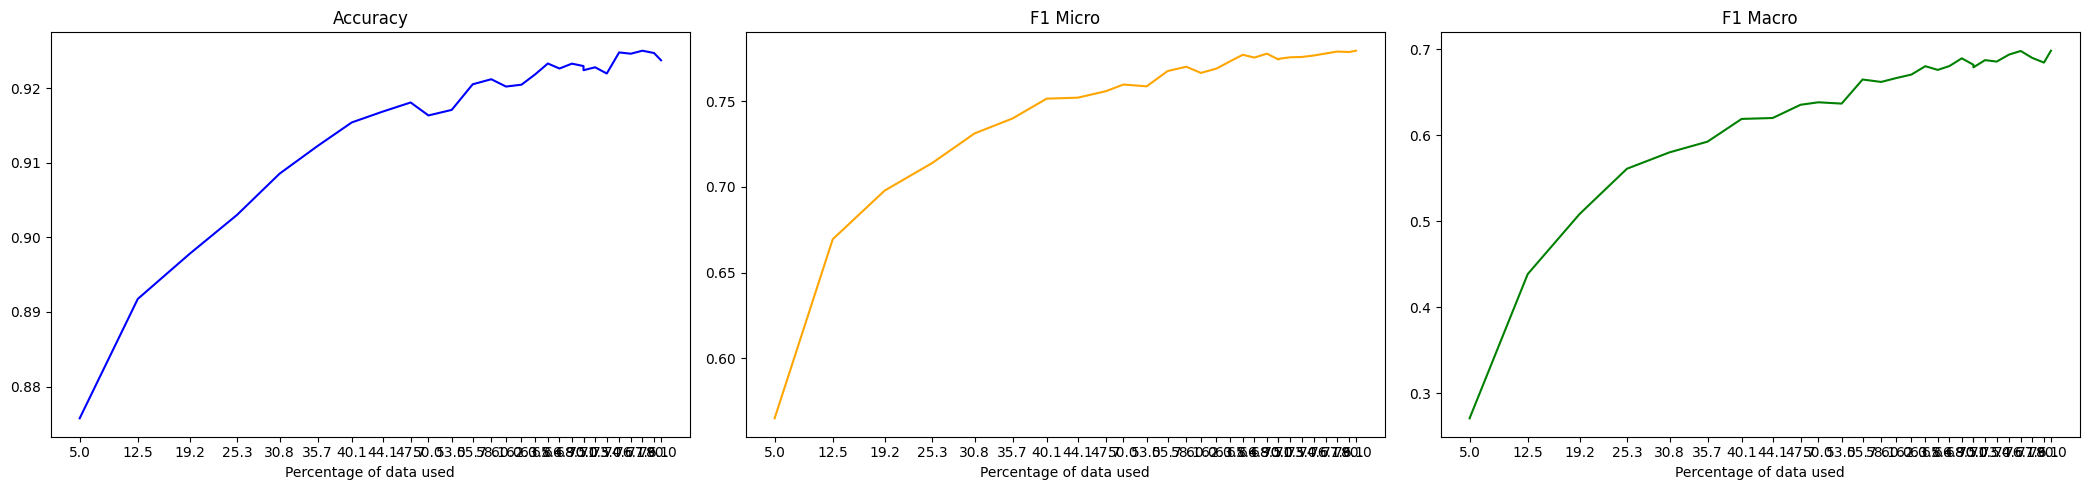

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6119, Accuracy: 0.83, F1 Micro: 0.1445, F1 Macro: 0.045
Epoch 2/10, Train Loss: 0.4724, Accuracy: 0.8287, F1 Micro: 0.0209, F1 Macro: 0.0091
Epoch 3/10, Train Loss: 0.3967, Accuracy: 0.8346, F1 Micro: 0.1256, F1 Macro: 0.0415
Epoch 4/10, Train Loss: 0.4024, Accuracy: 0.8353, F1 Micro: 0.122, F1 Macro: 0.0414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3867, Accuracy: 0.8389, F1 Micro: 0.1605, F1 Macro: 0.0558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3732, Accuracy: 0.8487, F1 Micro: 0.2747, F1 Macro: 0.0919
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3557, Accuracy: 0.8622, F1 Micro: 0.4166, F1 Macro: 0.1524
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3336, Accuracy: 0.8704, F1 Micro: 0.4692, F1 Macro: 0.2104
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3008, Accuracy: 0.8767, F1 Micro: 0.5572, F1 Macro: 0.2597
Epoch 10/10, Train Loss: 0.2662, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5875, Accuracy: 0.8215, F1 Micro: 0.2912, F1 Macro: 0.1065
Epoch 2/10, Train Loss: 0.4609, Accuracy: 0.829, F1 Micro: 0.0373, F1 Macro: 0.0153
Epoch 3/10, Train Loss: 0.3929, Accuracy: 0.8345, F1 Micro: 0.1121, F1 Macro: 0.041
Epoch 4/10, Train Loss: 0.3973, Accuracy: 0.838, F1 Micro: 0.1566, F1 Macro: 0.0553
Epoch 5/10, Train Loss: 0.381, Accuracy: 0.8457, F1 Micro: 0.2304, F1 Macro: 0.0814
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3626, Accuracy: 0.8547, F1 Micro: 0.3324, F1 Macro: 0.1095
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3452, Accuracy: 0.8677, F1 Micro: 0.4694, F1 Macro: 0.1905
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3219, Accuracy: 0.872, F1 Micro: 0.4893, F1 Macro: 0.2195
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2911, Accuracy: 0.8765, F1 Micro: 0.5515, F1 Macro: 0.2656
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2588, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5819, Accuracy: 0.8291, F1 Micro: 0.0282, F1 Macro: 0.0117
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4862, Accuracy: 0.8332, F1 Micro: 0.1093, F1 Macro: 0.0373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4155, Accuracy: 0.8362, F1 Micro: 0.1859, F1 Macro: 0.0522
Epoch 4/10, Train Loss: 0.4114, Accuracy: 0.8302, F1 Micro: 0.0304, F1 Macro: 0.0132
Epoch 5/10, Train Loss: 0.3932, Accuracy: 0.8364, F1 Micro: 0.1256, F1 Macro: 0.0443
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3778, Accuracy: 0.8429, F1 Micro: 0.1953, F1 Macro: 0.07
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3695, Accuracy: 0.8553, F1 Micro: 0.335, F1 Macro: 0.1159
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.348, Accuracy: 0.8654, F1 Micro: 0.4275, F1 Macro: 0.1796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3138, Accuracy: 0.874, F1 Micro: 0.5643, F1 Macro: 0.2599
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5364, Accuracy: 0.8315, F1 Micro: 0.0679, F1 Macro: 0.0261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4102, Accuracy: 0.8399, F1 Micro: 0.1751, F1 Macro: 0.0627
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3756, Accuracy: 0.8564, F1 Micro: 0.3932, F1 Macro: 0.1258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3429, Accuracy: 0.8767, F1 Micro: 0.5399, F1 Macro: 0.2497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3049, Accuracy: 0.8803, F1 Micro: 0.5918, F1 Macro: 0.2748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.274, Accuracy: 0.884, F1 Micro: 0.6128, F1 Macro: 0.3013
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.252, Accuracy: 0.8888, F1 Micro: 0.6431, F1 Macro: 0.3485
Epoch 8/10, Train Loss: 0.2211, Accuracy: 0.8883, F1 Micro: 0.6315, F1 Macro: 0.3892
Epoch 9/10, Train Loss: 0.1976, Accuracy: 0.8898, F1 Micro: 0.6342, F1 Macro: 0.4009
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5171, Accuracy: 0.8339, F1 Micro: 0.1052, F1 Macro: 0.0405
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4034, Accuracy: 0.8445, F1 Micro: 0.2297, F1 Macro: 0.0806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3682, Accuracy: 0.8609, F1 Micro: 0.4458, F1 Macro: 0.1623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3345, Accuracy: 0.8748, F1 Micro: 0.5056, F1 Macro: 0.2329
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2963, Accuracy: 0.8795, F1 Micro: 0.5986, F1 Macro: 0.2859
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2692, Accuracy: 0.8843, F1 Micro: 0.6038, F1 Macro: 0.3112
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2473, Accuracy: 0.8898, F1 Micro: 0.642, F1 Macro: 0.3724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2162, Accuracy: 0.8904, F1 Micro: 0.6435, F1 Macro: 0.4149
Epoch 9/10, Train Loss: 0.1893, Accuracy: 0.8896, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5326, Accuracy: 0.8352, F1 Micro: 0.1926, F1 Macro: 0.0525
Epoch 2/10, Train Loss: 0.4218, Accuracy: 0.8321, F1 Micro: 0.0581, F1 Macro: 0.0241
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3833, Accuracy: 0.8508, F1 Micro: 0.3072, F1 Macro: 0.1035
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3556, Accuracy: 0.8701, F1 Micro: 0.4812, F1 Macro: 0.2161
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3143, Accuracy: 0.8797, F1 Micro: 0.5662, F1 Macro: 0.2643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2806, Accuracy: 0.8836, F1 Micro: 0.6126, F1 Macro: 0.3072
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2569, Accuracy: 0.8861, F1 Micro: 0.6398, F1 Macro: 0.3608
Epoch 8/10, Train Loss: 0.2228, Accuracy: 0.8859, F1 Micro: 0.6187, F1 Macro: 0.3885
Epoch 9/10, Train Loss: 0.199, Accuracy: 0.8886, F1 Micro: 0.6317, F1 Macro: 0.4036
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.489, Accuracy: 0.8372, F1 Micro: 0.1791, F1 Macro: 0.0559
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3811, Accuracy: 0.8519, F1 Micro: 0.3044, F1 Macro: 0.1042
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3317, Accuracy: 0.8743, F1 Micro: 0.4952, F1 Macro: 0.2321
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2989, Accuracy: 0.8833, F1 Micro: 0.571, F1 Macro: 0.2706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2551, Accuracy: 0.8909, F1 Micro: 0.6479, F1 Macro: 0.3513
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2346, Accuracy: 0.8954, F1 Micro: 0.6593, F1 Macro: 0.4079
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2074, Accuracy: 0.8979, F1 Micro: 0.6862, F1 Macro: 0.4728
Epoch 8/10, Train Loss: 0.1793, Accuracy: 0.8992, F1 Micro: 0.6848, F1 Macro: 0.4568
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1622, Accuracy: 0.8995, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4755, Accuracy: 0.8429, F1 Micro: 0.2357, F1 Macro: 0.079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3769, Accuracy: 0.8532, F1 Micro: 0.3205, F1 Macro: 0.1095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3301, Accuracy: 0.8788, F1 Micro: 0.5501, F1 Macro: 0.2568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2933, Accuracy: 0.8864, F1 Micro: 0.6208, F1 Macro: 0.3174
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2523, Accuracy: 0.8943, F1 Micro: 0.651, F1 Macro: 0.3925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2301, Accuracy: 0.8978, F1 Micro: 0.6673, F1 Macro: 0.4714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2052, Accuracy: 0.9, F1 Micro: 0.6907, F1 Macro: 0.4864
Epoch 8/10, Train Loss: 0.1768, Accuracy: 0.901, F1 Micro: 0.6868, F1 Macro: 0.4913
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1597, Accuracy: 0.9034, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4907, Accuracy: 0.8349, F1 Micro: 0.1309, F1 Macro: 0.043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3878, Accuracy: 0.8498, F1 Micro: 0.2916, F1 Macro: 0.1008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3424, Accuracy: 0.8779, F1 Micro: 0.555, F1 Macro: 0.256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3011, Accuracy: 0.8841, F1 Micro: 0.5968, F1 Macro: 0.2925
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2586, Accuracy: 0.8905, F1 Micro: 0.6331, F1 Macro: 0.3527
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2345, Accuracy: 0.8961, F1 Micro: 0.668, F1 Macro: 0.4343
Epoch 7/10, Train Loss: 0.2056, Accuracy: 0.8972, F1 Micro: 0.6551, F1 Macro: 0.4573
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.179, Accuracy: 0.8977, F1 Micro: 0.6881, F1 Macro: 0.4684
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1587, Accuracy: 0.899, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.464, Accuracy: 0.8374, F1 Micro: 0.152, F1 Macro: 0.052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3556, Accuracy: 0.8798, F1 Micro: 0.5712, F1 Macro: 0.2647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3029, Accuracy: 0.888, F1 Micro: 0.6227, F1 Macro: 0.302
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2607, Accuracy: 0.8936, F1 Micro: 0.6586, F1 Macro: 0.3881
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2313, Accuracy: 0.8979, F1 Micro: 0.6873, F1 Macro: 0.4301
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2018, Accuracy: 0.9022, F1 Micro: 0.7047, F1 Macro: 0.5066
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1676, Accuracy: 0.9029, F1 Micro: 0.712, F1 Macro: 0.5194
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.156, Accuracy: 0.9039, F1 Micro: 0.7164, F1 Macro: 0.5414
Epoch 9/10, Train Loss: 0.1305, Accuracy: 0.905, F1 Micro: 0.70

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4522, Accuracy: 0.8423, F1 Micro: 0.1987, F1 Macro: 0.0715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3529, Accuracy: 0.8786, F1 Micro: 0.5734, F1 Macro: 0.2636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2987, Accuracy: 0.8874, F1 Micro: 0.6186, F1 Macro: 0.3334
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.256, Accuracy: 0.8955, F1 Micro: 0.6614, F1 Macro: 0.4158
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2294, Accuracy: 0.8989, F1 Micro: 0.6883, F1 Macro: 0.4422
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2021, Accuracy: 0.9023, F1 Micro: 0.711, F1 Macro: 0.5191
Epoch 7/10, Train Loss: 0.1654, Accuracy: 0.9046, F1 Micro: 0.7001, F1 Macro: 0.5278
Epoch 8/10, Train Loss: 0.159, Accuracy: 0.9052, F1 Micro: 0.704, F1 Macro: 0.5462
Epoch 9/10, Train Loss: 0.1302, Accuracy: 0.9061, F1 Micro: 0.7028, F1 Macro: 0.5298
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4679, Accuracy: 0.8327, F1 Micro: 0.0696, F1 Macro: 0.0274
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.369, Accuracy: 0.8667, F1 Micro: 0.4299, F1 Macro: 0.1784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3108, Accuracy: 0.8837, F1 Micro: 0.5907, F1 Macro: 0.2886
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2636, Accuracy: 0.8911, F1 Micro: 0.6496, F1 Macro: 0.3783
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2342, Accuracy: 0.8968, F1 Micro: 0.6791, F1 Macro: 0.4306
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.206, Accuracy: 0.9007, F1 Micro: 0.7083, F1 Macro: 0.5137
Epoch 7/10, Train Loss: 0.1699, Accuracy: 0.9031, F1 Micro: 0.7058, F1 Macro: 0.5233
Epoch 8/10, Train Loss: 0.1566, Accuracy: 0.905, F1 Micro: 0.7067, F1 Macro: 0.5443
Epoch 9/10, Train Loss: 0.1319, Accuracy: 0.9033, F1 Micro: 0.7001, F1 Macro: 0.5414
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4579, Accuracy: 0.84, F1 Micro: 0.1828, F1 Macro: 0.0621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3452, Accuracy: 0.8778, F1 Micro: 0.5319, F1 Macro: 0.2426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2868, Accuracy: 0.8917, F1 Micro: 0.658, F1 Macro: 0.3719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2426, Accuracy: 0.9005, F1 Micro: 0.6852, F1 Macro: 0.4517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2196, Accuracy: 0.9024, F1 Micro: 0.7119, F1 Macro: 0.5169
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1877, Accuracy: 0.9054, F1 Micro: 0.7267, F1 Macro: 0.5376
Epoch 7/10, Train Loss: 0.1574, Accuracy: 0.9012, F1 Micro: 0.7259, F1 Macro: 0.5513
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1446, Accuracy: 0.9071, F1 Micro: 0.7297, F1 Macro: 0.5625
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1222, Accuracy: 0.9042, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4468, Accuracy: 0.8512, F1 Micro: 0.3153, F1 Macro: 0.1029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3405, Accuracy: 0.8773, F1 Micro: 0.5194, F1 Macro: 0.238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.285, Accuracy: 0.8937, F1 Micro: 0.6624, F1 Macro: 0.4185
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2405, Accuracy: 0.9012, F1 Micro: 0.6903, F1 Macro: 0.4633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2162, Accuracy: 0.902, F1 Micro: 0.7116, F1 Macro: 0.5239
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1878, Accuracy: 0.9054, F1 Micro: 0.7186, F1 Macro: 0.5136
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1604, Accuracy: 0.9096, F1 Micro: 0.722, F1 Macro: 0.562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1414, Accuracy: 0.9103, F1 Micro: 0.7322, F1 Macro: 0.5761
Epoch 9/10, Train Loss: 0.1195, Accuracy: 0.9116, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4617, Accuracy: 0.8409, F1 Micro: 0.2034, F1 Macro: 0.0669
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3533, Accuracy: 0.8737, F1 Micro: 0.4907, F1 Macro: 0.2185
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2909, Accuracy: 0.8912, F1 Micro: 0.651, F1 Macro: 0.3872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2438, Accuracy: 0.9003, F1 Micro: 0.6892, F1 Macro: 0.4705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2194, Accuracy: 0.9033, F1 Micro: 0.7116, F1 Macro: 0.5132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1883, Accuracy: 0.9039, F1 Micro: 0.7206, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1585, Accuracy: 0.9064, F1 Micro: 0.7334, F1 Macro: 0.5736
Epoch 8/10, Train Loss: 0.141, Accuracy: 0.9079, F1 Micro: 0.7262, F1 Macro: 0.5741
Epoch 9/10, Train Loss: 0.1217, Accuracy: 0.9054, F1 Micro: 0.7261, F1 Macro: 0.5749
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4466, Accuracy: 0.8511, F1 Micro: 0.3108, F1 Macro: 0.1018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3358, Accuracy: 0.8834, F1 Micro: 0.5912, F1 Macro: 0.28
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2744, Accuracy: 0.8952, F1 Micro: 0.6873, F1 Macro: 0.4415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.237, Accuracy: 0.904, F1 Micro: 0.7004, F1 Macro: 0.4999
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2063, Accuracy: 0.9082, F1 Micro: 0.7251, F1 Macro: 0.5464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.181, Accuracy: 0.9095, F1 Micro: 0.7253, F1 Macro: 0.5289
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1509, Accuracy: 0.9101, F1 Micro: 0.7326, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1302, Accuracy: 0.9152, F1 Micro: 0.7454, F1 Macro: 0.6017
Epoch 9/10, Train Loss: 0.1091, Accuracy: 0.9157, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4364, Accuracy: 0.8531, F1 Micro: 0.3186, F1 Macro: 0.1059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3299, Accuracy: 0.8837, F1 Micro: 0.5803, F1 Macro: 0.2963
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2716, Accuracy: 0.8938, F1 Micro: 0.6926, F1 Macro: 0.4621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2368, Accuracy: 0.9058, F1 Micro: 0.7034, F1 Macro: 0.5106
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2051, Accuracy: 0.9075, F1 Micro: 0.7134, F1 Macro: 0.5469
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1797, Accuracy: 0.9109, F1 Micro: 0.7287, F1 Macro: 0.5559
Epoch 7/10, Train Loss: 0.1505, Accuracy: 0.9115, F1 Micro: 0.7252, F1 Macro: 0.565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1333, Accuracy: 0.9131, F1 Micro: 0.7401, F1 Macro: 0.5831
Epoch 9/10, Train Loss: 0.1098, Accuracy: 0.9119, F1 Micro: 0.7276, F1 Macro: 0.5866
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4506, Accuracy: 0.8501, F1 Micro: 0.2897, F1 Macro: 0.0975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3429, Accuracy: 0.8831, F1 Micro: 0.5976, F1 Macro: 0.2915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2779, Accuracy: 0.892, F1 Micro: 0.6864, F1 Macro: 0.4539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2404, Accuracy: 0.9039, F1 Micro: 0.6926, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2049, Accuracy: 0.9075, F1 Micro: 0.7225, F1 Macro: 0.5525
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1793, Accuracy: 0.9107, F1 Micro: 0.7269, F1 Macro: 0.5457
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1498, Accuracy: 0.9114, F1 Micro: 0.7271, F1 Macro: 0.5707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1315, Accuracy: 0.9139, F1 Micro: 0.7364, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4396, Accuracy: 0.8602, F1 Micro: 0.4253, F1 Macro: 0.1511
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3255, Accuracy: 0.8867, F1 Micro: 0.6536, F1 Macro: 0.3457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2704, Accuracy: 0.9006, F1 Micro: 0.6874, F1 Macro: 0.4587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2278, Accuracy: 0.905, F1 Micro: 0.6913, F1 Macro: 0.4802
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2, Accuracy: 0.909, F1 Micro: 0.7315, F1 Macro: 0.5557
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1711, Accuracy: 0.9129, F1 Micro: 0.7401, F1 Macro: 0.5678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1467, Accuracy: 0.9139, F1 Micro: 0.7491, F1 Macro: 0.5895
Epoch 8/10, Train Loss: 0.1194, Accuracy: 0.9147, F1 Micro: 0.7489, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.104, Accuracy: 0.9121, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.43, Accuracy: 0.8624, F1 Micro: 0.4593, F1 Macro: 0.175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.32, Accuracy: 0.8895, F1 Micro: 0.6589, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.266, Accuracy: 0.9023, F1 Micro: 0.6892, F1 Macro: 0.4884
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2264, Accuracy: 0.905, F1 Micro: 0.6916, F1 Macro: 0.4792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1979, Accuracy: 0.9114, F1 Micro: 0.7282, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1668, Accuracy: 0.9151, F1 Micro: 0.7389, F1 Macro: 0.5808
Epoch 7/10, Train Loss: 0.1428, Accuracy: 0.9132, F1 Micro: 0.732, F1 Macro: 0.5776
Epoch 8/10, Train Loss: 0.1201, Accuracy: 0.9161, F1 Micro: 0.7382, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0996, Accuracy: 0.9119, F1 Micro: 0.7449, F1 Macro: 0.6041
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4453, Accuracy: 0.8537, F1 Micro: 0.4033, F1 Macro: 0.1262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3328, Accuracy: 0.8876, F1 Micro: 0.6397, F1 Macro: 0.3238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2711, Accuracy: 0.9, F1 Micro: 0.6707, F1 Macro: 0.4388
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2301, Accuracy: 0.9054, F1 Micro: 0.6951, F1 Macro: 0.4858
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2006, Accuracy: 0.9103, F1 Micro: 0.726, F1 Macro: 0.5573
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1683, Accuracy: 0.9109, F1 Micro: 0.7416, F1 Macro: 0.5787
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1438, Accuracy: 0.9134, F1 Micro: 0.7456, F1 Macro: 0.599
Epoch 8/10, Train Loss: 0.1166, Accuracy: 0.915, F1 Micro: 0.7343, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1019, Accuracy: 0.9128, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4316, Accuracy: 0.8687, F1 Micro: 0.5081, F1 Macro: 0.2035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3127, Accuracy: 0.8908, F1 Micro: 0.6469, F1 Macro: 0.3446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2596, Accuracy: 0.9006, F1 Micro: 0.7046, F1 Macro: 0.4822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2186, Accuracy: 0.911, F1 Micro: 0.7166, F1 Macro: 0.5149
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1905, Accuracy: 0.9125, F1 Micro: 0.7187, F1 Macro: 0.5191
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1611, Accuracy: 0.9144, F1 Micro: 0.7513, F1 Macro: 0.5914
Epoch 7/10, Train Loss: 0.1354, Accuracy: 0.9156, F1 Micro: 0.749, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1162, Accuracy: 0.9159, F1 Micro: 0.7539, F1 Macro: 0.6482
Epoch 9/10, Train Loss: 0.0952, Accuracy: 0.9149, F1 Micro: 0.749, F1 Macro: 0.6503
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4226, Accuracy: 0.8665, F1 Micro: 0.5019, F1 Macro: 0.1951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3087, Accuracy: 0.8908, F1 Micro: 0.6639, F1 Macro: 0.3797
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2545, Accuracy: 0.9022, F1 Micro: 0.7099, F1 Macro: 0.4977
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2163, Accuracy: 0.9102, F1 Micro: 0.7162, F1 Macro: 0.529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9147, F1 Micro: 0.7387, F1 Macro: 0.5609
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1594, Accuracy: 0.913, F1 Micro: 0.7488, F1 Macro: 0.583
Epoch 7/10, Train Loss: 0.1331, Accuracy: 0.9158, F1 Micro: 0.7458, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1154, Accuracy: 0.9166, F1 Micro: 0.7535, F1 Macro: 0.6325
Epoch 9/10, Train Loss: 0.0959, Accuracy: 0.9149, F1 Micro: 0.7413, F1 Macro: 0.6375
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4361, Accuracy: 0.8621, F1 Micro: 0.4922, F1 Macro: 0.1958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3179, Accuracy: 0.8894, F1 Micro: 0.653, F1 Macro: 0.3776
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2592, Accuracy: 0.8996, F1 Micro: 0.7034, F1 Macro: 0.4991
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2196, Accuracy: 0.9097, F1 Micro: 0.7123, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1907, Accuracy: 0.912, F1 Micro: 0.7202, F1 Macro: 0.5401
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1614, Accuracy: 0.9144, F1 Micro: 0.7452, F1 Macro: 0.5881
Epoch 7/10, Train Loss: 0.1359, Accuracy: 0.9136, F1 Micro: 0.7314, F1 Macro: 0.5997
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1157, Accuracy: 0.9152, F1 Micro: 0.7491, F1 Macro: 0.6286
Epoch 9/10, Train Loss: 0.0963, Accuracy: 0.9126, F1 Micro: 0.7478, F1 Macro: 0.6323
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4212, Accuracy: 0.8742, F1 Micro: 0.5582, F1 Macro: 0.2462
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2987, Accuracy: 0.8956, F1 Micro: 0.6513, F1 Macro: 0.3996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2517, Accuracy: 0.9015, F1 Micro: 0.7133, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2106, Accuracy: 0.9104, F1 Micro: 0.7306, F1 Macro: 0.5534
Epoch 5/10, Train Loss: 0.176, Accuracy: 0.9129, F1 Micro: 0.7294, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1529, Accuracy: 0.9147, F1 Micro: 0.7354, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1327, Accuracy: 0.9177, F1 Micro: 0.7582, F1 Macro: 0.6405
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.9166, F1 Micro: 0.7543, F1 Macro: 0.6284
Epoch 9/10, Train Loss: 0.0944, Accuracy: 0.9194, F1 Micro: 0.7578, F1 Macro: 0.6394
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4117, Accuracy: 0.8749, F1 Micro: 0.546, F1 Macro: 0.2331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2934, Accuracy: 0.8969, F1 Micro: 0.6619, F1 Macro: 0.4246
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2475, Accuracy: 0.9023, F1 Micro: 0.7172, F1 Macro: 0.5205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2074, Accuracy: 0.9118, F1 Micro: 0.7298, F1 Macro: 0.5678
Epoch 5/10, Train Loss: 0.1766, Accuracy: 0.9138, F1 Micro: 0.7277, F1 Macro: 0.5477
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1542, Accuracy: 0.916, F1 Micro: 0.7382, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1274, Accuracy: 0.9122, F1 Micro: 0.752, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1095, Accuracy: 0.9169, F1 Micro: 0.7535, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0943, Accuracy: 0.9168, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4268, Accuracy: 0.8667, F1 Micro: 0.5238, F1 Macro: 0.2236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.304, Accuracy: 0.8926, F1 Micro: 0.6337, F1 Macro: 0.3844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2538, Accuracy: 0.901, F1 Micro: 0.7144, F1 Macro: 0.518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2128, Accuracy: 0.91, F1 Micro: 0.7235, F1 Macro: 0.5423
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1783, Accuracy: 0.9156, F1 Micro: 0.7409, F1 Macro: 0.5697
Epoch 6/10, Train Loss: 0.1522, Accuracy: 0.9136, F1 Micro: 0.729, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1311, Accuracy: 0.9115, F1 Micro: 0.7503, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1125, Accuracy: 0.9183, F1 Micro: 0.7533, F1 Macro: 0.6334
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9168, F1 Micro: 0.7522, F1 Macro: 0.6414
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4224, Accuracy: 0.8772, F1 Micro: 0.5371, F1 Macro: 0.2414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.294, Accuracy: 0.8955, F1 Micro: 0.6451, F1 Macro: 0.3651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2442, Accuracy: 0.9065, F1 Micro: 0.7096, F1 Macro: 0.517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2072, Accuracy: 0.9137, F1 Micro: 0.7309, F1 Macro: 0.5372
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1803, Accuracy: 0.916, F1 Micro: 0.7524, F1 Macro: 0.5986
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.9181, F1 Micro: 0.7472, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9188, F1 Micro: 0.7588, F1 Macro: 0.6464
Epoch 8/10, Train Loss: 0.1053, Accuracy: 0.918, F1 Micro: 0.7561, F1 Macro: 0.6373
Epoch 9/10, Train Loss: 0.0917, Accuracy: 0.9196, F1 Micro: 0.756, F1 Macro: 0.6614
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4137, Accuracy: 0.8728, F1 Micro: 0.4913, F1 Macro: 0.2126
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2938, Accuracy: 0.8946, F1 Micro: 0.634, F1 Macro: 0.3621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2437, Accuracy: 0.9068, F1 Micro: 0.7021, F1 Macro: 0.5067
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2067, Accuracy: 0.9137, F1 Micro: 0.737, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1808, Accuracy: 0.9167, F1 Micro: 0.7512, F1 Macro: 0.5954
Epoch 6/10, Train Loss: 0.1476, Accuracy: 0.9164, F1 Micro: 0.7328, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9187, F1 Micro: 0.7543, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1064, Accuracy: 0.92, F1 Micro: 0.761, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0894, Accuracy: 0.9173, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.428, Accuracy: 0.8624, F1 Micro: 0.3876, F1 Macro: 0.157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3017, Accuracy: 0.8914, F1 Micro: 0.6148, F1 Macro: 0.3524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2482, Accuracy: 0.9067, F1 Micro: 0.7034, F1 Macro: 0.5033
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2099, Accuracy: 0.9114, F1 Micro: 0.7139, F1 Macro: 0.5283
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1834, Accuracy: 0.9182, F1 Micro: 0.7491, F1 Macro: 0.5949
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9177, F1 Micro: 0.7407, F1 Macro: 0.606
Epoch 7/10, Train Loss: 0.1207, Accuracy: 0.9175, F1 Micro: 0.7476, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1062, Accuracy: 0.9186, F1 Micro: 0.7636, F1 Macro: 0.6442
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9126, F1 Micro: 0.7549, F1 Macro: 0.6499
Epoch 10/10, Train Loss: 0.0776, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4172, Accuracy: 0.877, F1 Micro: 0.5289, F1 Macro: 0.2412
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2957, Accuracy: 0.8955, F1 Micro: 0.64, F1 Macro: 0.368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9044, F1 Micro: 0.7147, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2067, Accuracy: 0.9146, F1 Micro: 0.7324, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1759, Accuracy: 0.9172, F1 Micro: 0.7606, F1 Macro: 0.6094
Epoch 6/10, Train Loss: 0.1461, Accuracy: 0.92, F1 Micro: 0.7575, F1 Macro: 0.6137
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1208, Accuracy: 0.9162, F1 Micro: 0.7646, F1 Macro: 0.6477
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1027, Accuracy: 0.9208, F1 Micro: 0.7657, F1 Macro: 0.6497
Epoch 9/10, Train Loss: 0.0892, Accuracy: 0.9189, F1 Micro: 0.7586, F1 Macro: 0.652
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4088, Accuracy: 0.8739, F1 Micro: 0.5057, F1 Macro: 0.2247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2913, Accuracy: 0.8961, F1 Micro: 0.648, F1 Macro: 0.4299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2442, Accuracy: 0.9062, F1 Micro: 0.7219, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.205, Accuracy: 0.9144, F1 Micro: 0.7384, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.9169, F1 Micro: 0.7498, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1468, Accuracy: 0.9174, F1 Micro: 0.7548, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.9174, F1 Micro: 0.7603, F1 Macro: 0.6391
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9192, F1 Micro: 0.7642, F1 Macro: 0.6555
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.9195, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4223, Accuracy: 0.8734, F1 Micro: 0.5181, F1 Macro: 0.2289
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2971, Accuracy: 0.8945, F1 Micro: 0.6394, F1 Macro: 0.3871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2468, Accuracy: 0.9053, F1 Micro: 0.7177, F1 Macro: 0.5434
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.9156, F1 Micro: 0.7339, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1773, Accuracy: 0.9161, F1 Micro: 0.753, F1 Macro: 0.6139
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1448, Accuracy: 0.9196, F1 Micro: 0.7565, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.918, F1 Micro: 0.7624, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1061, Accuracy: 0.9199, F1 Micro: 0.7693, F1 Macro: 0.6591
Epoch 9/10, Train Loss: 0.0916, Accuracy: 0.9191, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4095, Accuracy: 0.8795, F1 Micro: 0.5752, F1 Macro: 0.2671
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2887, Accuracy: 0.8991, F1 Micro: 0.6842, F1 Macro: 0.447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2385, Accuracy: 0.9087, F1 Micro: 0.7166, F1 Macro: 0.5187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2041, Accuracy: 0.9148, F1 Micro: 0.7416, F1 Macro: 0.5703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9188, F1 Micro: 0.7437, F1 Macro: 0.5614
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1445, Accuracy: 0.9188, F1 Micro: 0.7626, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9185, F1 Micro: 0.7656, F1 Macro: 0.6595
Epoch 8/10, Train Loss: 0.0983, Accuracy: 0.9201, F1 Micro: 0.7519, F1 Macro: 0.6637
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0884, Accuracy: 0.9222, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4033, Accuracy: 0.8784, F1 Micro: 0.5397, F1 Macro: 0.2522
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2854, Accuracy: 0.9005, F1 Micro: 0.6903, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2383, Accuracy: 0.91, F1 Micro: 0.728, F1 Macro: 0.5515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.9152, F1 Micro: 0.7379, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1667, Accuracy: 0.9185, F1 Micro: 0.7485, F1 Macro: 0.5856
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1466, Accuracy: 0.9187, F1 Micro: 0.7641, F1 Macro: 0.6241
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.9187, F1 Micro: 0.7619, F1 Macro: 0.6389
Epoch 8/10, Train Loss: 0.1041, Accuracy: 0.9193, F1 Micro: 0.7568, F1 Macro: 0.6635
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.9218, F1 Micro: 0.7606, F1 Macro: 0.6521
Epoch 10/10, Train Loss: 0.074, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4171, Accuracy: 0.8763, F1 Micro: 0.5322, F1 Macro: 0.2417
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2911, Accuracy: 0.8983, F1 Micro: 0.691, F1 Macro: 0.4765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.9091, F1 Micro: 0.7199, F1 Macro: 0.5354
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2011, Accuracy: 0.9151, F1 Micro: 0.7465, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9177, F1 Micro: 0.7483, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.9188, F1 Micro: 0.7549, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1192, Accuracy: 0.9192, F1 Micro: 0.7591, F1 Macro: 0.6394
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.9171, F1 Micro: 0.7521, F1 Macro: 0.6566
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.9185, F1 Micro: 0.7581, F1 Macro: 0.6432
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4077, Accuracy: 0.8799, F1 Micro: 0.5651, F1 Macro: 0.2616
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2856, Accuracy: 0.8996, F1 Micro: 0.6907, F1 Macro: 0.4591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2353, Accuracy: 0.907, F1 Micro: 0.702, F1 Macro: 0.5376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2035, Accuracy: 0.9103, F1 Micro: 0.7377, F1 Macro: 0.5694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1709, Accuracy: 0.9173, F1 Micro: 0.7543, F1 Macro: 0.5962
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1468, Accuracy: 0.9202, F1 Micro: 0.7697, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1222, Accuracy: 0.9212, F1 Micro: 0.7734, F1 Macro: 0.6769
Epoch 8/10, Train Loss: 0.102, Accuracy: 0.9242, F1 Micro: 0.7688, F1 Macro: 0.6594
Epoch 9/10, Train Loss: 0.0842, Accuracy: 0.9205, F1 Micro: 0.7698, F1 Macro: 0.68
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.8791, F1 Micro: 0.5618, F1 Macro: 0.2638
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2816, Accuracy: 0.901, F1 Micro: 0.6895, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2346, Accuracy: 0.9084, F1 Micro: 0.7128, F1 Macro: 0.5618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2002, Accuracy: 0.9145, F1 Micro: 0.7452, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1698, Accuracy: 0.9179, F1 Micro: 0.7521, F1 Macro: 0.5935
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1447, Accuracy: 0.9163, F1 Micro: 0.763, F1 Macro: 0.627
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1213, Accuracy: 0.9168, F1 Micro: 0.7677, F1 Macro: 0.6647
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.921, F1 Micro: 0.7594, F1 Macro: 0.6508
Epoch 9/10, Train Loss: 0.0825, Accuracy: 0.92, F1 Micro: 0.7669, F1 Macro: 0.6658
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4142, Accuracy: 0.8786, F1 Micro: 0.5692, F1 Macro: 0.2632
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2895, Accuracy: 0.8995, F1 Micro: 0.674, F1 Macro: 0.4534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2397, Accuracy: 0.909, F1 Micro: 0.7114, F1 Macro: 0.5434
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2048, Accuracy: 0.912, F1 Micro: 0.7406, F1 Macro: 0.5781
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.173, Accuracy: 0.9173, F1 Micro: 0.7512, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1451, Accuracy: 0.9203, F1 Micro: 0.7667, F1 Macro: 0.6393
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1227, Accuracy: 0.916, F1 Micro: 0.7668, F1 Macro: 0.6626
Epoch 8/10, Train Loss: 0.1045, Accuracy: 0.9178, F1 Micro: 0.7628, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0844, Accuracy: 0.9212, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4077, Accuracy: 0.8787, F1 Micro: 0.6183, F1 Macro: 0.2874
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2815, Accuracy: 0.8992, F1 Micro: 0.6847, F1 Macro: 0.4238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2345, Accuracy: 0.911, F1 Micro: 0.7168, F1 Macro: 0.5335
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1945, Accuracy: 0.9148, F1 Micro: 0.7487, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.9191, F1 Micro: 0.7571, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1357, Accuracy: 0.9217, F1 Micro: 0.7624, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9201, F1 Micro: 0.7663, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.924, F1 Micro: 0.7698, F1 Macro: 0.659
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.9229, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4004, Accuracy: 0.8801, F1 Micro: 0.6123, F1 Macro: 0.2888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2781, Accuracy: 0.9018, F1 Micro: 0.7007, F1 Macro: 0.4894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2335, Accuracy: 0.9115, F1 Micro: 0.7181, F1 Macro: 0.5443
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.9169, F1 Micro: 0.7533, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1661, Accuracy: 0.9192, F1 Micro: 0.7615, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9199, F1 Micro: 0.7628, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1205, Accuracy: 0.9227, F1 Micro: 0.7638, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9182, F1 Micro: 0.7646, F1 Macro: 0.6364
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.92, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4132, Accuracy: 0.8797, F1 Micro: 0.5562, F1 Macro: 0.2581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2834, Accuracy: 0.8995, F1 Micro: 0.6822, F1 Macro: 0.4405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2369, Accuracy: 0.9106, F1 Micro: 0.7165, F1 Macro: 0.5291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1957, Accuracy: 0.9144, F1 Micro: 0.7452, F1 Macro: 0.5975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.9173, F1 Micro: 0.7598, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1399, Accuracy: 0.9211, F1 Micro: 0.7656, F1 Macro: 0.6442
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1225, Accuracy: 0.9232, F1 Micro: 0.7691, F1 Macro: 0.6617
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9199, F1 Micro: 0.7684, F1 Macro: 0.6328
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9215, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4068, Accuracy: 0.8796, F1 Micro: 0.6062, F1 Macro: 0.2842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2819, Accuracy: 0.9002, F1 Micro: 0.7038, F1 Macro: 0.4703
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2315, Accuracy: 0.9118, F1 Micro: 0.7155, F1 Macro: 0.5456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.9183, F1 Micro: 0.7449, F1 Macro: 0.5617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9194, F1 Micro: 0.7532, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.921, F1 Micro: 0.7725, F1 Macro: 0.6668
Epoch 7/10, Train Loss: 0.1124, Accuracy: 0.9219, F1 Micro: 0.766, F1 Macro: 0.672
Epoch 8/10, Train Loss: 0.0988, Accuracy: 0.9186, F1 Micro: 0.7678, F1 Macro: 0.6685
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.9231, F1 Micro: 0.7616, F1 Macro: 0.6781
Epoch 10/10, Train Loss: 0.0725, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8809, F1 Micro: 0.6065, F1 Macro: 0.2929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2794, Accuracy: 0.9009, F1 Micro: 0.7092, F1 Macro: 0.5179
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2292, Accuracy: 0.911, F1 Micro: 0.7333, F1 Macro: 0.5664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9171, F1 Micro: 0.7345, F1 Macro: 0.5701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9198, F1 Micro: 0.7492, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9218, F1 Micro: 0.7659, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.92, F1 Micro: 0.7699, F1 Macro: 0.6702
Epoch 8/10, Train Loss: 0.101, Accuracy: 0.9203, F1 Micro: 0.7696, F1 Macro: 0.6676
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9217, F1 Micro: 0.7667, F1 Macro: 0.6776
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4117, Accuracy: 0.88, F1 Micro: 0.594, F1 Macro: 0.2781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2844, Accuracy: 0.9011, F1 Micro: 0.6919, F1 Macro: 0.4746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2305, Accuracy: 0.9107, F1 Micro: 0.7291, F1 Macro: 0.5652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1944, Accuracy: 0.9167, F1 Micro: 0.7455, F1 Macro: 0.5783
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9212, F1 Micro: 0.7589, F1 Macro: 0.6129
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9173, F1 Micro: 0.7649, F1 Macro: 0.6414
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9218, F1 Micro: 0.7587, F1 Macro: 0.6548
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9188, F1 Micro: 0.7635, F1 Macro: 0.6419
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9197, F1 Micro: 0.7646, F1 Macro: 0.6751
Epoch 10/10, Train Loss: 0.0724, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3987, Accuracy: 0.8806, F1 Micro: 0.62, F1 Macro: 0.2919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2767, Accuracy: 0.9035, F1 Micro: 0.6897, F1 Macro: 0.4784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2289, Accuracy: 0.912, F1 Micro: 0.7387, F1 Macro: 0.5658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1894, Accuracy: 0.9175, F1 Micro: 0.758, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1641, Accuracy: 0.9217, F1 Micro: 0.7585, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9241, F1 Micro: 0.7721, F1 Macro: 0.6637
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.9219, F1 Micro: 0.7702, F1 Macro: 0.6755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9227, F1 Micro: 0.7747, F1 Macro: 0.681
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9219, F1 Micro: 0.764, F1 Macro: 0.6834
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.8815, F1 Micro: 0.6127, F1 Macro: 0.3001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2739, Accuracy: 0.9028, F1 Micro: 0.687, F1 Macro: 0.4873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2272, Accuracy: 0.9092, F1 Micro: 0.7387, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1901, Accuracy: 0.9179, F1 Micro: 0.7602, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1632, Accuracy: 0.9219, F1 Micro: 0.7608, F1 Macro: 0.6177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.922, F1 Micro: 0.7703, F1 Macro: 0.647
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9212, F1 Micro: 0.7727, F1 Macro: 0.6646
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9205, F1 Micro: 0.77, F1 Macro: 0.6769
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.921, F1 Micro: 0.7722, F1 Macro: 0.6873
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.8809, F1 Micro: 0.5991, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.902, F1 Micro: 0.6725, F1 Macro: 0.4726
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2309, Accuracy: 0.9107, F1 Micro: 0.7352, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1902, Accuracy: 0.9152, F1 Micro: 0.7564, F1 Macro: 0.5998
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9211, F1 Micro: 0.7538, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1375, Accuracy: 0.9204, F1 Micro: 0.765, F1 Macro: 0.6401
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9178, F1 Micro: 0.7644, F1 Macro: 0.6469
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9179, F1 Micro: 0.7655, F1 Macro: 0.6613
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.9198, F1 Micro: 0.7622, F1 Macro: 0.655
Epoch 10/10, Train Loss: 0.0698, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3925, Accuracy: 0.8831, F1 Micro: 0.5894, F1 Macro: 0.2772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2753, Accuracy: 0.9028, F1 Micro: 0.7006, F1 Macro: 0.4995
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2228, Accuracy: 0.9089, F1 Micro: 0.7357, F1 Macro: 0.5607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1926, Accuracy: 0.9167, F1 Micro: 0.7549, F1 Macro: 0.5725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.9215, F1 Micro: 0.7648, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9224, F1 Micro: 0.7689, F1 Macro: 0.6641
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9173, F1 Micro: 0.7673, F1 Macro: 0.6744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9184, F1 Micro: 0.771, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.92, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3855, Accuracy: 0.8842, F1 Micro: 0.607, F1 Macro: 0.2984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2739, Accuracy: 0.903, F1 Micro: 0.71, F1 Macro: 0.5258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.9076, F1 Micro: 0.7376, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.9176, F1 Micro: 0.7476, F1 Macro: 0.5869
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9201, F1 Micro: 0.7444, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9217, F1 Micro: 0.7617, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9227, F1 Micro: 0.7695, F1 Macro: 0.67
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9218, F1 Micro: 0.7679, F1 Macro: 0.6853
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9204, F1 Micro: 0.7717, F1 Macro: 0.693
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4, Accuracy: 0.8802, F1 Micro: 0.5721, F1 Macro: 0.2692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2792, Accuracy: 0.9025, F1 Micro: 0.695, F1 Macro: 0.5031
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.9088, F1 Micro: 0.738, F1 Macro: 0.5676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1945, Accuracy: 0.9177, F1 Micro: 0.7524, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1628, Accuracy: 0.9223, F1 Micro: 0.7653, F1 Macro: 0.6206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9188, F1 Micro: 0.7701, F1 Macro: 0.6527
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9175, F1 Micro: 0.7665, F1 Macro: 0.6609
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9232, F1 Micro: 0.7726, F1 Macro: 0.6834
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9224, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.395, Accuracy: 0.8834, F1 Micro: 0.6157, F1 Macro: 0.2895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2757, Accuracy: 0.9048, F1 Micro: 0.6955, F1 Macro: 0.4522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2253, Accuracy: 0.907, F1 Micro: 0.7411, F1 Macro: 0.5681
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9178, F1 Micro: 0.7357, F1 Macro: 0.6001
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.9235, F1 Micro: 0.7691, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1306, Accuracy: 0.9235, F1 Micro: 0.7737, F1 Macro: 0.6586
Epoch 7/10, Train Loss: 0.1111, Accuracy: 0.9242, F1 Micro: 0.7685, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9217, F1 Micro: 0.7743, F1 Macro: 0.7027
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9229, F1 Micro: 0.7739, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.8835, F1 Micro: 0.6128, F1 Macro: 0.3111
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2729, Accuracy: 0.9044, F1 Micro: 0.7014, F1 Macro: 0.4854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2237, Accuracy: 0.9078, F1 Micro: 0.7398, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1946, Accuracy: 0.9182, F1 Micro: 0.7493, F1 Macro: 0.5936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9213, F1 Micro: 0.7577, F1 Macro: 0.6145
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.9224, F1 Micro: 0.7628, F1 Macro: 0.6454
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9225, F1 Micro: 0.7592, F1 Macro: 0.6585
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9222, F1 Micro: 0.7697, F1 Macro: 0.6848
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9233, F1 Micro: 0.7697, F1 Macro: 0.6898
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.881, F1 Micro: 0.5983, F1 Macro: 0.2884
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.9039, F1 Micro: 0.7003, F1 Macro: 0.483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2272, Accuracy: 0.9063, F1 Micro: 0.7388, F1 Macro: 0.5734
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9179, F1 Micro: 0.7383, F1 Macro: 0.5943
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.922, F1 Micro: 0.761, F1 Macro: 0.6217
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9204, F1 Micro: 0.7654, F1 Macro: 0.6419
Epoch 7/10, Train Loss: 0.1128, Accuracy: 0.9214, F1 Micro: 0.7603, F1 Macro: 0.6581
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.9229, F1 Micro: 0.772, F1 Macro: 0.6766
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.9217, F1 Micro: 0.7675, F1 Macro: 0.6761
Epoch 10/10, Train Loss: 0.0702, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3924, Accuracy: 0.8836, F1 Micro: 0.5996, F1 Macro: 0.2919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2746, Accuracy: 0.9055, F1 Micro: 0.6896, F1 Macro: 0.4693
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2229, Accuracy: 0.9116, F1 Micro: 0.7387, F1 Macro: 0.5313
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9129, F1 Micro: 0.7523, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1591, Accuracy: 0.9244, F1 Micro: 0.7691, F1 Macro: 0.6189
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9189, F1 Micro: 0.7682, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9257, F1 Micro: 0.7764, F1 Macro: 0.684
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9224, F1 Micro: 0.7753, F1 Macro: 0.7016
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.9248, F1 Micro: 0.7685, F1 Macro: 0.6978
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3857, Accuracy: 0.8845, F1 Micro: 0.5974, F1 Macro: 0.303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2722, Accuracy: 0.9045, F1 Micro: 0.6825, F1 Macro: 0.4919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.222, Accuracy: 0.9114, F1 Micro: 0.7268, F1 Macro: 0.5098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1873, Accuracy: 0.9125, F1 Micro: 0.7552, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.92, F1 Micro: 0.7652, F1 Macro: 0.6191
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9196, F1 Micro: 0.7672, F1 Macro: 0.6494
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9219, F1 Micro: 0.7687, F1 Macro: 0.6628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9203, F1 Micro: 0.7693, F1 Macro: 0.6924
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4008, Accuracy: 0.8797, F1 Micro: 0.5512, F1 Macro: 0.2584
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2778, Accuracy: 0.9046, F1 Micro: 0.6951, F1 Macro: 0.4925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2226, Accuracy: 0.9102, F1 Micro: 0.731, F1 Macro: 0.5156
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9158, F1 Micro: 0.7615, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9207, F1 Micro: 0.7642, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.922, F1 Micro: 0.7737, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9221, F1 Micro: 0.7747, F1 Macro: 0.6719
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9222, F1 Micro: 0.7693, F1 Macro: 0.6824
Epoch 9/10, Train Loss: 0.0851, Accuracy: 0.9222, F1 Micro: 0.7625, F1 Macro: 0.6729
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.389, Accuracy: 0.8829, F1 Micro: 0.5942, F1 Macro: 0.2974
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.9047, F1 Micro: 0.6914, F1 Macro: 0.4715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.9111, F1 Micro: 0.7485, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.9196, F1 Micro: 0.7627, F1 Macro: 0.6117
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.9227, F1 Micro: 0.7766, F1 Macro: 0.658
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9249, F1 Micro: 0.7703, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1088, Accuracy: 0.9239, F1 Micro: 0.7781, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9241, F1 Micro: 0.7801, F1 Macro: 0.6977
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.9247, F1 Micro: 0.7757, F1 Macro: 0.6964
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.8833, F1 Micro: 0.5845, F1 Macro: 0.3223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.9046, F1 Micro: 0.6851, F1 Macro: 0.4898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9081, F1 Micro: 0.745, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9179, F1 Micro: 0.7614, F1 Macro: 0.6158
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9231, F1 Micro: 0.7722, F1 Macro: 0.645
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9225, F1 Micro: 0.7705, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9235, F1 Micro: 0.7746, F1 Macro: 0.6752
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9239, F1 Micro: 0.7749, F1 Macro: 0.6845
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9248, F1 Micro: 0.7741, F1 Macro: 0.6927
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3959, Accuracy: 0.8815, F1 Micro: 0.5865, F1 Macro: 0.2913
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.272, Accuracy: 0.903, F1 Micro: 0.68, F1 Macro: 0.475
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2218, Accuracy: 0.9049, F1 Micro: 0.7419, F1 Macro: 0.585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.9191, F1 Micro: 0.7519, F1 Macro: 0.5988
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1556, Accuracy: 0.9203, F1 Micro: 0.7666, F1 Macro: 0.6331
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9242, F1 Micro: 0.771, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9245, F1 Micro: 0.7732, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9213, F1 Micro: 0.7738, F1 Macro: 0.6829
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.924, F1 Micro: 0.76

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3898, Accuracy: 0.8849, F1 Micro: 0.6091, F1 Macro: 0.2882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.9039, F1 Micro: 0.6766, F1 Macro: 0.4514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9145, F1 Micro: 0.7451, F1 Macro: 0.5775
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9189, F1 Micro: 0.7426, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1591, Accuracy: 0.9216, F1 Micro: 0.7663, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.9226, F1 Micro: 0.7727, F1 Macro: 0.6721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9249, F1 Micro: 0.7806, F1 Macro: 0.6727
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9215, F1 Micro: 0.7758, F1 Macro: 0.6965
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9235, F1 Micro: 0.7761, F1 Macro: 0.6936
Epoch 10/10, Train Loss: 0.067, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3823, Accuracy: 0.885, F1 Micro: 0.6054, F1 Macro: 0.2991
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.9055, F1 Micro: 0.6835, F1 Macro: 0.4899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.9134, F1 Micro: 0.7497, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9191, F1 Micro: 0.7512, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.9228, F1 Micro: 0.7641, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9237, F1 Micro: 0.7683, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9246, F1 Micro: 0.7807, F1 Macro: 0.6769
Epoch 8/10, Train Loss: 0.0933, Accuracy: 0.9209, F1 Micro: 0.7719, F1 Macro: 0.6817
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9247, F1 Micro: 0.7721, F1 Macro: 0.677
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3966, Accuracy: 0.8828, F1 Micro: 0.6065, F1 Macro: 0.2872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2734, Accuracy: 0.9045, F1 Micro: 0.6844, F1 Macro: 0.4641
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.224, Accuracy: 0.9147, F1 Micro: 0.7441, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9186, F1 Micro: 0.7597, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9215, F1 Micro: 0.7636, F1 Macro: 0.6348
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9207, F1 Micro: 0.768, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9248, F1 Micro: 0.7734, F1 Macro: 0.6626
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9235, F1 Micro: 0.7703, F1 Macro: 0.6737
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9198, F1 Micro: 0.7694, F1 Macro: 0.6681
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.39, Accuracy: 0.8854, F1 Micro: 0.6228, F1 Macro: 0.3071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2722, Accuracy: 0.9039, F1 Micro: 0.6998, F1 Macro: 0.5041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2207, Accuracy: 0.9134, F1 Micro: 0.7415, F1 Macro: 0.5658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9156, F1 Micro: 0.758, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9183, F1 Micro: 0.77, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9206, F1 Micro: 0.7711, F1 Macro: 0.6636
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.9217, F1 Micro: 0.7735, F1 Macro: 0.6768
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9242, F1 Micro: 0.7712, F1 Macro: 0.6979
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.924, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8871, F1 Micro: 0.6248, F1 Macro: 0.3355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9067, F1 Micro: 0.7059, F1 Macro: 0.5221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.9157, F1 Micro: 0.7477, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.917, F1 Micro: 0.7573, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9145, F1 Micro: 0.7637, F1 Macro: 0.6248
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9188, F1 Micro: 0.7598, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.9204, F1 Micro: 0.7685, F1 Macro: 0.66
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.924, F1 Micro: 0.7654, F1 Macro: 0.6812
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9207, F1 Micro: 0.7586, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3966, Accuracy: 0.8835, F1 Micro: 0.6269, F1 Macro: 0.3159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2739, Accuracy: 0.9042, F1 Micro: 0.7033, F1 Macro: 0.5276
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.9144, F1 Micro: 0.7456, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9171, F1 Micro: 0.7605, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9173, F1 Micro: 0.7635, F1 Macro: 0.6225
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9176, F1 Micro: 0.7615, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9171, F1 Micro: 0.7666, F1 Macro: 0.6696
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9219, F1 Micro: 0.7643, F1 Macro: 0.6747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.921, F1 Micro: 0.7681, F1 Macro: 0.673
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3899, Accuracy: 0.8825, F1 Micro: 0.5678, F1 Macro: 0.2781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.9083, F1 Micro: 0.7032, F1 Macro: 0.5205
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2164, Accuracy: 0.9154, F1 Micro: 0.746, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9173, F1 Micro: 0.7641, F1 Macro: 0.6137
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9246, F1 Micro: 0.7696, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9227, F1 Micro: 0.7758, F1 Macro: 0.6704
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9224, F1 Micro: 0.773, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9245, F1 Micro: 0.7784, F1 Macro: 0.6983
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9223, F1 Micro: 0.7771, F1 Macro: 0.7032
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3827, Accuracy: 0.8842, F1 Micro: 0.584, F1 Macro: 0.3293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.9083, F1 Micro: 0.7041, F1 Macro: 0.5338
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.915, F1 Micro: 0.7426, F1 Macro: 0.589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9188, F1 Micro: 0.7611, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9213, F1 Micro: 0.7622, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9233, F1 Micro: 0.7708, F1 Macro: 0.6422
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9216, F1 Micro: 0.765, F1 Macro: 0.6681
Epoch 8/10, Train Loss: 0.0909, Accuracy: 0.9221, F1 Micro: 0.7706, F1 Macro: 0.6779
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.924, F1 Micro: 0.7706, F1 Macro: 0.6955
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.395, Accuracy: 0.8832, F1 Micro: 0.5856, F1 Macro: 0.2891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2684, Accuracy: 0.9084, F1 Micro: 0.7169, F1 Macro: 0.5421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9155, F1 Micro: 0.743, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9173, F1 Micro: 0.7603, F1 Macro: 0.6125
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9207, F1 Micro: 0.7419, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9218, F1 Micro: 0.7716, F1 Macro: 0.6625
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9182, F1 Micro: 0.7677, F1 Macro: 0.6723
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.924, F1 Micro: 0.7667, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.9244, F1 Micro: 0.7749, F1 Macro: 0.6888
Epoch 10/10, Train Loss: 0.0668, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8828, F1 Micro: 0.5546, F1 Macro: 0.2664
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.9071, F1 Micro: 0.7063, F1 Macro: 0.5066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2131, Accuracy: 0.9148, F1 Micro: 0.7519, F1 Macro: 0.5946
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9218, F1 Micro: 0.7517, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9237, F1 Micro: 0.77, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9245, F1 Micro: 0.7735, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9268, F1 Micro: 0.7761, F1 Macro: 0.6916
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9282, F1 Micro: 0.7837, F1 Macro: 0.7012
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9231, F1 Micro: 0.7723, F1 Macro: 0.7052
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3803, Accuracy: 0.8856, F1 Micro: 0.5875, F1 Macro: 0.332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2621, Accuracy: 0.9081, F1 Micro: 0.7099, F1 Macro: 0.5279
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2126, Accuracy: 0.9118, F1 Micro: 0.7451, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.921, F1 Micro: 0.7539, F1 Macro: 0.6031
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1525, Accuracy: 0.9206, F1 Micro: 0.7611, F1 Macro: 0.6157
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9238, F1 Micro: 0.7699, F1 Macro: 0.6468
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.9254, F1 Micro: 0.7766, F1 Macro: 0.6835
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9258, F1 Micro: 0.7791, F1 Macro: 0.6888
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.923, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3929, Accuracy: 0.8851, F1 Micro: 0.5998, F1 Macro: 0.3021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2657, Accuracy: 0.9071, F1 Micro: 0.7126, F1 Macro: 0.5089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.9171, F1 Micro: 0.7546, F1 Macro: 0.5935
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9213, F1 Micro: 0.7579, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9215, F1 Micro: 0.7666, F1 Macro: 0.637
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9223, F1 Micro: 0.7649, F1 Macro: 0.6452
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9219, F1 Micro: 0.7749, F1 Macro: 0.6804
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9229, F1 Micro: 0.7744, F1 Macro: 0.6875
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9228, F1 Micro: 0.773, F1 Macro: 0.6884
Epoch 10/10, Train Loss: 0.0648, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.879, F1 Micro: 0.5286, F1 Macro: 0.2523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2613, Accuracy: 0.9083, F1 Micro: 0.6973, F1 Macro: 0.5101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.9146, F1 Micro: 0.7495, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9198, F1 Micro: 0.7498, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.9238, F1 Micro: 0.7729, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.923, F1 Micro: 0.7752, F1 Macro: 0.684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9248, F1 Micro: 0.7777, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.923, F1 Micro: 0.7813, F1 Macro: 0.7037
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9246, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3782, Accuracy: 0.8785, F1 Micro: 0.5284, F1 Macro: 0.2672
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.908, F1 Micro: 0.6997, F1 Macro: 0.5195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.9123, F1 Micro: 0.7521, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1783, Accuracy: 0.9202, F1 Micro: 0.757, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.9219, F1 Micro: 0.7734, F1 Macro: 0.6368
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.922, F1 Micro: 0.7716, F1 Macro: 0.6566
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9188, F1 Micro: 0.7725, F1 Macro: 0.6774
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9183, F1 Micro: 0.773, F1 Macro: 0.6951
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9217, F1 Micro: 0.7707, F1 Macro: 0.6929
Epoch 10/10, Train Loss: 0.0647, Accuracy: 0.9255, F1 Micro: 0.7715, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3893, Accuracy: 0.8774, F1 Micro: 0.5179, F1 Macro: 0.246
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2635, Accuracy: 0.9084, F1 Micro: 0.7039, F1 Macro: 0.5221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.9143, F1 Micro: 0.75, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9199, F1 Micro: 0.7532, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9202, F1 Micro: 0.7716, F1 Macro: 0.6337
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.9216, F1 Micro: 0.7742, F1 Macro: 0.6698
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9214, F1 Micro: 0.7761, F1 Macro: 0.6792
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9234, F1 Micro: 0.7715, F1 Macro: 0.6876
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9193, F1 Micro: 0.7665, F1 Macro: 0.6814
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3795, Accuracy: 0.885, F1 Micro: 0.5862, F1 Macro: 0.286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2567, Accuracy: 0.9081, F1 Micro: 0.7029, F1 Macro: 0.4811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.914, F1 Micro: 0.749, F1 Macro: 0.5768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.9198, F1 Micro: 0.7663, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9256, F1 Micro: 0.7787, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.925, F1 Micro: 0.7803, F1 Macro: 0.673
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9249, F1 Micro: 0.7775, F1 Macro: 0.6855
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9256, F1 Micro: 0.7752, F1 Macro: 0.6948
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9255, F1 Micro: 0.7818, F1 Macro: 0.7121
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.8843, F1 Micro: 0.5822, F1 Macro: 0.3018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2538, Accuracy: 0.9065, F1 Micro: 0.701, F1 Macro: 0.4945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2121, Accuracy: 0.9153, F1 Micro: 0.7461, F1 Macro: 0.5905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9194, F1 Micro: 0.7654, F1 Macro: 0.6116
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9232, F1 Micro: 0.7693, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9226, F1 Micro: 0.7746, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9232, F1 Micro: 0.7759, F1 Macro: 0.6868
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9228, F1 Micro: 0.7673, F1 Macro: 0.6972
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.924, F1 Micro: 0.7707, F1 Macro: 0.6927
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3861, Accuracy: 0.883, F1 Micro: 0.58, F1 Macro: 0.2842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.9068, F1 Micro: 0.7065, F1 Macro: 0.5056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9112, F1 Micro: 0.748, F1 Macro: 0.5894
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9178, F1 Micro: 0.7572, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9213, F1 Micro: 0.7707, F1 Macro: 0.6308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9187, F1 Micro: 0.7718, F1 Macro: 0.6707
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9243, F1 Micro: 0.7708, F1 Macro: 0.6812
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9197, F1 Micro: 0.7706, F1 Macro: 0.682
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9221, F1 Micro: 0.7685, F1 Macro: 0.6884
Epoch 10/10, Train Loss: 0.0636, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3723, Accuracy: 0.8892, F1 Micro: 0.6303, F1 Macro: 0.3259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.9099, F1 Micro: 0.727, F1 Macro: 0.5433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.9152, F1 Micro: 0.7343, F1 Macro: 0.548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9213, F1 Micro: 0.7651, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.9226, F1 Micro: 0.7732, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9264, F1 Micro: 0.7804, F1 Macro: 0.688
Epoch 7/10, Train Loss: 0.0982, Accuracy: 0.9237, F1 Micro: 0.7763, F1 Macro: 0.6859
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9228, F1 Micro: 0.7766, F1 Macro: 0.6924
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9218, F1 Micro: 0.7718, F1 Macro: 0.7016
Epoch 10/10, Train Loss: 0.0616, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3655, Accuracy: 0.8907, F1 Micro: 0.6449, F1 Macro: 0.3889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.9082, F1 Micro: 0.7202, F1 Macro: 0.5577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9164, F1 Micro: 0.7426, F1 Macro: 0.561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9212, F1 Micro: 0.7692, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9221, F1 Micro: 0.7702, F1 Macro: 0.6313
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9249, F1 Micro: 0.7711, F1 Macro: 0.6625
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9245, F1 Micro: 0.764, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9227, F1 Micro: 0.7759, F1 Macro: 0.6845
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9222, F1 Micro: 0.7717, F1 Macro: 0.7001
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.8855, F1 Micro: 0.6248, F1 Macro: 0.3188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.908, F1 Micro: 0.7185, F1 Macro: 0.5355
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.9149, F1 Micro: 0.7351, F1 Macro: 0.5557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9212, F1 Micro: 0.769, F1 Macro: 0.615
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.9221, F1 Micro: 0.7667, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9234, F1 Micro: 0.7771, F1 Macro: 0.6789
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.925, F1 Micro: 0.7737, F1 Macro: 0.6633
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9238, F1 Micro: 0.7732, F1 Macro: 0.6705
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9229, F1 Micro: 0.7705, F1 Macro: 0.6903
Epoch 10/10, Train Loss: 0.0627, Accuracy: 0.9211, F1 Micro: 0.7702, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.8879, F1 Micro: 0.6153, F1 Macro: 0.3163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.9049, F1 Micro: 0.727, F1 Macro: 0.536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9142, F1 Micro: 0.7497, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.92, F1 Micro: 0.7663, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9229, F1 Micro: 0.7742, F1 Macro: 0.6744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9244, F1 Micro: 0.7751, F1 Macro: 0.6527
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9265, F1 Micro: 0.7765, F1 Macro: 0.6944
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9231, F1 Micro: 0.7758, F1 Macro: 0.6954
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9266, F1 Micro: 0.776, F1 Macro: 0.7002
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3671, Accuracy: 0.8893, F1 Micro: 0.6273, F1 Macro: 0.3581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2432, Accuracy: 0.9053, F1 Micro: 0.7231, F1 Macro: 0.5404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9164, F1 Micro: 0.7482, F1 Macro: 0.5963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9203, F1 Micro: 0.7668, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9222, F1 Micro: 0.7711, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9188, F1 Micro: 0.7711, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9254, F1 Micro: 0.7738, F1 Macro: 0.678
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9223, F1 Micro: 0.7736, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9225, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8853, F1 Micro: 0.61, F1 Macro: 0.3075
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.9013, F1 Micro: 0.7201, F1 Macro: 0.5315
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.9156, F1 Micro: 0.7431, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.9176, F1 Micro: 0.7641, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.9231, F1 Micro: 0.7743, F1 Macro: 0.6471
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9218, F1 Micro: 0.7731, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9237, F1 Micro: 0.7778, F1 Macro: 0.6751
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9227, F1 Micro: 0.7735, F1 Macro: 0.6798
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9237, F1 Micro: 0.7744, F1 Macro: 0.6889
Epoch 10/10, Train Loss: 0.061, Accuracy:

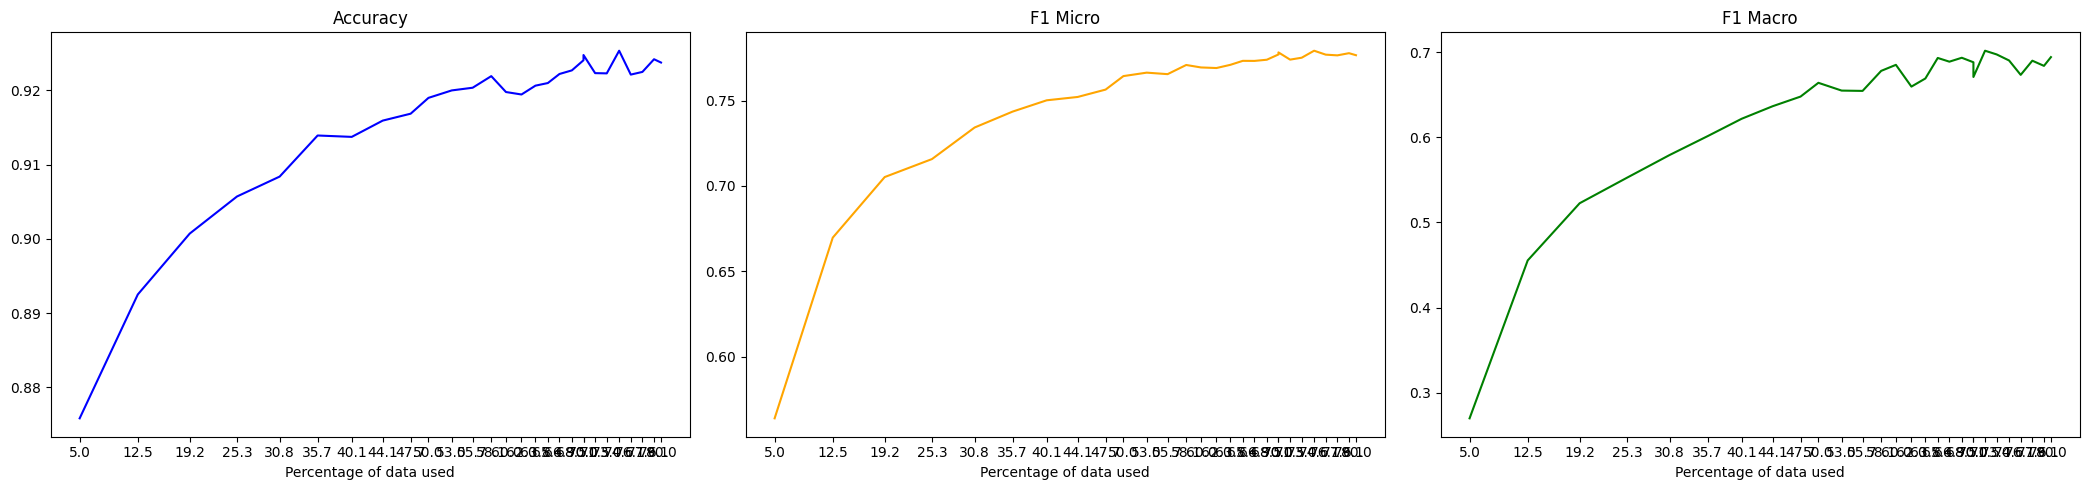

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6215, Accuracy: 0.8191, F1 Micro: 0.1615, F1 Macro: 0.0752
Epoch 2/10, Train Loss: 0.4665, Accuracy: 0.8316, F1 Micro: 0.073, F1 Macro: 0.0276
Epoch 3/10, Train Loss: 0.3955, Accuracy: 0.8331, F1 Micro: 0.0914, F1 Macro: 0.0331
Epoch 4/10, Train Loss: 0.3996, Accuracy: 0.8322, F1 Micro: 0.0663, F1 Macro: 0.0261
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3852, Accuracy: 0.8423, F1 Micro: 0.1862, F1 Macro: 0.0687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3697, Accuracy: 0.8528, F1 Micro: 0.3211, F1 Macro: 0.1051
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3565, Accuracy: 0.8617, F1 Micro: 0.408, F1 Macro: 0.1432
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3315, Accuracy: 0.8738, F1 Micro: 0.5215, F1 Macro: 0.2324
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2962, Accuracy: 0.8754, F1 Micro: 0.5639, F1 Macro: 0.2627
Epoch 10/10, Train Loss: 0.263, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6202, Accuracy: 0.8216, F1 Micro: 0.2374, F1 Macro: 0.0537
Epoch 2/10, Train Loss: 0.4681, Accuracy: 0.8289, F1 Micro: 0.0206, F1 Macro: 0.009
Epoch 3/10, Train Loss: 0.3926, Accuracy: 0.8333, F1 Micro: 0.0952, F1 Macro: 0.0349
Epoch 4/10, Train Loss: 0.4, Accuracy: 0.8342, F1 Micro: 0.1006, F1 Macro: 0.0364
Epoch 5/10, Train Loss: 0.3855, Accuracy: 0.8385, F1 Micro: 0.1788, F1 Macro: 0.0548
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.372, Accuracy: 0.8472, F1 Micro: 0.2544, F1 Macro: 0.0879
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3573, Accuracy: 0.8604, F1 Micro: 0.3983, F1 Macro: 0.1601
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3352, Accuracy: 0.8711, F1 Micro: 0.4901, F1 Macro: 0.2237
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3016, Accuracy: 0.8749, F1 Micro: 0.5685, F1 Macro: 0.264
Epoch 10/10, Train Loss: 0.2699, Accuracy: 0.8753, F1 Micro: 0.533, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5865, Accuracy: 0.8278, F1 Micro: 0.0554, F1 Macro: 0.0267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4603, Accuracy: 0.8362, F1 Micro: 0.1378, F1 Macro: 0.0461
Epoch 3/10, Train Loss: 0.3944, Accuracy: 0.8367, F1 Micro: 0.1344, F1 Macro: 0.0452
Epoch 4/10, Train Loss: 0.3978, Accuracy: 0.8345, F1 Micro: 0.0947, F1 Macro: 0.0352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3828, Accuracy: 0.8479, F1 Micro: 0.2674, F1 Macro: 0.091
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3636, Accuracy: 0.8522, F1 Micro: 0.3052, F1 Macro: 0.1024
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3506, Accuracy: 0.8657, F1 Micro: 0.4335, F1 Macro: 0.1769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3283, Accuracy: 0.8714, F1 Micro: 0.4787, F1 Macro: 0.2164
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2903, Accuracy: 0.8776, F1 Micro: 0.5532, F1 Macro: 0.2618
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5323, Accuracy: 0.8355, F1 Micro: 0.1347, F1 Macro: 0.0442
Epoch 2/10, Train Loss: 0.4102, Accuracy: 0.8336, F1 Micro: 0.0812, F1 Macro: 0.0325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.37, Accuracy: 0.8574, F1 Micro: 0.3994, F1 Macro: 0.1218
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3449, Accuracy: 0.8779, F1 Micro: 0.5473, F1 Macro: 0.2513
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2993, Accuracy: 0.8818, F1 Micro: 0.6145, F1 Macro: 0.3221
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2758, Accuracy: 0.8888, F1 Micro: 0.6331, F1 Macro: 0.3316
Epoch 7/10, Train Loss: 0.2491, Accuracy: 0.8883, F1 Micro: 0.6209, F1 Macro: 0.3332
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2178, Accuracy: 0.8906, F1 Micro: 0.6627, F1 Macro: 0.4728
Epoch 9/10, Train Loss: 0.204, Accuracy: 0.8933, F1 Micro: 0.6546, F1 Macro: 0.4367
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5327, Accuracy: 0.8295, F1 Micro: 0.029, F1 Macro: 0.0125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4094, Accuracy: 0.8356, F1 Micro: 0.121, F1 Macro: 0.0428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3716, Accuracy: 0.8546, F1 Micro: 0.3306, F1 Macro: 0.1197
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3447, Accuracy: 0.8775, F1 Micro: 0.569, F1 Macro: 0.2638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3039, Accuracy: 0.8807, F1 Micro: 0.5782, F1 Macro: 0.2781
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2798, Accuracy: 0.8865, F1 Micro: 0.6311, F1 Macro: 0.3247
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2543, Accuracy: 0.8905, F1 Micro: 0.6392, F1 Macro: 0.3469
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.224, Accuracy: 0.8936, F1 Micro: 0.665, F1 Macro: 0.424
Epoch 9/10, Train Loss: 0.2099, Accuracy: 0.8952, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5175, Accuracy: 0.8387, F1 Micro: 0.1823, F1 Macro: 0.0563
Epoch 2/10, Train Loss: 0.4091, Accuracy: 0.8374, F1 Micro: 0.1306, F1 Macro: 0.049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3674, Accuracy: 0.8606, F1 Micro: 0.436, F1 Macro: 0.1554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3418, Accuracy: 0.8776, F1 Micro: 0.5404, F1 Macro: 0.251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3022, Accuracy: 0.8824, F1 Micro: 0.5859, F1 Macro: 0.2902
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2744, Accuracy: 0.8873, F1 Micro: 0.6416, F1 Macro: 0.3483
Epoch 7/10, Train Loss: 0.2503, Accuracy: 0.8884, F1 Micro: 0.6159, F1 Macro: 0.3433
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2197, Accuracy: 0.8927, F1 Micro: 0.6592, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2033, Accuracy: 0.8945, F1 Micro: 0.6605, F1 Macro: 0.4259
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.49, Accuracy: 0.832, F1 Micro: 0.071, F1 Macro: 0.0275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3814, Accuracy: 0.8562, F1 Micro: 0.3634, F1 Macro: 0.1196
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3304, Accuracy: 0.8772, F1 Micro: 0.6015, F1 Macro: 0.2875
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2885, Accuracy: 0.8874, F1 Micro: 0.6427, F1 Macro: 0.3534
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2452, Accuracy: 0.8919, F1 Micro: 0.6445, F1 Macro: 0.404
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2234, Accuracy: 0.8973, F1 Micro: 0.6926, F1 Macro: 0.4737
Epoch 7/10, Train Loss: 0.2018, Accuracy: 0.8994, F1 Micro: 0.681, F1 Macro: 0.4704
Epoch 8/10, Train Loss: 0.1749, Accuracy: 0.9009, F1 Micro: 0.6863, F1 Macro: 0.4919
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1558, Accuracy: 0.8943, F1 Micro: 0.7059, F1 Macro: 0.5349
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4914, Accuracy: 0.8367, F1 Micro: 0.1446, F1 Macro: 0.0537
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3828, Accuracy: 0.8554, F1 Micro: 0.3599, F1 Macro: 0.1343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3339, Accuracy: 0.8782, F1 Micro: 0.6036, F1 Macro: 0.2862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2912, Accuracy: 0.8832, F1 Micro: 0.6473, F1 Macro: 0.3524
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2543, Accuracy: 0.8919, F1 Micro: 0.6669, F1 Macro: 0.4043
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2336, Accuracy: 0.8974, F1 Micro: 0.6719, F1 Macro: 0.4262
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2051, Accuracy: 0.9006, F1 Micro: 0.6824, F1 Macro: 0.4832
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1821, Accuracy: 0.9034, F1 Micro: 0.7049, F1 Macro: 0.513
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4804, Accuracy: 0.8344, F1 Micro: 0.0927, F1 Macro: 0.035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3793, Accuracy: 0.854, F1 Micro: 0.3291, F1 Macro: 0.1165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3302, Accuracy: 0.881, F1 Micro: 0.5608, F1 Macro: 0.2628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2867, Accuracy: 0.8882, F1 Micro: 0.6496, F1 Macro: 0.3717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2513, Accuracy: 0.8928, F1 Micro: 0.6733, F1 Macro: 0.4104
Epoch 6/10, Train Loss: 0.2293, Accuracy: 0.8969, F1 Micro: 0.6722, F1 Macro: 0.4292
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2052, Accuracy: 0.9, F1 Micro: 0.6818, F1 Macro: 0.468
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1807, Accuracy: 0.9016, F1 Micro: 0.6877, F1 Macro: 0.4847
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1577, Accuracy: 0.8994, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4687, Accuracy: 0.8404, F1 Micro: 0.1726, F1 Macro: 0.064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3537, Accuracy: 0.8771, F1 Micro: 0.5541, F1 Macro: 0.2509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2997, Accuracy: 0.8851, F1 Micro: 0.6445, F1 Macro: 0.3259
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2558, Accuracy: 0.8927, F1 Micro: 0.6499, F1 Macro: 0.368
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2296, Accuracy: 0.8987, F1 Micro: 0.6844, F1 Macro: 0.4779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1959, Accuracy: 0.9038, F1 Micro: 0.6977, F1 Macro: 0.5243
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1706, Accuracy: 0.907, F1 Micro: 0.7121, F1 Macro: 0.5196
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1539, Accuracy: 0.9066, F1 Micro: 0.7181, F1 Macro: 0.5504
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4695, Accuracy: 0.8369, F1 Micro: 0.1413, F1 Macro: 0.0489
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3567, Accuracy: 0.8752, F1 Micro: 0.5953, F1 Macro: 0.2736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3063, Accuracy: 0.8853, F1 Micro: 0.6263, F1 Macro: 0.3087
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2634, Accuracy: 0.8937, F1 Micro: 0.6412, F1 Macro: 0.3742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2369, Accuracy: 0.8999, F1 Micro: 0.6873, F1 Macro: 0.4817
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2005, Accuracy: 0.9033, F1 Micro: 0.6915, F1 Macro: 0.4963
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1762, Accuracy: 0.9079, F1 Micro: 0.7178, F1 Macro: 0.5147
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.154, Accuracy: 0.905, F1 Micro: 0.7184, F1 Macro: 0.5416
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4628, Accuracy: 0.8445, F1 Micro: 0.2319, F1 Macro: 0.0816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3518, Accuracy: 0.8762, F1 Micro: 0.5217, F1 Macro: 0.2317
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2997, Accuracy: 0.8885, F1 Micro: 0.6413, F1 Macro: 0.3358
Epoch 4/10, Train Loss: 0.256, Accuracy: 0.8905, F1 Micro: 0.6247, F1 Macro: 0.3475
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2298, Accuracy: 0.8994, F1 Micro: 0.6884, F1 Macro: 0.49
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.196, Accuracy: 0.9054, F1 Micro: 0.7108, F1 Macro: 0.5229
Epoch 7/10, Train Loss: 0.1688, Accuracy: 0.9067, F1 Micro: 0.7061, F1 Macro: 0.5165
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1514, Accuracy: 0.9053, F1 Micro: 0.72, F1 Macro: 0.5273
Epoch 9/10, Train Loss: 0.1302, Accuracy: 0.9045, F1 Micro: 0.7102, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4525, Accuracy: 0.8487, F1 Micro: 0.295, F1 Macro: 0.0975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3402, Accuracy: 0.88, F1 Micro: 0.6044, F1 Macro: 0.2915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2814, Accuracy: 0.8921, F1 Micro: 0.6338, F1 Macro: 0.3297
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2427, Accuracy: 0.8985, F1 Micro: 0.7021, F1 Macro: 0.4849
Epoch 5/10, Train Loss: 0.2053, Accuracy: 0.9047, F1 Micro: 0.6871, F1 Macro: 0.4885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1863, Accuracy: 0.9054, F1 Micro: 0.7185, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1583, Accuracy: 0.9087, F1 Micro: 0.7235, F1 Macro: 0.5314
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1391, Accuracy: 0.9099, F1 Micro: 0.7292, F1 Macro: 0.5531
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.118, Accuracy: 0.9109, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4514, Accuracy: 0.8466, F1 Micro: 0.2735, F1 Macro: 0.0906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3414, Accuracy: 0.88, F1 Micro: 0.6066, F1 Macro: 0.2869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2844, Accuracy: 0.8927, F1 Micro: 0.6332, F1 Macro: 0.3623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2479, Accuracy: 0.8903, F1 Micro: 0.7001, F1 Macro: 0.4895
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2121, Accuracy: 0.9047, F1 Micro: 0.7072, F1 Macro: 0.5014
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1884, Accuracy: 0.9062, F1 Micro: 0.7235, F1 Macro: 0.537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1601, Accuracy: 0.91, F1 Micro: 0.7324, F1 Macro: 0.5363
Epoch 8/10, Train Loss: 0.1381, Accuracy: 0.9113, F1 Micro: 0.7247, F1 Macro: 0.5555
Epoch 9/10, Train Loss: 0.1171, Accuracy: 0.9067, F1 Micro: 0.7316, F1 Macro: 0.5585
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4477, Accuracy: 0.8499, F1 Micro: 0.325, F1 Macro: 0.1041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3405, Accuracy: 0.8815, F1 Micro: 0.607, F1 Macro: 0.2946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2824, Accuracy: 0.8911, F1 Micro: 0.6219, F1 Macro: 0.3463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2426, Accuracy: 0.8961, F1 Micro: 0.7056, F1 Macro: 0.4954
Epoch 5/10, Train Loss: 0.2073, Accuracy: 0.9036, F1 Micro: 0.6831, F1 Macro: 0.4798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1869, Accuracy: 0.9086, F1 Micro: 0.7208, F1 Macro: 0.5303
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1605, Accuracy: 0.9109, F1 Micro: 0.7315, F1 Macro: 0.5364
Epoch 8/10, Train Loss: 0.1402, Accuracy: 0.9095, F1 Micro: 0.7286, F1 Macro: 0.5521
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1185, Accuracy: 0.9105, F1 Micro: 0.7362, F1 Macro: 0.5556
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4459, Accuracy: 0.8525, F1 Micro: 0.425, F1 Macro: 0.1247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.328, Accuracy: 0.8842, F1 Micro: 0.6369, F1 Macro: 0.3501
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.268, Accuracy: 0.8997, F1 Micro: 0.6854, F1 Macro: 0.44
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2273, Accuracy: 0.9029, F1 Micro: 0.6996, F1 Macro: 0.4645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.203, Accuracy: 0.909, F1 Micro: 0.7215, F1 Macro: 0.5344
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1703, Accuracy: 0.9103, F1 Micro: 0.7319, F1 Macro: 0.5617
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1484, Accuracy: 0.9122, F1 Micro: 0.7403, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1237, Accuracy: 0.9131, F1 Micro: 0.7487, F1 Macro: 0.5884
Epoch 9/10, Train Loss: 0.1117, Accuracy: 0.91, F1 Micro: 0.738

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4449, Accuracy: 0.8554, F1 Micro: 0.3797, F1 Macro: 0.1243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3321, Accuracy: 0.886, F1 Micro: 0.6202, F1 Macro: 0.3057
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2728, Accuracy: 0.8974, F1 Micro: 0.6861, F1 Macro: 0.4508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2332, Accuracy: 0.9032, F1 Micro: 0.6974, F1 Macro: 0.4717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2082, Accuracy: 0.9065, F1 Micro: 0.7155, F1 Macro: 0.538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1727, Accuracy: 0.9111, F1 Micro: 0.7272, F1 Macro: 0.5355
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1496, Accuracy: 0.9108, F1 Micro: 0.7347, F1 Macro: 0.5682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1242, Accuracy: 0.9123, F1 Micro: 0.7372, F1 Macro: 0.5697
Epoch 9/10, Train Loss: 0.1137, Accuracy: 0.9126, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4408, Accuracy: 0.8548, F1 Micro: 0.3862, F1 Macro: 0.1229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3284, Accuracy: 0.8854, F1 Micro: 0.6399, F1 Macro: 0.3385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2701, Accuracy: 0.8971, F1 Micro: 0.672, F1 Macro: 0.4072
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2293, Accuracy: 0.9025, F1 Micro: 0.7073, F1 Macro: 0.4876
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2027, Accuracy: 0.9065, F1 Micro: 0.7222, F1 Macro: 0.5395
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1725, Accuracy: 0.9112, F1 Micro: 0.7242, F1 Macro: 0.5325
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1529, Accuracy: 0.9114, F1 Micro: 0.7324, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1241, Accuracy: 0.9122, F1 Micro: 0.7416, F1 Macro: 0.5715
Epoch 9/10, Train Loss: 0.1134, Accuracy: 0.9111, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4369, Accuracy: 0.8585, F1 Micro: 0.4094, F1 Macro: 0.13
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3223, Accuracy: 0.8905, F1 Micro: 0.6421, F1 Macro: 0.3597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2575, Accuracy: 0.9009, F1 Micro: 0.7021, F1 Macro: 0.4792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2208, Accuracy: 0.9052, F1 Micro: 0.7231, F1 Macro: 0.5376
Epoch 5/10, Train Loss: 0.1947, Accuracy: 0.9084, F1 Micro: 0.7208, F1 Macro: 0.5401
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1639, Accuracy: 0.9151, F1 Micro: 0.745, F1 Macro: 0.5915
Epoch 7/10, Train Loss: 0.1413, Accuracy: 0.9109, F1 Micro: 0.7373, F1 Macro: 0.5679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1219, Accuracy: 0.9149, F1 Micro: 0.7519, F1 Macro: 0.6115
Epoch 9/10, Train Loss: 0.101, Accuracy: 0.9142, F1 Micro: 0.748, F1 Macro: 0.6177
Epoch 10/10, Train Loss: 0.0915, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4354, Accuracy: 0.86, F1 Micro: 0.4122, F1 Macro: 0.1527
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3241, Accuracy: 0.891, F1 Micro: 0.6419, F1 Macro: 0.3463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2597, Accuracy: 0.901, F1 Micro: 0.6945, F1 Macro: 0.4491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2213, Accuracy: 0.9043, F1 Micro: 0.724, F1 Macro: 0.5265
Epoch 5/10, Train Loss: 0.199, Accuracy: 0.9095, F1 Micro: 0.7164, F1 Macro: 0.5075
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.166, Accuracy: 0.9147, F1 Micro: 0.7417, F1 Macro: 0.578
Epoch 7/10, Train Loss: 0.1416, Accuracy: 0.9136, F1 Micro: 0.7393, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1202, Accuracy: 0.9173, F1 Micro: 0.7526, F1 Macro: 0.5975
Epoch 9/10, Train Loss: 0.1005, Accuracy: 0.9162, F1 Micro: 0.7503, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4304, Accuracy: 0.8606, F1 Micro: 0.4115, F1 Macro: 0.1508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3206, Accuracy: 0.8919, F1 Micro: 0.6505, F1 Macro: 0.3598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2558, Accuracy: 0.9018, F1 Micro: 0.6998, F1 Macro: 0.4581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2195, Accuracy: 0.905, F1 Micro: 0.7225, F1 Macro: 0.5104
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1924, Accuracy: 0.9108, F1 Micro: 0.7279, F1 Macro: 0.5549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.162, Accuracy: 0.9148, F1 Micro: 0.7391, F1 Macro: 0.5697
Epoch 7/10, Train Loss: 0.1358, Accuracy: 0.9144, F1 Micro: 0.7346, F1 Macro: 0.5748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1175, Accuracy: 0.9156, F1 Micro: 0.7524, F1 Macro: 0.5984
Epoch 9/10, Train Loss: 0.0993, Accuracy: 0.9153, F1 Micro: 0.7484, F1 Macro: 0.6278
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4288, Accuracy: 0.8677, F1 Micro: 0.4984, F1 Macro: 0.2013
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3072, Accuracy: 0.8929, F1 Micro: 0.6543, F1 Macro: 0.4167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2525, Accuracy: 0.9034, F1 Micro: 0.7122, F1 Macro: 0.5162
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2168, Accuracy: 0.9093, F1 Micro: 0.7252, F1 Macro: 0.5536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1802, Accuracy: 0.9117, F1 Micro: 0.746, F1 Macro: 0.577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1552, Accuracy: 0.9136, F1 Micro: 0.7501, F1 Macro: 0.5969
Epoch 7/10, Train Loss: 0.1342, Accuracy: 0.9182, F1 Micro: 0.7433, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1138, Accuracy: 0.9193, F1 Micro: 0.7599, F1 Macro: 0.6221
Epoch 9/10, Train Loss: 0.099, Accuracy: 0.9191, F1 Micro: 0.7534, F1 Macro: 0.6533
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4291, Accuracy: 0.8707, F1 Micro: 0.5366, F1 Macro: 0.2371
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3121, Accuracy: 0.8921, F1 Micro: 0.6571, F1 Macro: 0.3889
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2549, Accuracy: 0.9022, F1 Micro: 0.706, F1 Macro: 0.4871
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.221, Accuracy: 0.9097, F1 Micro: 0.7135, F1 Macro: 0.5375
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1838, Accuracy: 0.9125, F1 Micro: 0.7404, F1 Macro: 0.5507
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1537, Accuracy: 0.9105, F1 Micro: 0.7483, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1368, Accuracy: 0.9173, F1 Micro: 0.7556, F1 Macro: 0.6137
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1137, Accuracy: 0.9187, F1 Micro: 0.7574, F1 Macro: 0.6153
Epoch 9/10, Train Loss: 0.0966, Accuracy: 0.9208, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4236, Accuracy: 0.8719, F1 Micro: 0.5067, F1 Macro: 0.2124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3081, Accuracy: 0.8926, F1 Micro: 0.6605, F1 Macro: 0.4134
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2519, Accuracy: 0.9039, F1 Micro: 0.7107, F1 Macro: 0.5117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.216, Accuracy: 0.9101, F1 Micro: 0.7133, F1 Macro: 0.5251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1831, Accuracy: 0.9125, F1 Micro: 0.7413, F1 Macro: 0.5468
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1542, Accuracy: 0.9141, F1 Micro: 0.748, F1 Macro: 0.5768
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1357, Accuracy: 0.9183, F1 Micro: 0.7538, F1 Macro: 0.6282
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.916, F1 Micro: 0.747, F1 Macro: 0.5999
Epoch 9/10, Train Loss: 0.0969, Accuracy: 0.9185, F1 Micro: 0.7495, F1 Macro: 0.6386
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4195, Accuracy: 0.8728, F1 Micro: 0.5074, F1 Macro: 0.2198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2934, Accuracy: 0.8966, F1 Micro: 0.6795, F1 Macro: 0.4446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2425, Accuracy: 0.9045, F1 Micro: 0.6959, F1 Macro: 0.4502
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2082, Accuracy: 0.9113, F1 Micro: 0.7388, F1 Macro: 0.5527
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1802, Accuracy: 0.9149, F1 Micro: 0.7522, F1 Macro: 0.589
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9141, F1 Micro: 0.7433, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.918, F1 Micro: 0.755, F1 Macro: 0.6064
Epoch 8/10, Train Loss: 0.113, Accuracy: 0.9195, F1 Micro: 0.7519, F1 Macro: 0.5948
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0923, Accuracy: 0.9179, F1 Micro: 0.7563, F1 Macro: 0.6519
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4199, Accuracy: 0.8723, F1 Micro: 0.5112, F1 Macro: 0.228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2985, Accuracy: 0.8928, F1 Micro: 0.6736, F1 Macro: 0.382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.246, Accuracy: 0.9026, F1 Micro: 0.686, F1 Macro: 0.4331
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.21, Accuracy: 0.9107, F1 Micro: 0.7406, F1 Macro: 0.5671
Epoch 5/10, Train Loss: 0.181, Accuracy: 0.9156, F1 Micro: 0.7368, F1 Macro: 0.5651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1501, Accuracy: 0.9179, F1 Micro: 0.7594, F1 Macro: 0.6098
Epoch 7/10, Train Loss: 0.1334, Accuracy: 0.921, F1 Micro: 0.7547, F1 Macro: 0.6049
Epoch 8/10, Train Loss: 0.1117, Accuracy: 0.9191, F1 Micro: 0.7473, F1 Macro: 0.6036
Epoch 9/10, Train Loss: 0.0945, Accuracy: 0.9197, F1 Micro: 0.7565, F1 Macro: 0.6376
Epoch 10/10, Train Loss: 0.0789, Accuracy: 0.9187, F1 Micro: 0.7584, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4158, Accuracy: 0.87, F1 Micro: 0.4559, F1 Macro: 0.1927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2979, Accuracy: 0.8941, F1 Micro: 0.6795, F1 Macro: 0.416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2435, Accuracy: 0.9051, F1 Micro: 0.6944, F1 Macro: 0.4702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2098, Accuracy: 0.9102, F1 Micro: 0.7388, F1 Macro: 0.554
Epoch 5/10, Train Loss: 0.1811, Accuracy: 0.9153, F1 Micro: 0.7386, F1 Macro: 0.5666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.151, Accuracy: 0.9149, F1 Micro: 0.7462, F1 Macro: 0.59
Epoch 7/10, Train Loss: 0.1331, Accuracy: 0.9172, F1 Micro: 0.745, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1122, Accuracy: 0.9186, F1 Micro: 0.7539, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0902, Accuracy: 0.9152, F1 Micro: 0.7574, F1 Macro: 0.6503
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.42, Accuracy: 0.8766, F1 Micro: 0.5351, F1 Macro: 0.239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.293, Accuracy: 0.8961, F1 Micro: 0.687, F1 Macro: 0.4732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2413, Accuracy: 0.9074, F1 Micro: 0.7046, F1 Macro: 0.4906
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9131, F1 Micro: 0.724, F1 Macro: 0.5379
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1709, Accuracy: 0.9093, F1 Micro: 0.7463, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1491, Accuracy: 0.9156, F1 Micro: 0.7568, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1271, Accuracy: 0.9154, F1 Micro: 0.7577, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1041, Accuracy: 0.9197, F1 Micro: 0.7612, F1 Macro: 0.647
Epoch 9/10, Train Loss: 0.0921, Accuracy: 0.9159, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4213, Accuracy: 0.8728, F1 Micro: 0.5029, F1 Macro: 0.2262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2972, Accuracy: 0.8969, F1 Micro: 0.6839, F1 Macro: 0.4405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2463, Accuracy: 0.9068, F1 Micro: 0.7012, F1 Macro: 0.4899
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2046, Accuracy: 0.9116, F1 Micro: 0.7326, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.174, Accuracy: 0.9095, F1 Micro: 0.7484, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1516, Accuracy: 0.9115, F1 Micro: 0.7534, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1321, Accuracy: 0.9135, F1 Micro: 0.7571, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1049, Accuracy: 0.9166, F1 Micro: 0.7612, F1 Macro: 0.6572
Epoch 9/10, Train Loss: 0.0939, Accuracy: 0.9107, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4152, Accuracy: 0.877, F1 Micro: 0.5318, F1 Macro: 0.2409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2923, Accuracy: 0.8955, F1 Micro: 0.6797, F1 Macro: 0.4493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2426, Accuracy: 0.9054, F1 Micro: 0.6911, F1 Macro: 0.4788
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.9136, F1 Micro: 0.736, F1 Macro: 0.5554
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1719, Accuracy: 0.9083, F1 Micro: 0.7424, F1 Macro: 0.5651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1506, Accuracy: 0.9133, F1 Micro: 0.7546, F1 Macro: 0.5947
Epoch 7/10, Train Loss: 0.1308, Accuracy: 0.9095, F1 Micro: 0.75, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.92, F1 Micro: 0.7602, F1 Macro: 0.6517
Epoch 9/10, Train Loss: 0.0935, Accuracy: 0.9167, F1 Micro: 0.7577, F1 Macro: 0.6484
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4173, Accuracy: 0.8751, F1 Micro: 0.515, F1 Macro: 0.2313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.293, Accuracy: 0.8988, F1 Micro: 0.6692, F1 Macro: 0.4425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2423, Accuracy: 0.8986, F1 Micro: 0.7208, F1 Macro: 0.5501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2096, Accuracy: 0.9128, F1 Micro: 0.7314, F1 Macro: 0.5363
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.178, Accuracy: 0.915, F1 Micro: 0.7504, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9189, F1 Micro: 0.757, F1 Macro: 0.6107
Epoch 7/10, Train Loss: 0.1225, Accuracy: 0.9162, F1 Micro: 0.7555, F1 Macro: 0.616
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1057, Accuracy: 0.9172, F1 Micro: 0.7612, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0869, Accuracy: 0.918, F1 Micro: 0.761

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4189, Accuracy: 0.8731, F1 Micro: 0.4993, F1 Macro: 0.2217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2982, Accuracy: 0.8958, F1 Micro: 0.6488, F1 Macro: 0.3822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2451, Accuracy: 0.9007, F1 Micro: 0.7201, F1 Macro: 0.5308
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2111, Accuracy: 0.9114, F1 Micro: 0.7261, F1 Macro: 0.5065
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.178, Accuracy: 0.9157, F1 Micro: 0.7541, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.148, Accuracy: 0.9214, F1 Micro: 0.7626, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.124, Accuracy: 0.9189, F1 Micro: 0.7638, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1044, Accuracy: 0.919, F1 Micro: 0.7665, F1 Macro: 0.6413
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.9181, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4131, Accuracy: 0.8761, F1 Micro: 0.5119, F1 Macro: 0.2312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2925, Accuracy: 0.8964, F1 Micro: 0.6642, F1 Macro: 0.3976
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2437, Accuracy: 0.9008, F1 Micro: 0.7228, F1 Macro: 0.5454
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2109, Accuracy: 0.9131, F1 Micro: 0.7308, F1 Macro: 0.5378
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9153, F1 Micro: 0.7425, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9187, F1 Micro: 0.758, F1 Macro: 0.606
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9169, F1 Micro: 0.7546, F1 Macro: 0.5902
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1056, Accuracy: 0.9163, F1 Micro: 0.764, F1 Macro: 0.6463
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.9169, F1 Micro: 0.7503, F1 Macro: 0.6441
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4107, Accuracy: 0.878, F1 Micro: 0.5409, F1 Macro: 0.2478
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2851, Accuracy: 0.8996, F1 Micro: 0.6911, F1 Macro: 0.4573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2324, Accuracy: 0.9091, F1 Micro: 0.7344, F1 Macro: 0.5558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2005, Accuracy: 0.9162, F1 Micro: 0.741, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1642, Accuracy: 0.9187, F1 Micro: 0.7621, F1 Macro: 0.6148
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9201, F1 Micro: 0.7613, F1 Macro: 0.6177
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9173, F1 Micro: 0.7565, F1 Macro: 0.6138
Epoch 8/10, Train Loss: 0.102, Accuracy: 0.9154, F1 Micro: 0.7601, F1 Macro: 0.6605
Epoch 9/10, Train Loss: 0.0861, Accuracy: 0.9195, F1 Micro: 0.7614, F1 Macro: 0.6599
Epoch 10/10, Train Loss: 0.0739, Accuracy: 0.9157, F1 Micro: 0.7559, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4101, Accuracy: 0.8767, F1 Micro: 0.5255, F1 Macro: 0.2411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2868, Accuracy: 0.8974, F1 Micro: 0.6863, F1 Macro: 0.4813
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2348, Accuracy: 0.9079, F1 Micro: 0.7287, F1 Macro: 0.5368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2017, Accuracy: 0.9158, F1 Micro: 0.7347, F1 Macro: 0.5823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1675, Accuracy: 0.919, F1 Micro: 0.7552, F1 Macro: 0.5948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.9213, F1 Micro: 0.7593, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1204, Accuracy: 0.9213, F1 Micro: 0.7653, F1 Macro: 0.6354
Epoch 8/10, Train Loss: 0.1054, Accuracy: 0.9189, F1 Micro: 0.7647, F1 Macro: 0.6681
Epoch 9/10, Train Loss: 0.0879, Accuracy: 0.9177, F1 Micro: 0.7637, F1 Macro: 0.6612
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4078, Accuracy: 0.8746, F1 Micro: 0.4978, F1 Macro: 0.2229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2874, Accuracy: 0.8999, F1 Micro: 0.6821, F1 Macro: 0.4515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2324, Accuracy: 0.906, F1 Micro: 0.7256, F1 Macro: 0.5386
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2, Accuracy: 0.9159, F1 Micro: 0.7377, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9185, F1 Micro: 0.7526, F1 Macro: 0.5966
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.92, F1 Micro: 0.7514, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9213, F1 Micro: 0.7642, F1 Macro: 0.6335
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1027, Accuracy: 0.92, F1 Micro: 0.769, F1 Macro: 0.6636
Epoch 9/10, Train Loss: 0.087, Accuracy: 0.9168, F1 Micro: 0.7565, F1 Macro: 0.6544
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4051, Accuracy: 0.8773, F1 Micro: 0.5324, F1 Macro: 0.2475
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2833, Accuracy: 0.8992, F1 Micro: 0.692, F1 Macro: 0.449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2397, Accuracy: 0.9077, F1 Micro: 0.7206, F1 Macro: 0.4898
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2014, Accuracy: 0.9157, F1 Micro: 0.7414, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1649, Accuracy: 0.9166, F1 Micro: 0.7598, F1 Macro: 0.6099
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9196, F1 Micro: 0.7548, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1225, Accuracy: 0.9218, F1 Micro: 0.767, F1 Macro: 0.6343
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9219, F1 Micro: 0.7627, F1 Macro: 0.6656
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9219, F1 Micro: 0.7668, F1 Macro: 0.6757
Epoch 10/10, Train Loss: 0.072, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4061, Accuracy: 0.8814, F1 Micro: 0.5664, F1 Macro: 0.2644
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2855, Accuracy: 0.899, F1 Micro: 0.6939, F1 Macro: 0.4545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2416, Accuracy: 0.9068, F1 Micro: 0.7222, F1 Macro: 0.5133
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1993, Accuracy: 0.9154, F1 Micro: 0.7429, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9173, F1 Micro: 0.7598, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1423, Accuracy: 0.9197, F1 Micro: 0.7629, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.9211, F1 Micro: 0.7696, F1 Macro: 0.638
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.9223, F1 Micro: 0.7652, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9218, F1 Micro: 0.7642, F1 Macro: 0.6625
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4029, Accuracy: 0.877, F1 Micro: 0.5116, F1 Macro: 0.2335
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2838, Accuracy: 0.9002, F1 Micro: 0.6903, F1 Macro: 0.4428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2388, Accuracy: 0.9074, F1 Micro: 0.7216, F1 Macro: 0.5035
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1974, Accuracy: 0.9135, F1 Micro: 0.7432, F1 Macro: 0.5681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9125, F1 Micro: 0.7536, F1 Macro: 0.5923
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9174, F1 Micro: 0.7567, F1 Macro: 0.612
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9219, F1 Micro: 0.7621, F1 Macro: 0.6375
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.9205, F1 Micro: 0.7636, F1 Macro: 0.661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4015, Accuracy: 0.8814, F1 Micro: 0.5833, F1 Macro: 0.2787
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2756, Accuracy: 0.9008, F1 Micro: 0.6988, F1 Macro: 0.465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2321, Accuracy: 0.9112, F1 Micro: 0.721, F1 Macro: 0.5456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9174, F1 Micro: 0.7505, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9163, F1 Micro: 0.7506, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1447, Accuracy: 0.9204, F1 Micro: 0.761, F1 Macro: 0.6265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9225, F1 Micro: 0.7718, F1 Macro: 0.6608
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.9216, F1 Micro: 0.7688, F1 Macro: 0.6668
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.9214, F1 Micro: 0.769, F1 Macro: 0.6854
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.404, Accuracy: 0.8802, F1 Micro: 0.5897, F1 Macro: 0.2842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.9, F1 Micro: 0.6866, F1 Macro: 0.4511
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2368, Accuracy: 0.9116, F1 Micro: 0.725, F1 Macro: 0.5502
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1975, Accuracy: 0.9167, F1 Micro: 0.7467, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1665, Accuracy: 0.9179, F1 Micro: 0.7547, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1428, Accuracy: 0.92, F1 Micro: 0.7563, F1 Macro: 0.6231
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9217, F1 Micro: 0.7715, F1 Macro: 0.6575
Epoch 8/10, Train Loss: 0.0978, Accuracy: 0.922, F1 Micro: 0.7647, F1 Macro: 0.659
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9211, F1 Micro: 0.7714, F1 Macro: 0.6855
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3988, Accuracy: 0.8815, F1 Micro: 0.575, F1 Macro: 0.2802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.8991, F1 Micro: 0.6975, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2347, Accuracy: 0.9111, F1 Micro: 0.7241, F1 Macro: 0.5485
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9177, F1 Micro: 0.7502, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9172, F1 Micro: 0.7522, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9185, F1 Micro: 0.7529, F1 Macro: 0.6087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9213, F1 Micro: 0.7668, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.922, F1 Micro: 0.7724, F1 Macro: 0.6841
Epoch 9/10, Train Loss: 0.0833, Accuracy: 0.9193, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4046, Accuracy: 0.8797, F1 Micro: 0.6074, F1 Macro: 0.2945
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2801, Accuracy: 0.9018, F1 Micro: 0.6699, F1 Macro: 0.4462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2334, Accuracy: 0.9094, F1 Micro: 0.736, F1 Macro: 0.549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.9173, F1 Micro: 0.7513, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.9196, F1 Micro: 0.7603, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9158, F1 Micro: 0.7614, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9187, F1 Micro: 0.7623, F1 Macro: 0.645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.9171, F1 Micro: 0.7673, F1 Macro: 0.6646
Epoch 9/10, Train Loss: 0.0851, Accuracy: 0.9203, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.404, Accuracy: 0.8815, F1 Micro: 0.5883, F1 Macro: 0.2785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2827, Accuracy: 0.9025, F1 Micro: 0.6815, F1 Macro: 0.4646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2317, Accuracy: 0.9067, F1 Micro: 0.7359, F1 Macro: 0.5574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1953, Accuracy: 0.9173, F1 Micro: 0.7521, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1676, Accuracy: 0.9182, F1 Micro: 0.7627, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.9176, F1 Micro: 0.7654, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1165, Accuracy: 0.9178, F1 Micro: 0.7654, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0967, Accuracy: 0.9218, F1 Micro: 0.7707, F1 Macro: 0.6748
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9232, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.401, Accuracy: 0.8816, F1 Micro: 0.6011, F1 Macro: 0.2888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.9026, F1 Micro: 0.6835, F1 Macro: 0.4672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2311, Accuracy: 0.9091, F1 Micro: 0.7345, F1 Macro: 0.527
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1926, Accuracy: 0.9168, F1 Micro: 0.7481, F1 Macro: 0.5718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.165, Accuracy: 0.9199, F1 Micro: 0.7593, F1 Macro: 0.607
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.137, Accuracy: 0.9191, F1 Micro: 0.7657, F1 Macro: 0.6343
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9168, F1 Micro: 0.7552, F1 Macro: 0.6356
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9175, F1 Micro: 0.7632, F1 Macro: 0.6558
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9171, F1 Micro: 0.757, F1 Macro: 0.6574
Epoch 10/10, Train Loss: 0.0735, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3959, Accuracy: 0.8817, F1 Micro: 0.6164, F1 Macro: 0.3038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2751, Accuracy: 0.9027, F1 Micro: 0.7, F1 Macro: 0.4689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.91, F1 Micro: 0.7341, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1886, Accuracy: 0.912, F1 Micro: 0.7504, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1625, Accuracy: 0.9176, F1 Micro: 0.7626, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9173, F1 Micro: 0.7642, F1 Macro: 0.6436
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.9239, F1 Micro: 0.7695, F1 Macro: 0.6677
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9148, F1 Micro: 0.7618, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0846, Accuracy: 0.9258, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3969, Accuracy: 0.8816, F1 Micro: 0.6092, F1 Macro: 0.2905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2788, Accuracy: 0.9022, F1 Micro: 0.7042, F1 Macro: 0.4828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2245, Accuracy: 0.913, F1 Micro: 0.7373, F1 Macro: 0.5466
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.9179, F1 Micro: 0.7524, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.9169, F1 Micro: 0.7631, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9163, F1 Micro: 0.768, F1 Macro: 0.6433
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9209, F1 Micro: 0.7655, F1 Macro: 0.6624
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.9196, F1 Micro: 0.7649, F1 Macro: 0.6677
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.084, Accuracy: 0.9232, F1 Micro: 0.7701, F1 Macro: 0.6764
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3929, Accuracy: 0.8823, F1 Micro: 0.6292, F1 Macro: 0.3165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2746, Accuracy: 0.9031, F1 Micro: 0.6931, F1 Macro: 0.4842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2237, Accuracy: 0.9084, F1 Micro: 0.7373, F1 Macro: 0.5458
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.9132, F1 Micro: 0.7522, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.9175, F1 Micro: 0.7589, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9187, F1 Micro: 0.7676, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1166, Accuracy: 0.9246, F1 Micro: 0.7684, F1 Macro: 0.6589
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0961, Accuracy: 0.9242, F1 Micro: 0.7734, F1 Macro: 0.6773
Epoch 9/10, Train Loss: 0.0813, Accuracy: 0.9232, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3972, Accuracy: 0.8827, F1 Micro: 0.5867, F1 Macro: 0.2949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.9053, F1 Micro: 0.7086, F1 Macro: 0.4991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.9121, F1 Micro: 0.7377, F1 Macro: 0.5661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9182, F1 Micro: 0.7548, F1 Macro: 0.5969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1613, Accuracy: 0.921, F1 Micro: 0.7625, F1 Macro: 0.6093
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9212, F1 Micro: 0.7703, F1 Macro: 0.6362
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9248, F1 Micro: 0.769, F1 Macro: 0.657
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9218, F1 Micro: 0.7695, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0808, Accuracy: 0.9223, F1 Micro: 0.7731, F1 Macro: 0.6927
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.8807, F1 Micro: 0.5497, F1 Macro: 0.2605
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2745, Accuracy: 0.9033, F1 Micro: 0.7039, F1 Macro: 0.4763
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2258, Accuracy: 0.91, F1 Micro: 0.7341, F1 Macro: 0.5788
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9175, F1 Micro: 0.7491, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1613, Accuracy: 0.9191, F1 Micro: 0.7605, F1 Macro: 0.6022
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9197, F1 Micro: 0.7677, F1 Macro: 0.6356
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9207, F1 Micro: 0.7675, F1 Macro: 0.6355
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9204, F1 Micro: 0.7729, F1 Macro: 0.6592
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9201, F1 Micro: 0.7689, F1 Macro: 0.6815
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3938, Accuracy: 0.8808, F1 Micro: 0.5546, F1 Macro: 0.2723
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.9037, F1 Micro: 0.6956, F1 Macro: 0.4715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2252, Accuracy: 0.9112, F1 Micro: 0.7373, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.9178, F1 Micro: 0.7506, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9191, F1 Micro: 0.7589, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9191, F1 Micro: 0.7678, F1 Macro: 0.6277
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.9213, F1 Micro: 0.757, F1 Macro: 0.6404
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9218, F1 Micro: 0.7671, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9218, F1 Micro: 0.7698, F1 Macro: 0.6856
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3959, Accuracy: 0.8832, F1 Micro: 0.6215, F1 Macro: 0.3103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2773, Accuracy: 0.9019, F1 Micro: 0.6654, F1 Macro: 0.4289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.9141, F1 Micro: 0.7464, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1886, Accuracy: 0.9178, F1 Micro: 0.7485, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9163, F1 Micro: 0.757, F1 Macro: 0.6269
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9209, F1 Micro: 0.7714, F1 Macro: 0.6419
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9201, F1 Micro: 0.7692, F1 Macro: 0.6822
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9224, F1 Micro: 0.7636, F1 Macro: 0.6731
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9247, F1 Micro: 0.7721, F1 Macro: 0.6859
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3982, Accuracy: 0.8794, F1 Micro: 0.6207, F1 Macro: 0.2948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2824, Accuracy: 0.9006, F1 Micro: 0.6625, F1 Macro: 0.4188
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2232, Accuracy: 0.9128, F1 Micro: 0.735, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.9171, F1 Micro: 0.743, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9169, F1 Micro: 0.7593, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.9211, F1 Micro: 0.7703, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9201, F1 Micro: 0.7706, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.921, F1 Micro: 0.7708, F1 Macro: 0.6661
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.9218, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3937, Accuracy: 0.8843, F1 Micro: 0.6275, F1 Macro: 0.3069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2789, Accuracy: 0.9005, F1 Micro: 0.6518, F1 Macro: 0.4409
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2237, Accuracy: 0.9125, F1 Micro: 0.7363, F1 Macro: 0.5568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9174, F1 Micro: 0.744, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.9172, F1 Micro: 0.763, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9187, F1 Micro: 0.7659, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.9214, F1 Micro: 0.7707, F1 Macro: 0.6686
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9222, F1 Micro: 0.7682, F1 Macro: 0.6678
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.922, F1 Micro: 0.769, F1 Macro: 0.6785
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3938, Accuracy: 0.8834, F1 Micro: 0.6107, F1 Macro: 0.312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.9051, F1 Micro: 0.6849, F1 Macro: 0.4547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9143, F1 Micro: 0.7427, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9169, F1 Micro: 0.7582, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1547, Accuracy: 0.9214, F1 Micro: 0.7672, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1301, Accuracy: 0.9211, F1 Micro: 0.7731, F1 Macro: 0.6592
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.9213, F1 Micro: 0.7675, F1 Macro: 0.6681
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9211, F1 Micro: 0.7685, F1 Macro: 0.6897
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0783, Accuracy: 0.9221, F1 Micro: 0.7751, F1 Macro: 0.6929
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3953, Accuracy: 0.8822, F1 Micro: 0.567, F1 Macro: 0.274
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2747, Accuracy: 0.904, F1 Micro: 0.6834, F1 Macro: 0.4551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2229, Accuracy: 0.9146, F1 Micro: 0.741, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.9131, F1 Micro: 0.7565, F1 Macro: 0.6032
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.9226, F1 Micro: 0.765, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9239, F1 Micro: 0.7702, F1 Macro: 0.6416
Epoch 7/10, Train Loss: 0.1099, Accuracy: 0.9233, F1 Micro: 0.7665, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9233, F1 Micro: 0.7716, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9242, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3915, Accuracy: 0.8836, F1 Micro: 0.587, F1 Macro: 0.2926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2725, Accuracy: 0.9038, F1 Micro: 0.6818, F1 Macro: 0.4632
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2217, Accuracy: 0.9132, F1 Micro: 0.7447, F1 Macro: 0.5694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1828, Accuracy: 0.9157, F1 Micro: 0.7582, F1 Macro: 0.5893
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1559, Accuracy: 0.9204, F1 Micro: 0.7669, F1 Macro: 0.6267
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.922, F1 Micro: 0.7636, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9158, F1 Micro: 0.7679, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9215, F1 Micro: 0.7682, F1 Macro: 0.6862
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9203, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.8845, F1 Micro: 0.6047, F1 Macro: 0.3268
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.905, F1 Micro: 0.7128, F1 Macro: 0.4961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2229, Accuracy: 0.9144, F1 Micro: 0.7436, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9204, F1 Micro: 0.7632, F1 Macro: 0.6117
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9191, F1 Micro: 0.7676, F1 Macro: 0.6315
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.9226, F1 Micro: 0.7691, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.9242, F1 Micro: 0.7736, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.9235, F1 Micro: 0.7739, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3928, Accuracy: 0.8862, F1 Micro: 0.619, F1 Macro: 0.3155
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.9059, F1 Micro: 0.7056, F1 Macro: 0.4959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.9141, F1 Micro: 0.7467, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9201, F1 Micro: 0.7596, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9171, F1 Micro: 0.7673, F1 Macro: 0.6192
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.9215, F1 Micro: 0.7656, F1 Macro: 0.6571
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9234, F1 Micro: 0.7644, F1 Macro: 0.6658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9211, F1 Micro: 0.7711, F1 Macro: 0.666
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9239, F1 Micro: 0.778, F1 Macro: 0.6881
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3887, Accuracy: 0.8861, F1 Micro: 0.6081, F1 Macro: 0.3249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2612, Accuracy: 0.9049, F1 Micro: 0.702, F1 Macro: 0.4735
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2218, Accuracy: 0.9143, F1 Micro: 0.7428, F1 Macro: 0.5741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9176, F1 Micro: 0.7616, F1 Macro: 0.5938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1552, Accuracy: 0.9186, F1 Micro: 0.7684, F1 Macro: 0.6284
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.921, F1 Micro: 0.7584, F1 Macro: 0.6472
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9225, F1 Micro: 0.7598, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9193, F1 Micro: 0.7668, F1 Macro: 0.6739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.923, F1 Micro: 0.7741, F1 Macro: 0.695
Epoch 10/10, Train Loss: 0.0651, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.392, Accuracy: 0.8855, F1 Micro: 0.6269, F1 Macro: 0.323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2649, Accuracy: 0.9045, F1 Micro: 0.7091, F1 Macro: 0.4919
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.9132, F1 Micro: 0.7412, F1 Macro: 0.5746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.9182, F1 Micro: 0.7652, F1 Macro: 0.6136
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9198, F1 Micro: 0.7637, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.924, F1 Micro: 0.7723, F1 Macro: 0.6638
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9231, F1 Micro: 0.771, F1 Macro: 0.6546
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9242, F1 Micro: 0.7663, F1 Macro: 0.6684
Epoch 9/10, Train Loss: 0.077, Accuracy: 0.9204, F1 Micro: 0.768, F1 Macro: 0.6823
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0665, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8855, F1 Micro: 0.6036, F1 Macro: 0.2999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2679, Accuracy: 0.9033, F1 Micro: 0.7139, F1 Macro: 0.5213
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.9143, F1 Micro: 0.7379, F1 Macro: 0.5651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.921, F1 Micro: 0.7575, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1547, Accuracy: 0.9172, F1 Micro: 0.7641, F1 Macro: 0.6272
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9252, F1 Micro: 0.7776, F1 Macro: 0.6573
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.923, F1 Micro: 0.7738, F1 Macro: 0.6702
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9204, F1 Micro: 0.7695, F1 Macro: 0.6706
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.924, F1 Micro: 0.7718, F1 Macro: 0.6822
Epoch 10/10, Train Loss: 0.0655, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8856, F1 Micro: 0.6159, F1 Macro: 0.3242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2644, Accuracy: 0.9053, F1 Micro: 0.712, F1 Macro: 0.51
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2196, Accuracy: 0.9146, F1 Micro: 0.7434, F1 Macro: 0.5692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9212, F1 Micro: 0.7634, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9206, F1 Micro: 0.7663, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9223, F1 Micro: 0.7685, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.9195, F1 Micro: 0.7697, F1 Macro: 0.6753
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9239, F1 Micro: 0.7682, F1 Macro: 0.6756
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9182, F1 Micro: 0.7649, F1 Macro: 0.6784
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3901, Accuracy: 0.8832, F1 Micro: 0.5746, F1 Macro: 0.2942
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9067, F1 Micro: 0.7149, F1 Macro: 0.5087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2226, Accuracy: 0.9151, F1 Micro: 0.738, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9166, F1 Micro: 0.7428, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.9144, F1 Micro: 0.7653, F1 Macro: 0.6407
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.923, F1 Micro: 0.7724, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9235, F1 Micro: 0.774, F1 Macro: 0.6722
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9209, F1 Micro: 0.7692, F1 Macro: 0.6807
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9241, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8838, F1 Micro: 0.582, F1 Macro: 0.2817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.9042, F1 Micro: 0.7117, F1 Macro: 0.5087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2258, Accuracy: 0.9153, F1 Micro: 0.7415, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9187, F1 Micro: 0.7575, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.913, F1 Micro: 0.7605, F1 Macro: 0.6232
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9227, F1 Micro: 0.7669, F1 Macro: 0.6425
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.924, F1 Micro: 0.7701, F1 Macro: 0.6492
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.9221, F1 Micro: 0.7695, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9243, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.8842, F1 Micro: 0.5858, F1 Macro: 0.2932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2681, Accuracy: 0.9061, F1 Micro: 0.714, F1 Macro: 0.5181
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.9139, F1 Micro: 0.7405, F1 Macro: 0.5649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.917, F1 Micro: 0.7519, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9187, F1 Micro: 0.7673, F1 Macro: 0.6381
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.9236, F1 Micro: 0.7652, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9237, F1 Micro: 0.7718, F1 Macro: 0.6642
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9181, F1 Micro: 0.7674, F1 Macro: 0.6939
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9237, F1 Micro: 0.7669, F1 Macro: 0.6807
Epoch 10/10, Train Loss: 0.0631, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3876, Accuracy: 0.8824, F1 Micro: 0.5766, F1 Macro: 0.2974
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.9076, F1 Micro: 0.7136, F1 Macro: 0.5039
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.9161, F1 Micro: 0.7512, F1 Macro: 0.5901
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9219, F1 Micro: 0.762, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9207, F1 Micro: 0.7697, F1 Macro: 0.6481
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9233, F1 Micro: 0.7695, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9245, F1 Micro: 0.7776, F1 Macro: 0.6884
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9224, F1 Micro: 0.7738, F1 Macro: 0.6837
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9217, F1 Micro: 0.7751, F1 Macro: 0.6935
Epoch 10/10, Train Loss: 0.0677, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.389, Accuracy: 0.8832, F1 Micro: 0.5951, F1 Macro: 0.2956
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.9065, F1 Micro: 0.7121, F1 Macro: 0.5218
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.9163, F1 Micro: 0.743, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.921, F1 Micro: 0.7605, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.9213, F1 Micro: 0.7702, F1 Macro: 0.6506
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9232, F1 Micro: 0.7685, F1 Macro: 0.6465
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.924, F1 Micro: 0.7797, F1 Macro: 0.6796
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9228, F1 Micro: 0.7713, F1 Macro: 0.6905
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9216, F1 Micro: 0.7742, F1 Macro: 0.6878
Epoch 10/10, Train Loss: 0.0651, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3854, Accuracy: 0.8836, F1 Micro: 0.5942, F1 Macro: 0.3073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.9061, F1 Micro: 0.7124, F1 Macro: 0.5203
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.9149, F1 Micro: 0.7425, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9203, F1 Micro: 0.7576, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9172, F1 Micro: 0.7638, F1 Macro: 0.6438
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.13, Accuracy: 0.9211, F1 Micro: 0.7651, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9225, F1 Micro: 0.7686, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9207, F1 Micro: 0.7698, F1 Macro: 0.6924
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3854, Accuracy: 0.8826, F1 Micro: 0.5582, F1 Macro: 0.2834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9042, F1 Micro: 0.7125, F1 Macro: 0.548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2167, Accuracy: 0.915, F1 Micro: 0.747, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9217, F1 Micro: 0.758, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9187, F1 Micro: 0.7673, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.924, F1 Micro: 0.7781, F1 Macro: 0.6563
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9202, F1 Micro: 0.774, F1 Macro: 0.6832
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9232, F1 Micro: 0.7709, F1 Macro: 0.6724
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9224, F1 Micro: 0.7691, F1 Macro: 0.6788
Epoch 10/10, Train Loss: 0.0657, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3891, Accuracy: 0.8835, F1 Micro: 0.5657, F1 Macro: 0.2794
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2662, Accuracy: 0.9052, F1 Micro: 0.7104, F1 Macro: 0.5342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.9152, F1 Micro: 0.7492, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9225, F1 Micro: 0.7695, F1 Macro: 0.6134
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9179, F1 Micro: 0.7547, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9247, F1 Micro: 0.7748, F1 Macro: 0.6632
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9158, F1 Micro: 0.7678, F1 Macro: 0.6757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9249, F1 Micro: 0.775, F1 Macro: 0.6668
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9169, F1 Micro: 0.7631, F1 Macro: 0.6735
Epoch 10/10, Train Loss: 0.0641, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.8846, F1 Micro: 0.5777, F1 Macro: 0.3021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2615, Accuracy: 0.9047, F1 Micro: 0.7158, F1 Macro: 0.5385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2168, Accuracy: 0.9141, F1 Micro: 0.7405, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.9184, F1 Micro: 0.7566, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9211, F1 Micro: 0.7622, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.924, F1 Micro: 0.7692, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9203, F1 Micro: 0.773, F1 Macro: 0.6777
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9213, F1 Micro: 0.7677, F1 Macro: 0.6742
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9204, F1 Micro: 0.768, F1 Macro: 0.6703
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3827, Accuracy: 0.8865, F1 Micro: 0.5988, F1 Macro: 0.3173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.9063, F1 Micro: 0.7236, F1 Macro: 0.5285
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9098, F1 Micro: 0.7462, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9207, F1 Micro: 0.7665, F1 Macro: 0.6137
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.921, F1 Micro: 0.772, F1 Macro: 0.6465
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9214, F1 Micro: 0.7715, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.924, F1 Micro: 0.7781, F1 Macro: 0.69
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9232, F1 Micro: 0.7767, F1 Macro: 0.7002
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9241, F1 Micro: 0.7744, F1 Macro: 0.6939
Epoch 10/10, Train Loss: 0.0696, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3856, Accuracy: 0.8876, F1 Micro: 0.6325, F1 Macro: 0.3152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.9075, F1 Micro: 0.7223, F1 Macro: 0.5221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2083, Accuracy: 0.9138, F1 Micro: 0.7535, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9221, F1 Micro: 0.7636, F1 Macro: 0.6145
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9204, F1 Micro: 0.7724, F1 Macro: 0.6381
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9205, F1 Micro: 0.7691, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9231, F1 Micro: 0.7802, F1 Macro: 0.6904
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.9239, F1 Micro: 0.7781, F1 Macro: 0.6826
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9246, F1 Micro: 0.7781, F1 Macro: 0.6965
Epoch 10/10, Train Loss: 0.0689, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3802, Accuracy: 0.8888, F1 Micro: 0.6317, F1 Macro: 0.3415
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.259, Accuracy: 0.9055, F1 Micro: 0.7196, F1 Macro: 0.5115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9122, F1 Micro: 0.7463, F1 Macro: 0.5872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9211, F1 Micro: 0.7605, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9165, F1 Micro: 0.7653, F1 Macro: 0.66
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9199, F1 Micro: 0.7668, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9213, F1 Micro: 0.7723, F1 Macro: 0.6863
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9228, F1 Micro: 0.7757, F1 Macro: 0.6916
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9236, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3785, Accuracy: 0.8886, F1 Micro: 0.6543, F1 Macro: 0.3906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2546, Accuracy: 0.9084, F1 Micro: 0.7155, F1 Macro: 0.5104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9174, F1 Micro: 0.7465, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9174, F1 Micro: 0.7652, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9212, F1 Micro: 0.7721, F1 Macro: 0.6443
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.9212, F1 Micro: 0.7672, F1 Macro: 0.6662
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1015, Accuracy: 0.9235, F1 Micro: 0.7721, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9223, F1 Micro: 0.774, F1 Macro: 0.6944
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9215, F1 Micro: 0.7717, F1 Macro: 0.694
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3804, Accuracy: 0.8878, F1 Micro: 0.6407, F1 Macro: 0.3492
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2578, Accuracy: 0.9075, F1 Micro: 0.708, F1 Macro: 0.5057
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2122, Accuracy: 0.9174, F1 Micro: 0.7509, F1 Macro: 0.5873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9202, F1 Micro: 0.7691, F1 Macro: 0.6117
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9171, F1 Micro: 0.767, F1 Macro: 0.6395
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9201, F1 Micro: 0.7674, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9249, F1 Micro: 0.777, F1 Macro: 0.673
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.92, F1 Micro: 0.7704, F1 Macro: 0.6835
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9145, F1 Micro: 0.7676, F1 Macro: 0.6858
Epoch 10/10, Train Loss: 0.0641, Accuracy: 0.9213, F1 Micro: 0.772, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3779, Accuracy: 0.8889, F1 Micro: 0.6408, F1 Macro: 0.3628
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9085, F1 Micro: 0.7145, F1 Macro: 0.5082
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9169, F1 Micro: 0.7471, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9187, F1 Micro: 0.7647, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9151, F1 Micro: 0.7647, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9234, F1 Micro: 0.7716, F1 Macro: 0.6675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9244, F1 Micro: 0.7749, F1 Macro: 0.6834
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9226, F1 Micro: 0.7736, F1 Macro: 0.695
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9242, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3764, Accuracy: 0.889, F1 Micro: 0.6296, F1 Macro: 0.3351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.9071, F1 Micro: 0.7127, F1 Macro: 0.5075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9169, F1 Micro: 0.7415, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9183, F1 Micro: 0.7619, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9226, F1 Micro: 0.7663, F1 Macro: 0.6335
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9231, F1 Micro: 0.7621, F1 Macro: 0.6243
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9234, F1 Micro: 0.769, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9231, F1 Micro: 0.7797, F1 Macro: 0.6938
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.922, F1 Micro: 0.7752, F1 Macro: 0.6953
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3779, Accuracy: 0.8886, F1 Micro: 0.6159, F1 Macro: 0.3093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.9086, F1 Micro: 0.7133, F1 Macro: 0.4915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.916, F1 Micro: 0.7415, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.919, F1 Micro: 0.7647, F1 Macro: 0.6144
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9226, F1 Micro: 0.7646, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9228, F1 Micro: 0.7675, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9215, F1 Micro: 0.7703, F1 Macro: 0.6557
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9228, F1 Micro: 0.7784, F1 Macro: 0.6834
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9208, F1 Micro: 0.7763, F1 Macro: 0.7003
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3741, Accuracy: 0.8901, F1 Micro: 0.6303, F1 Macro: 0.349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.9075, F1 Micro: 0.7124, F1 Macro: 0.5017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9184, F1 Micro: 0.7518, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9199, F1 Micro: 0.7571, F1 Macro: 0.604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9221, F1 Micro: 0.7662, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9241, F1 Micro: 0.767, F1 Macro: 0.6389
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9214, F1 Micro: 0.7659, F1 Macro: 0.6705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.924, F1 Micro: 0.7765, F1 Macro: 0.6857
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9236, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.8858, F1 Micro: 0.5844, F1 Macro: 0.3014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.9094, F1 Micro: 0.7177, F1 Macro: 0.5126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9178, F1 Micro: 0.7442, F1 Macro: 0.5811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9164, F1 Micro: 0.7636, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.923, F1 Micro: 0.7639, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9232, F1 Micro: 0.7739, F1 Macro: 0.6747
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9232, F1 Micro: 0.7721, F1 Macro: 0.6884
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9244, F1 Micro: 0.7764, F1 Macro: 0.7015
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9218, F1 Micro: 0.7744, F1 Macro: 0.6984
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.8832, F1 Micro: 0.5621, F1 Macro: 0.2755
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2549, Accuracy: 0.9092, F1 Micro: 0.7143, F1 Macro: 0.515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9176, F1 Micro: 0.7428, F1 Macro: 0.5796
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9178, F1 Micro: 0.7624, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9215, F1 Micro: 0.7631, F1 Macro: 0.6323
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9241, F1 Micro: 0.7812, F1 Macro: 0.6724
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9219, F1 Micro: 0.7658, F1 Macro: 0.6757
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9223, F1 Micro: 0.7733, F1 Macro: 0.6933
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9145, F1 Micro: 0.7646, F1 Macro: 0.6771
Epoch 10/10, Train Loss: 0.0611, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3689, Accuracy: 0.8849, F1 Micro: 0.5847, F1 Macro: 0.3062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.9088, F1 Micro: 0.7157, F1 Macro: 0.5144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.9174, F1 Micro: 0.7424, F1 Macro: 0.572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9176, F1 Micro: 0.7641, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9231, F1 Micro: 0.7707, F1 Macro: 0.6509
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9212, F1 Micro: 0.7693, F1 Macro: 0.6664
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9239, F1 Micro: 0.7685, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9214, F1 Micro: 0.7718, F1 Macro: 0.6942
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9159, F1 Micro: 0.7701, F1 Macro: 0.6933
Higher F1 achieved, saving model
Epoch 

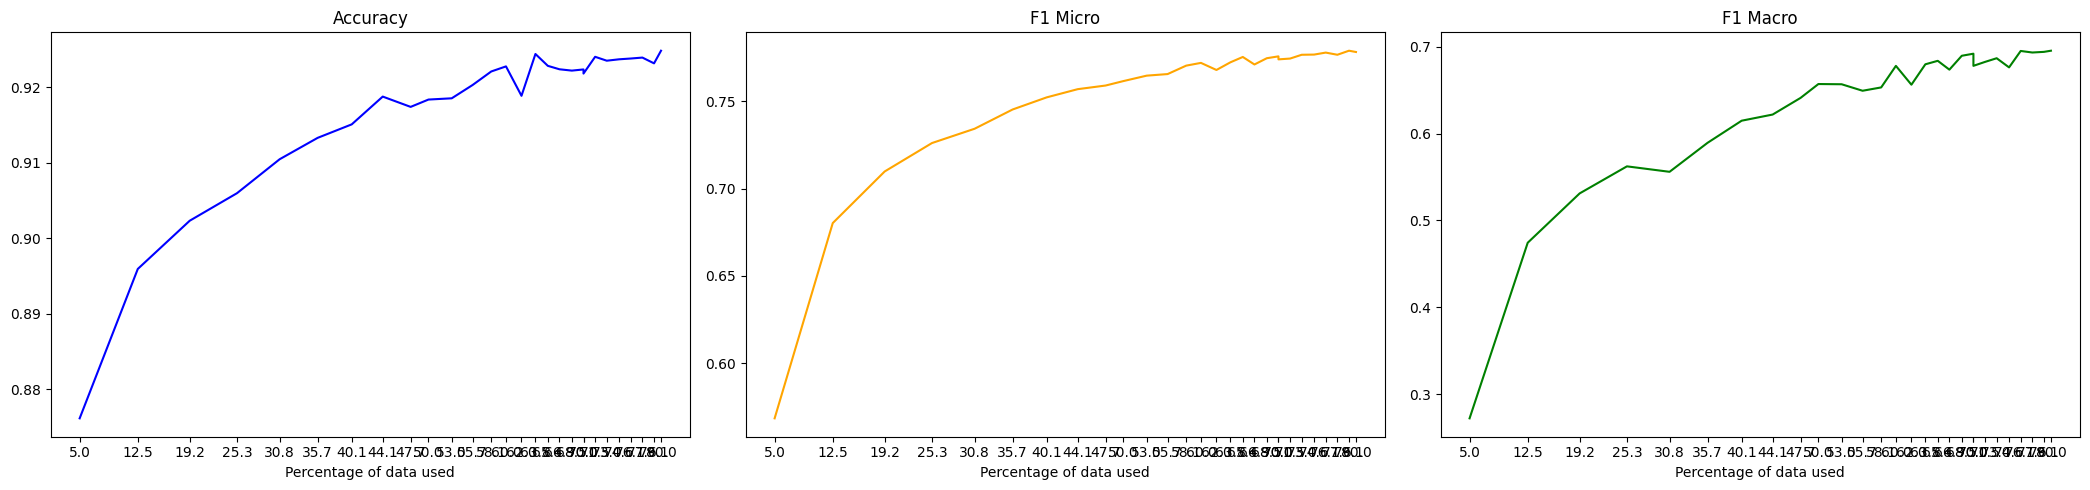

In [28]:
active_learning(seeds[4], 4)